**this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

i got 0.657 using densenet201(in version 3) **

i tried  efficientnetb4 but it failed for large image size,so i will try efficientnetb3 now with bce dice loss
if you find this kernel useful,please upvote,your upvote motivates kagglers like us to share things publicly,thanks

**Version 13**

- updating previously used submission.csv with version 3's generated submission file which achieved 0.657

- threshold = 0.9

- efficientnetb2

- loss='categorical_crossentropy', metrics=['accuracy']

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Jan](https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing segmentation submission](#Post-processing-segmentation-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!pip install keras-rectified-adam

In [2]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [3]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Flower, Fish}",1,1,0,0
1,002be4f.jpg,"{Sugar, Flower, Fish}",1,1,1,0
2,0031ae9.jpg,"{Sugar, Flower, Fish}",1,1,1,0
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1
4,003994e.jpg,"{Sugar, Gravel, Fish}",1,0,1,1


In [5]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [6]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [7]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=350, resized_width=525, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_width, self.resized_height), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [8]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [23]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=16)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=16)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=16)

# PR-AUC-based Callback

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [18]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=5, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'efficientNetB5_350x525_epoch_*')):
                os.remove(checkpoint)
            self.best_pr_auc = pr_auc_mean
            self.model.save(os.path.join(self.checkpoints_path, f'efficientNetB5_350x525_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
            print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

Callback instances

In [19]:
train_metric_callback = PrAucCallback(data_generator_train_eval)
val_callback = PrAucCallback(data_generator_val, stage='val')

# Classifier

## Defining a model

In [20]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
DELETE !pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
!pip install -U --pre efficientnet

In [21]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB5(weights='imagenet', include_top=False, pooling='avg', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

In [22]:
from keras_radam import RAdam

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350, 525, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 175, 263, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 175, 263, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 175, 263, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

                                                                 block1b_add[0][0]                
__________________________________________________________________________________________________
block2a_expand_conv (Conv2D)    (None, 175, 263, 144 3456        block1c_add[0][0]                
__________________________________________________________________________________________________
block2a_expand_bn (BatchNormali (None, 175, 263, 144 576         block2a_expand_conv[0][0]        
__________________________________________________________________________________________________
block2a_expand_activation (Acti (None, 175, 263, 144 0           block2a_expand_bn[0][0]          
__________________________________________________________________________________________________
block2a_dwconv (DepthwiseConv2D (None, 88, 132, 144) 1296        block2a_expand_activation[0][0]  
__________________________________________________________________________________________________
block2a_bn

                                                                 block2c_se_expand[0][0]          
__________________________________________________________________________________________________
block2c_project_conv (Conv2D)   (None, 88, 132, 40)  9600        block2c_se_excite[0][0]          
__________________________________________________________________________________________________
block2c_project_bn (BatchNormal (None, 88, 132, 40)  160         block2c_project_conv[0][0]       
__________________________________________________________________________________________________
block2c_drop (FixedDropout)     (None, 88, 132, 40)  0           block2c_project_bn[0][0]         
__________________________________________________________________________________________________
block2c_add (Add)               (None, 88, 132, 40)  0           block2c_drop[0][0]               
                                                                 block2b_add[0][0]                
__________

__________________________________________________________________________________________________
block3a_bn (BatchNormalization) (None, 44, 66, 240)  960         block3a_dwconv[0][0]             
__________________________________________________________________________________________________
block3a_activation (Activation) (None, 44, 66, 240)  0           block3a_bn[0][0]                 
__________________________________________________________________________________________________
block3a_se_squeeze (GlobalAvera (None, 240)          0           block3a_activation[0][0]         
__________________________________________________________________________________________________
block3a_se_reshape (Reshape)    (None, 1, 1, 240)    0           block3a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 10)     2410        block3a_se_reshape[0][0]         
__________

                                                                 block3b_add[0][0]                
__________________________________________________________________________________________________
block3d_expand_conv (Conv2D)    (None, 44, 66, 384)  24576       block3c_add[0][0]                
__________________________________________________________________________________________________
block3d_expand_bn (BatchNormali (None, 44, 66, 384)  1536        block3d_expand_conv[0][0]        
__________________________________________________________________________________________________
block3d_expand_activation (Acti (None, 44, 66, 384)  0           block3d_expand_bn[0][0]          
__________________________________________________________________________________________________
block3d_dwconv (DepthwiseConv2D (None, 44, 66, 384)  9600        block3d_expand_activation[0][0]  
__________________________________________________________________________________________________
block3d_bn

block4a_se_reduce (Conv2D)      (None, 1, 1, 16)     6160        block4a_se_reshape[0][0]         
__________________________________________________________________________________________________
block4a_se_expand (Conv2D)      (None, 1, 1, 384)    6528        block4a_se_reduce[0][0]          
__________________________________________________________________________________________________
block4a_se_excite (Multiply)    (None, 22, 33, 384)  0           block4a_activation[0][0]         
                                                                 block4a_se_expand[0][0]          
__________________________________________________________________________________________________
block4a_project_conv (Conv2D)   (None, 22, 33, 128)  49152       block4a_se_excite[0][0]          
__________________________________________________________________________________________________
block4a_project_bn (BatchNormal (None, 22, 33, 128)  512         block4a_project_conv[0][0]       
__________

__________________________________________________________________________________________________
block4d_bn (BatchNormalization) (None, 22, 33, 768)  3072        block4d_dwconv[0][0]             
__________________________________________________________________________________________________
block4d_activation (Activation) (None, 22, 33, 768)  0           block4d_bn[0][0]                 
__________________________________________________________________________________________________
block4d_se_squeeze (GlobalAvera (None, 768)          0           block4d_activation[0][0]         
__________________________________________________________________________________________________
block4d_se_reshape (Reshape)    (None, 1, 1, 768)    0           block4d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4d_se_reduce (Conv2D)      (None, 1, 1, 32)     24608       block4d_se_reshape[0][0]         
__________

block4f_project_bn (BatchNormal (None, 22, 33, 128)  512         block4f_project_conv[0][0]       
__________________________________________________________________________________________________
block4f_drop (FixedDropout)     (None, 22, 33, 128)  0           block4f_project_bn[0][0]         
__________________________________________________________________________________________________
block4f_add (Add)               (None, 22, 33, 128)  0           block4f_drop[0][0]               
                                                                 block4e_add[0][0]                
__________________________________________________________________________________________________
block4g_expand_conv (Conv2D)    (None, 22, 33, 768)  98304       block4f_add[0][0]                
__________________________________________________________________________________________________
block4g_expand_bn (BatchNormali (None, 22, 33, 768)  3072        block4g_expand_conv[0][0]        
__________

block5b_se_reduce (Conv2D)      (None, 1, 1, 44)     46508       block5b_se_reshape[0][0]         
__________________________________________________________________________________________________
block5b_se_expand (Conv2D)      (None, 1, 1, 1056)   47520       block5b_se_reduce[0][0]          
__________________________________________________________________________________________________
block5b_se_excite (Multiply)    (None, 22, 33, 1056) 0           block5b_activation[0][0]         
                                                                 block5b_se_expand[0][0]          
__________________________________________________________________________________________________
block5b_project_conv (Conv2D)   (None, 22, 33, 176)  185856      block5b_se_excite[0][0]          
__________________________________________________________________________________________________
block5b_project_bn (BatchNormal (None, 22, 33, 176)  704         block5b_project_conv[0][0]       
__________

block5e_expand_bn (BatchNormali (None, 22, 33, 1056) 4224        block5e_expand_conv[0][0]        
__________________________________________________________________________________________________
block5e_expand_activation (Acti (None, 22, 33, 1056) 0           block5e_expand_bn[0][0]          
__________________________________________________________________________________________________
block5e_dwconv (DepthwiseConv2D (None, 22, 33, 1056) 26400       block5e_expand_activation[0][0]  
__________________________________________________________________________________________________
block5e_bn (BatchNormalization) (None, 22, 33, 1056) 4224        block5e_dwconv[0][0]             
__________________________________________________________________________________________________
block5e_activation (Activation) (None, 22, 33, 1056) 0           block5e_bn[0][0]                 
__________________________________________________________________________________________________
block5e_se

block5g_se_excite (Multiply)    (None, 22, 33, 1056) 0           block5g_activation[0][0]         
                                                                 block5g_se_expand[0][0]          
__________________________________________________________________________________________________
block5g_project_conv (Conv2D)   (None, 22, 33, 176)  185856      block5g_se_excite[0][0]          
__________________________________________________________________________________________________
block5g_project_bn (BatchNormal (None, 22, 33, 176)  704         block5g_project_conv[0][0]       
__________________________________________________________________________________________________
block5g_drop (FixedDropout)     (None, 22, 33, 176)  0           block5g_project_bn[0][0]         
__________________________________________________________________________________________________
block5g_add (Add)               (None, 22, 33, 176)  0           block5g_drop[0][0]               
          

__________________________________________________________________________________________________
block6c_se_squeeze (GlobalAvera (None, 1824)         0           block6c_activation[0][0]         
__________________________________________________________________________________________________
block6c_se_reshape (Reshape)    (None, 1, 1, 1824)   0           block6c_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6c_se_reduce (Conv2D)      (None, 1, 1, 76)     138700      block6c_se_reshape[0][0]         
__________________________________________________________________________________________________
block6c_se_expand (Conv2D)      (None, 1, 1, 1824)   140448      block6c_se_reduce[0][0]          
__________________________________________________________________________________________________
block6c_se_excite (Multiply)    (None, 11, 17, 1824) 0           block6c_activation[0][0]         
          

block6e_add (Add)               (None, 11, 17, 304)  0           block6e_drop[0][0]               
                                                                 block6d_add[0][0]                
__________________________________________________________________________________________________
block6f_expand_conv (Conv2D)    (None, 11, 17, 1824) 554496      block6e_add[0][0]                
__________________________________________________________________________________________________
block6f_expand_bn (BatchNormali (None, 11, 17, 1824) 7296        block6f_expand_conv[0][0]        
__________________________________________________________________________________________________
block6f_expand_activation (Acti (None, 11, 17, 1824) 0           block6f_expand_bn[0][0]          
__________________________________________________________________________________________________
block6f_dwconv (DepthwiseConv2D (None, 11, 17, 1824) 45600       block6f_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block6h_se_reduce (Conv2D)      (None, 1, 1, 76)     138700      block6h_se_reshape[0][0]         
__________________________________________________________________________________________________
block6h_se_expand (Conv2D)      (None, 1, 1, 1824)   140448      block6h_se_reduce[0][0]          
__________________________________________________________________________________________________
block6h_se_excite (Multiply)    (None, 11, 17, 1824) 0           block6h_activation[0][0]         
                                                                 block6h_se_expand[0][0]          
__________________________________________________________________________________________________
block6h_project_conv (Conv2D)   (None, 11, 17, 304)  554496      block6h_se_excite[0][0]          
__________________________________________________________________________________________________
block6h_pr

block7b_dwconv (DepthwiseConv2D (None, 11, 17, 3072) 27648       block7b_expand_activation[0][0]  
__________________________________________________________________________________________________
block7b_bn (BatchNormalization) (None, 11, 17, 3072) 12288       block7b_dwconv[0][0]             
__________________________________________________________________________________________________
block7b_activation (Activation) (None, 11, 17, 3072) 0           block7b_bn[0][0]                 
__________________________________________________________________________________________________
block7b_se_squeeze (GlobalAvera (None, 3072)         0           block7b_activation[0][0]         
__________________________________________________________________________________________________
block7b_se_reshape (Reshape)    (None, 1, 1, 3072)   0           block7b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block7b_se

## Initial tuning of the added fully-connected layer

In [24]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_0 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=10,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10


205/277 [=====================>........] - ETA: 1:00:14 - loss: 3.3318 - acc: 0.43 - ETA: 31:22 - loss: 3.2773 - acc: 0.3750 - ETA: 21:46 - loss: 3.2077 - acc: 0.33 - ETA: 16:58 - loss: 3.2609 - acc: 0.29 - ETA: 14:06 - loss: 3.2533 - acc: 0.28 - ETA: 12:09 - loss: 3.2168 - acc: 0.27 - ETA: 10:47 - loss: 3.1782 - acc: 0.26 - ETA: 9:45 - loss: 3.1754 - acc: 0.2734 - ETA: 8:57 - loss: 3.1762 - acc: 0.250 - ETA: 8:18 - loss: 3.1870 - acc: 0.250 - ETA: 7:45 - loss: 3.1497 - acc: 0.255 - ETA: 7:19 - loss: 3.0978 - acc: 0.250 - ETA: 6:56 - loss: 3.0975 - acc: 0.240 - ETA: 6:37 - loss: 3.1207 - acc: 0.232 - ETA: 6:19 - loss: 3.1269 - acc: 0.229 - ETA: 6:04 - loss: 3.1170 - acc: 0.226 - ETA: 5:51 - loss: 3.1028 - acc: 0.216 - ETA: 5:39 - loss: 3.1214 - acc: 0.215 - ETA: 5:28 - loss: 3.1219 - acc: 0.230 - ETA: 5:19 - loss: 3.1000 - acc: 0.231 - ETA: 5:10 - loss: 3.1062 - acc: 0.229 - ETA: 5:02 - loss: 3.1114 - acc: 0.230 - ETA: 4:54 - loss: 3.1082 - acc: 0.233 - ETA: 4:47 - loss: 3.1070 - acc: 

277/277 [==============================] - ETA: 48s - loss: 2.9482 - acc: 0.24 - ETA: 47s - loss: 2.9445 - acc: 0.24 - ETA: 46s - loss: 2.9445 - acc: 0.24 - ETA: 46s - loss: 2.9434 - acc: 0.24 - ETA: 45s - loss: 2.9448 - acc: 0.24 - ETA: 44s - loss: 2.9460 - acc: 0.24 - ETA: 44s - loss: 2.9453 - acc: 0.24 - ETA: 43s - loss: 2.9434 - acc: 0.24 - ETA: 42s - loss: 2.9462 - acc: 0.24 - ETA: 41s - loss: 2.9467 - acc: 0.24 - ETA: 41s - loss: 2.9476 - acc: 0.24 - ETA: 40s - loss: 2.9491 - acc: 0.24 - ETA: 39s - loss: 2.9491 - acc: 0.24 - ETA: 39s - loss: 2.9480 - acc: 0.24 - ETA: 38s - loss: 2.9496 - acc: 0.24 - ETA: 37s - loss: 2.9471 - acc: 0.24 - ETA: 37s - loss: 2.9478 - acc: 0.24 - ETA: 36s - loss: 2.9484 - acc: 0.24 - ETA: 35s - loss: 2.9463 - acc: 0.24 - ETA: 35s - loss: 2.9460 - acc: 0.24 - ETA: 34s - loss: 2.9450 - acc: 0.24 - ETA: 33s - loss: 2.9456 - acc: 0.24 - ETA: 33s - loss: 2.9463 - acc: 0.24 - ETA: 32s - loss: 2.9447 - acc: 0.24 - ETA: 31s - loss: 2.9446 - acc: 0.24 - ETA: 30

206/277 [=====================>........] - ETA: 2:45 - loss: 2.9959 - acc: 0.187 - ETA: 2:47 - loss: 2.8481 - acc: 0.281 - ETA: 2:47 - loss: 2.7880 - acc: 0.291 - ETA: 2:47 - loss: 2.8445 - acc: 0.265 - ETA: 2:47 - loss: 2.9140 - acc: 0.250 - ETA: 2:47 - loss: 2.9310 - acc: 0.239 - ETA: 2:46 - loss: 2.8607 - acc: 0.285 - ETA: 2:45 - loss: 2.8284 - acc: 0.296 - ETA: 2:45 - loss: 2.8310 - acc: 0.291 - ETA: 2:44 - loss: 2.8477 - acc: 0.293 - ETA: 2:43 - loss: 2.8265 - acc: 0.301 - ETA: 2:43 - loss: 2.7903 - acc: 0.291 - ETA: 2:42 - loss: 2.7858 - acc: 0.293 - ETA: 2:41 - loss: 2.8281 - acc: 0.285 - ETA: 2:41 - loss: 2.8346 - acc: 0.283 - ETA: 2:40 - loss: 2.8357 - acc: 0.289 - ETA: 2:40 - loss: 2.8493 - acc: 0.286 - ETA: 2:39 - loss: 2.8272 - acc: 0.291 - ETA: 2:39 - loss: 2.8479 - acc: 0.282 - ETA: 2:38 - loss: 2.8055 - acc: 0.281 - ETA: 2:37 - loss: 2.7988 - acc: 0.279 - ETA: 2:37 - loss: 2.7970 - acc: 0.281 - ETA: 2:36 - loss: 2.8373 - acc: 0.269 - ETA: 2:36 - loss: 2.8213 - acc: 0.265

277/277 [==============================] - ETA: 43s - loss: 2.8343 - acc: 0.31 - ETA: 42s - loss: 2.8372 - acc: 0.31 - ETA: 42s - loss: 2.8384 - acc: 0.31 - ETA: 41s - loss: 2.8388 - acc: 0.31 - ETA: 40s - loss: 2.8414 - acc: 0.31 - ETA: 40s - loss: 2.8408 - acc: 0.31 - ETA: 39s - loss: 2.8415 - acc: 0.31 - ETA: 38s - loss: 2.8419 - acc: 0.31 - ETA: 38s - loss: 2.8417 - acc: 0.31 - ETA: 37s - loss: 2.8437 - acc: 0.31 - ETA: 37s - loss: 2.8410 - acc: 0.31 - ETA: 36s - loss: 2.8417 - acc: 0.31 - ETA: 35s - loss: 2.8387 - acc: 0.31 - ETA: 35s - loss: 2.8397 - acc: 0.31 - ETA: 34s - loss: 2.8377 - acc: 0.31 - ETA: 34s - loss: 2.8371 - acc: 0.31 - ETA: 33s - loss: 2.8370 - acc: 0.31 - ETA: 32s - loss: 2.8337 - acc: 0.31 - ETA: 32s - loss: 2.8357 - acc: 0.31 - ETA: 31s - loss: 2.8378 - acc: 0.31 - ETA: 30s - loss: 2.8370 - acc: 0.31 - ETA: 30s - loss: 2.8368 - acc: 0.31 - ETA: 29s - loss: 2.8369 - acc: 0.31 - ETA: 29s - loss: 2.8382 - acc: 0.31 - ETA: 28s - loss: 2.8393 - acc: 0.31 - ETA: 27

205/277 [=====================>........] - ETA: 2:47 - loss: 3.0036 - acc: 0.312 - ETA: 2:47 - loss: 2.9344 - acc: 0.218 - ETA: 2:46 - loss: 2.9792 - acc: 0.270 - ETA: 2:47 - loss: 2.9398 - acc: 0.281 - ETA: 2:47 - loss: 2.9321 - acc: 0.300 - ETA: 2:47 - loss: 2.8883 - acc: 0.291 - ETA: 2:46 - loss: 2.9189 - acc: 0.303 - ETA: 2:45 - loss: 2.9209 - acc: 0.320 - ETA: 2:45 - loss: 2.9124 - acc: 0.312 - ETA: 2:44 - loss: 2.9330 - acc: 0.312 - ETA: 2:44 - loss: 2.9194 - acc: 0.329 - ETA: 2:43 - loss: 2.9642 - acc: 0.338 - ETA: 2:43 - loss: 2.9313 - acc: 0.355 - ETA: 2:42 - loss: 2.9138 - acc: 0.352 - ETA: 2:41 - loss: 2.8889 - acc: 0.345 - ETA: 2:41 - loss: 2.8454 - acc: 0.355 - ETA: 2:40 - loss: 2.8218 - acc: 0.356 - ETA: 2:40 - loss: 2.8373 - acc: 0.354 - ETA: 2:39 - loss: 2.8205 - acc: 0.352 - ETA: 2:38 - loss: 2.8308 - acc: 0.350 - ETA: 2:38 - loss: 2.8414 - acc: 0.357 - ETA: 2:37 - loss: 2.8511 - acc: 0.360 - ETA: 2:36 - loss: 2.8543 - acc: 0.361 - ETA: 2:36 - loss: 2.8616 - acc: 0.362

277/277 [==============================] - ETA: 44s - loss: 2.7822 - acc: 0.36 - ETA: 43s - loss: 2.7838 - acc: 0.36 - ETA: 42s - loss: 2.7834 - acc: 0.36 - ETA: 42s - loss: 2.7850 - acc: 0.36 - ETA: 41s - loss: 2.7854 - acc: 0.36 - ETA: 40s - loss: 2.7852 - acc: 0.36 - ETA: 40s - loss: 2.7839 - acc: 0.36 - ETA: 39s - loss: 2.7833 - acc: 0.36 - ETA: 39s - loss: 2.7833 - acc: 0.36 - ETA: 38s - loss: 2.7860 - acc: 0.36 - ETA: 37s - loss: 2.7860 - acc: 0.36 - ETA: 37s - loss: 2.7863 - acc: 0.36 - ETA: 36s - loss: 2.7876 - acc: 0.36 - ETA: 36s - loss: 2.7861 - acc: 0.36 - ETA: 35s - loss: 2.7847 - acc: 0.36 - ETA: 34s - loss: 2.7836 - acc: 0.36 - ETA: 34s - loss: 2.7849 - acc: 0.36 - ETA: 33s - loss: 2.7855 - acc: 0.36 - ETA: 32s - loss: 2.7836 - acc: 0.36 - ETA: 32s - loss: 2.7845 - acc: 0.36 - ETA: 31s - loss: 2.7823 - acc: 0.36 - ETA: 31s - loss: 2.7822 - acc: 0.36 - ETA: 30s - loss: 2.7795 - acc: 0.36 - ETA: 29s - loss: 2.7786 - acc: 0.36 - ETA: 29s - loss: 2.7805 - acc: 0.36 - ETA: 28

205/277 [=====================>........] - ETA: 2:49 - loss: 2.7737 - acc: 0.437 - ETA: 2:48 - loss: 2.7783 - acc: 0.406 - ETA: 2:49 - loss: 2.6857 - acc: 0.416 - ETA: 2:49 - loss: 2.6124 - acc: 0.390 - ETA: 2:49 - loss: 2.6574 - acc: 0.362 - ETA: 2:48 - loss: 2.7339 - acc: 0.333 - ETA: 2:48 - loss: 2.7784 - acc: 0.312 - ETA: 2:47 - loss: 2.7477 - acc: 0.320 - ETA: 2:46 - loss: 2.7201 - acc: 0.319 - ETA: 2:46 - loss: 2.7072 - acc: 0.325 - ETA: 2:45 - loss: 2.7253 - acc: 0.335 - ETA: 2:44 - loss: 2.7217 - acc: 0.338 - ETA: 2:43 - loss: 2.7308 - acc: 0.341 - ETA: 2:43 - loss: 2.7620 - acc: 0.343 - ETA: 2:42 - loss: 2.7855 - acc: 0.333 - ETA: 2:42 - loss: 2.7854 - acc: 0.328 - ETA: 2:41 - loss: 2.7822 - acc: 0.323 - ETA: 2:40 - loss: 2.8060 - acc: 0.322 - ETA: 2:40 - loss: 2.7756 - acc: 0.335 - ETA: 2:39 - loss: 2.7845 - acc: 0.328 - ETA: 2:38 - loss: 2.8023 - acc: 0.324 - ETA: 2:38 - loss: 2.7905 - acc: 0.326 - ETA: 2:37 - loss: 2.7917 - acc: 0.328 - ETA: 2:37 - loss: 2.7980 - acc: 0.335

277/277 [==============================] - ETA: 44s - loss: 2.7934 - acc: 0.35 - ETA: 43s - loss: 2.7944 - acc: 0.35 - ETA: 42s - loss: 2.7916 - acc: 0.35 - ETA: 42s - loss: 2.7943 - acc: 0.35 - ETA: 41s - loss: 2.7930 - acc: 0.35 - ETA: 40s - loss: 2.7915 - acc: 0.35 - ETA: 40s - loss: 2.7923 - acc: 0.35 - ETA: 39s - loss: 2.7915 - acc: 0.35 - ETA: 39s - loss: 2.7894 - acc: 0.35 - ETA: 38s - loss: 2.7912 - acc: 0.35 - ETA: 37s - loss: 2.7916 - acc: 0.35 - ETA: 37s - loss: 2.7903 - acc: 0.35 - ETA: 36s - loss: 2.7898 - acc: 0.36 - ETA: 36s - loss: 2.7899 - acc: 0.35 - ETA: 35s - loss: 2.7917 - acc: 0.36 - ETA: 34s - loss: 2.7920 - acc: 0.36 - ETA: 34s - loss: 2.7939 - acc: 0.36 - ETA: 33s - loss: 2.7954 - acc: 0.35 - ETA: 32s - loss: 2.7949 - acc: 0.35 - ETA: 32s - loss: 2.7935 - acc: 0.36 - ETA: 31s - loss: 2.7928 - acc: 0.35 - ETA: 31s - loss: 2.7925 - acc: 0.36 - ETA: 30s - loss: 2.7929 - acc: 0.36 - ETA: 29s - loss: 2.7903 - acc: 0.36 - ETA: 29s - loss: 2.7905 - acc: 0.36 - ETA: 28

205/277 [=====================>........] - ETA: 2:47 - loss: 2.2749 - acc: 0.437 - ETA: 2:48 - loss: 2.7782 - acc: 0.343 - ETA: 2:48 - loss: 2.8891 - acc: 0.354 - ETA: 2:48 - loss: 2.9098 - acc: 0.343 - ETA: 2:48 - loss: 2.7738 - acc: 0.425 - ETA: 2:47 - loss: 2.7520 - acc: 0.416 - ETA: 2:47 - loss: 2.8165 - acc: 0.401 - ETA: 2:46 - loss: 2.7765 - acc: 0.421 - ETA: 2:45 - loss: 2.8073 - acc: 0.430 - ETA: 2:45 - loss: 2.7816 - acc: 0.425 - ETA: 2:44 - loss: 2.7779 - acc: 0.414 - ETA: 2:44 - loss: 2.7879 - acc: 0.401 - ETA: 2:43 - loss: 2.7904 - acc: 0.394 - ETA: 2:42 - loss: 2.7944 - acc: 0.406 - ETA: 2:42 - loss: 2.7745 - acc: 0.400 - ETA: 2:42 - loss: 2.7594 - acc: 0.394 - ETA: 2:41 - loss: 2.7631 - acc: 0.389 - ETA: 2:40 - loss: 2.7628 - acc: 0.388 - ETA: 2:40 - loss: 2.7693 - acc: 0.384 - ETA: 2:39 - loss: 2.7781 - acc: 0.378 - ETA: 2:39 - loss: 2.7683 - acc: 0.383 - ETA: 2:38 - loss: 2.7560 - acc: 0.386 - ETA: 2:37 - loss: 2.7675 - acc: 0.383 - ETA: 2:37 - loss: 2.7657 - acc: 0.385

277/277 [==============================] - ETA: 44s - loss: 2.7708 - acc: 0.37 - ETA: 43s - loss: 2.7716 - acc: 0.37 - ETA: 42s - loss: 2.7720 - acc: 0.37 - ETA: 42s - loss: 2.7711 - acc: 0.37 - ETA: 41s - loss: 2.7725 - acc: 0.37 - ETA: 41s - loss: 2.7711 - acc: 0.37 - ETA: 40s - loss: 2.7704 - acc: 0.37 - ETA: 39s - loss: 2.7717 - acc: 0.37 - ETA: 39s - loss: 2.7710 - acc: 0.37 - ETA: 38s - loss: 2.7702 - acc: 0.37 - ETA: 37s - loss: 2.7703 - acc: 0.37 - ETA: 37s - loss: 2.7703 - acc: 0.37 - ETA: 36s - loss: 2.7700 - acc: 0.37 - ETA: 36s - loss: 2.7714 - acc: 0.37 - ETA: 35s - loss: 2.7704 - acc: 0.37 - ETA: 34s - loss: 2.7702 - acc: 0.37 - ETA: 34s - loss: 2.7689 - acc: 0.37 - ETA: 33s - loss: 2.7685 - acc: 0.37 - ETA: 32s - loss: 2.7677 - acc: 0.37 - ETA: 32s - loss: 2.7664 - acc: 0.37 - ETA: 31s - loss: 2.7677 - acc: 0.37 - ETA: 31s - loss: 2.7681 - acc: 0.37 - ETA: 30s - loss: 2.7675 - acc: 0.37 - ETA: 29s - loss: 2.7659 - acc: 0.37 - ETA: 29s - loss: 2.7643 - acc: 0.38 - ETA: 28

205/277 [=====================>........] - ETA: 2:45 - loss: 2.6129 - acc: 0.375 - ETA: 2:47 - loss: 3.1085 - acc: 0.312 - ETA: 2:47 - loss: 2.7826 - acc: 0.375 - ETA: 2:47 - loss: 2.8225 - acc: 0.390 - ETA: 2:46 - loss: 2.8704 - acc: 0.387 - ETA: 2:47 - loss: 2.9756 - acc: 0.354 - ETA: 2:46 - loss: 2.9450 - acc: 0.366 - ETA: 2:46 - loss: 2.9474 - acc: 0.382 - ETA: 2:46 - loss: 2.8765 - acc: 0.388 - ETA: 2:45 - loss: 2.8268 - acc: 0.387 - ETA: 2:45 - loss: 2.8489 - acc: 0.392 - ETA: 2:44 - loss: 2.8411 - acc: 0.395 - ETA: 2:43 - loss: 2.8530 - acc: 0.403 - ETA: 2:42 - loss: 2.8549 - acc: 0.401 - ETA: 2:42 - loss: 2.8758 - acc: 0.400 - ETA: 2:42 - loss: 2.8839 - acc: 0.390 - ETA: 2:41 - loss: 2.8684 - acc: 0.389 - ETA: 2:40 - loss: 2.8685 - acc: 0.385 - ETA: 2:40 - loss: 2.8399 - acc: 0.384 - ETA: 2:39 - loss: 2.8416 - acc: 0.390 - ETA: 2:38 - loss: 2.8234 - acc: 0.398 - ETA: 2:38 - loss: 2.8034 - acc: 0.403 - ETA: 2:37 - loss: 2.7987 - acc: 0.402 - ETA: 2:37 - loss: 2.7649 - acc: 0.398

277/277 [==============================] - ETA: 44s - loss: 2.7565 - acc: 0.39 - ETA: 43s - loss: 2.7554 - acc: 0.39 - ETA: 42s - loss: 2.7548 - acc: 0.39 - ETA: 42s - loss: 2.7555 - acc: 0.39 - ETA: 41s - loss: 2.7565 - acc: 0.39 - ETA: 40s - loss: 2.7550 - acc: 0.39 - ETA: 40s - loss: 2.7563 - acc: 0.39 - ETA: 39s - loss: 2.7560 - acc: 0.39 - ETA: 39s - loss: 2.7541 - acc: 0.39 - ETA: 38s - loss: 2.7553 - acc: 0.39 - ETA: 37s - loss: 2.7553 - acc: 0.39 - ETA: 37s - loss: 2.7587 - acc: 0.39 - ETA: 36s - loss: 2.7612 - acc: 0.39 - ETA: 36s - loss: 2.7627 - acc: 0.39 - ETA: 35s - loss: 2.7620 - acc: 0.39 - ETA: 34s - loss: 2.7621 - acc: 0.39 - ETA: 34s - loss: 2.7633 - acc: 0.39 - ETA: 33s - loss: 2.7634 - acc: 0.38 - ETA: 32s - loss: 2.7650 - acc: 0.39 - ETA: 32s - loss: 2.7649 - acc: 0.39 - ETA: 31s - loss: 2.7653 - acc: 0.39 - ETA: 31s - loss: 2.7687 - acc: 0.39 - ETA: 30s - loss: 2.7701 - acc: 0.38 - ETA: 29s - loss: 2.7723 - acc: 0.38 - ETA: 29s - loss: 2.7744 - acc: 0.38 - ETA: 28

205/277 [=====================>........] - ETA: 2:47 - loss: 3.0385 - acc: 0.187 - ETA: 2:46 - loss: 2.9267 - acc: 0.156 - ETA: 2:45 - loss: 2.6837 - acc: 0.187 - ETA: 2:46 - loss: 2.7825 - acc: 0.265 - ETA: 2:46 - loss: 2.7665 - acc: 0.275 - ETA: 2:45 - loss: 2.7846 - acc: 0.250 - ETA: 2:46 - loss: 2.7905 - acc: 0.232 - ETA: 2:45 - loss: 2.8221 - acc: 0.226 - ETA: 2:45 - loss: 2.8360 - acc: 0.250 - ETA: 2:44 - loss: 2.8507 - acc: 0.268 - ETA: 2:43 - loss: 2.8408 - acc: 0.289 - ETA: 2:43 - loss: 2.8289 - acc: 0.307 - ETA: 2:43 - loss: 2.8282 - acc: 0.302 - ETA: 2:42 - loss: 2.8178 - acc: 0.312 - ETA: 2:42 - loss: 2.8556 - acc: 0.320 - ETA: 2:41 - loss: 2.8353 - acc: 0.324 - ETA: 2:41 - loss: 2.8649 - acc: 0.323 - ETA: 2:40 - loss: 2.8317 - acc: 0.333 - ETA: 2:39 - loss: 2.8111 - acc: 0.342 - ETA: 2:39 - loss: 2.8281 - acc: 0.340 - ETA: 2:38 - loss: 2.8182 - acc: 0.336 - ETA: 2:38 - loss: 2.8092 - acc: 0.338 - ETA: 2:37 - loss: 2.8186 - acc: 0.345 - ETA: 2:37 - loss: 2.8394 - acc: 0.349

277/277 [==============================] - ETA: 44s - loss: 2.7853 - acc: 0.37 - ETA: 43s - loss: 2.7829 - acc: 0.37 - ETA: 42s - loss: 2.7831 - acc: 0.37 - ETA: 42s - loss: 2.7798 - acc: 0.37 - ETA: 41s - loss: 2.7766 - acc: 0.37 - ETA: 41s - loss: 2.7775 - acc: 0.37 - ETA: 40s - loss: 2.7779 - acc: 0.37 - ETA: 39s - loss: 2.7781 - acc: 0.37 - ETA: 39s - loss: 2.7795 - acc: 0.37 - ETA: 38s - loss: 2.7786 - acc: 0.37 - ETA: 37s - loss: 2.7780 - acc: 0.37 - ETA: 37s - loss: 2.7770 - acc: 0.37 - ETA: 36s - loss: 2.7793 - acc: 0.37 - ETA: 36s - loss: 2.7804 - acc: 0.37 - ETA: 35s - loss: 2.7797 - acc: 0.37 - ETA: 34s - loss: 2.7789 - acc: 0.37 - ETA: 34s - loss: 2.7759 - acc: 0.37 - ETA: 33s - loss: 2.7752 - acc: 0.37 - ETA: 32s - loss: 2.7788 - acc: 0.37 - ETA: 32s - loss: 2.7778 - acc: 0.37 - ETA: 31s - loss: 2.7769 - acc: 0.37 - ETA: 31s - loss: 2.7787 - acc: 0.37 - ETA: 30s - loss: 2.7800 - acc: 0.37 - ETA: 29s - loss: 2.7791 - acc: 0.37 - ETA: 29s - loss: 2.7770 - acc: 0.37 - ETA: 28

205/277 [=====================>........] - ETA: 2:48 - loss: 2.8432 - acc: 0.312 - ETA: 2:48 - loss: 2.8300 - acc: 0.218 - ETA: 2:49 - loss: 2.6763 - acc: 0.250 - ETA: 2:49 - loss: 2.6796 - acc: 0.250 - ETA: 2:49 - loss: 2.6756 - acc: 0.262 - ETA: 2:48 - loss: 2.7261 - acc: 0.260 - ETA: 2:47 - loss: 2.7173 - acc: 0.303 - ETA: 2:46 - loss: 2.7764 - acc: 0.289 - ETA: 2:46 - loss: 2.8003 - acc: 0.291 - ETA: 2:45 - loss: 2.7766 - acc: 0.318 - ETA: 2:44 - loss: 2.7652 - acc: 0.329 - ETA: 2:44 - loss: 2.7951 - acc: 0.322 - ETA: 2:43 - loss: 2.7938 - acc: 0.317 - ETA: 2:43 - loss: 2.7798 - acc: 0.321 - ETA: 2:42 - loss: 2.7671 - acc: 0.325 - ETA: 2:41 - loss: 2.7506 - acc: 0.328 - ETA: 2:41 - loss: 2.7324 - acc: 0.334 - ETA: 2:40 - loss: 2.7348 - acc: 0.333 - ETA: 2:39 - loss: 2.7205 - acc: 0.342 - ETA: 2:39 - loss: 2.7341 - acc: 0.337 - ETA: 2:38 - loss: 2.7086 - acc: 0.342 - ETA: 2:37 - loss: 2.6923 - acc: 0.346 - ETA: 2:37 - loss: 2.7150 - acc: 0.342 - ETA: 2:36 - loss: 2.7263 - acc: 0.343

277/277 [==============================] - ETA: 44s - loss: 2.7660 - acc: 0.38 - ETA: 43s - loss: 2.7617 - acc: 0.38 - ETA: 42s - loss: 2.7599 - acc: 0.39 - ETA: 42s - loss: 2.7605 - acc: 0.39 - ETA: 41s - loss: 2.7615 - acc: 0.38 - ETA: 41s - loss: 2.7614 - acc: 0.38 - ETA: 40s - loss: 2.7614 - acc: 0.38 - ETA: 39s - loss: 2.7646 - acc: 0.38 - ETA: 39s - loss: 2.7632 - acc: 0.38 - ETA: 38s - loss: 2.7664 - acc: 0.38 - ETA: 37s - loss: 2.7657 - acc: 0.38 - ETA: 37s - loss: 2.7654 - acc: 0.38 - ETA: 36s - loss: 2.7665 - acc: 0.38 - ETA: 36s - loss: 2.7682 - acc: 0.38 - ETA: 35s - loss: 2.7656 - acc: 0.38 - ETA: 34s - loss: 2.7647 - acc: 0.39 - ETA: 34s - loss: 2.7660 - acc: 0.38 - ETA: 33s - loss: 2.7653 - acc: 0.39 - ETA: 32s - loss: 2.7654 - acc: 0.39 - ETA: 32s - loss: 2.7647 - acc: 0.39 - ETA: 31s - loss: 2.7655 - acc: 0.38 - ETA: 31s - loss: 2.7663 - acc: 0.38 - ETA: 30s - loss: 2.7676 - acc: 0.38 - ETA: 29s - loss: 2.7651 - acc: 0.38 - ETA: 29s - loss: 2.7658 - acc: 0.38 - ETA: 28

205/277 [=====================>........] - ETA: 3:02 - loss: 2.7057 - acc: 0.437 - ETA: 3:08 - loss: 2.6594 - acc: 0.375 - ETA: 3:08 - loss: 2.8814 - acc: 0.312 - ETA: 3:07 - loss: 2.7502 - acc: 0.359 - ETA: 3:03 - loss: 2.6595 - acc: 0.362 - ETA: 3:01 - loss: 2.7533 - acc: 0.354 - ETA: 2:59 - loss: 2.7543 - acc: 0.366 - ETA: 2:56 - loss: 2.6952 - acc: 0.375 - ETA: 2:55 - loss: 2.6562 - acc: 0.347 - ETA: 2:53 - loss: 2.6969 - acc: 0.331 - ETA: 2:52 - loss: 2.7231 - acc: 0.346 - ETA: 2:51 - loss: 2.7218 - acc: 0.338 - ETA: 2:49 - loss: 2.7492 - acc: 0.341 - ETA: 2:48 - loss: 2.7754 - acc: 0.330 - ETA: 2:47 - loss: 2.8080 - acc: 0.337 - ETA: 2:46 - loss: 2.8263 - acc: 0.343 - ETA: 2:45 - loss: 2.8027 - acc: 0.360 - ETA: 2:44 - loss: 2.8129 - acc: 0.361 - ETA: 2:43 - loss: 2.7954 - acc: 0.361 - ETA: 2:43 - loss: 2.7727 - acc: 0.356 - ETA: 2:42 - loss: 2.7655 - acc: 0.360 - ETA: 2:41 - loss: 2.7733 - acc: 0.363 - ETA: 2:40 - loss: 2.7803 - acc: 0.364 - ETA: 2:40 - loss: 2.7634 - acc: 0.369

277/277 [==============================] - ETA: 44s - loss: 2.7622 - acc: 0.38 - ETA: 43s - loss: 2.7649 - acc: 0.38 - ETA: 43s - loss: 2.7634 - acc: 0.38 - ETA: 42s - loss: 2.7651 - acc: 0.38 - ETA: 41s - loss: 2.7665 - acc: 0.38 - ETA: 41s - loss: 2.7624 - acc: 0.38 - ETA: 40s - loss: 2.7635 - acc: 0.38 - ETA: 39s - loss: 2.7630 - acc: 0.38 - ETA: 39s - loss: 2.7629 - acc: 0.38 - ETA: 38s - loss: 2.7634 - acc: 0.38 - ETA: 38s - loss: 2.7631 - acc: 0.38 - ETA: 37s - loss: 2.7639 - acc: 0.38 - ETA: 36s - loss: 2.7642 - acc: 0.38 - ETA: 36s - loss: 2.7642 - acc: 0.38 - ETA: 35s - loss: 2.7645 - acc: 0.37 - ETA: 34s - loss: 2.7664 - acc: 0.37 - ETA: 34s - loss: 2.7675 - acc: 0.37 - ETA: 33s - loss: 2.7673 - acc: 0.37 - ETA: 33s - loss: 2.7683 - acc: 0.37 - ETA: 32s - loss: 2.7689 - acc: 0.37 - ETA: 31s - loss: 2.7696 - acc: 0.37 - ETA: 31s - loss: 2.7700 - acc: 0.37 - ETA: 30s - loss: 2.7696 - acc: 0.37 - ETA: 29s - loss: 2.7722 - acc: 0.37 - ETA: 29s - loss: 2.7750 - acc: 0.37 - ETA: 28

205/277 [=====================>........] - ETA: 3:07 - loss: 2.9245 - acc: 0.500 - ETA: 3:06 - loss: 2.7394 - acc: 0.500 - ETA: 3:08 - loss: 2.6366 - acc: 0.416 - ETA: 3:09 - loss: 2.6416 - acc: 0.390 - ETA: 3:05 - loss: 2.6758 - acc: 0.437 - ETA: 3:02 - loss: 2.6125 - acc: 0.437 - ETA: 3:00 - loss: 2.5540 - acc: 0.455 - ETA: 2:58 - loss: 2.6313 - acc: 0.429 - ETA: 2:57 - loss: 2.6958 - acc: 0.409 - ETA: 2:55 - loss: 2.6828 - acc: 0.418 - ETA: 2:54 - loss: 2.6232 - acc: 0.420 - ETA: 2:53 - loss: 2.6362 - acc: 0.421 - ETA: 2:51 - loss: 2.6481 - acc: 0.413 - ETA: 2:50 - loss: 2.6323 - acc: 0.410 - ETA: 2:49 - loss: 2.6524 - acc: 0.408 - ETA: 2:48 - loss: 2.6566 - acc: 0.421 - ETA: 2:47 - loss: 2.6740 - acc: 0.422 - ETA: 2:46 - loss: 2.7128 - acc: 0.423 - ETA: 2:45 - loss: 2.7070 - acc: 0.424 - ETA: 2:44 - loss: 2.7358 - acc: 0.425 - ETA: 2:43 - loss: 2.7276 - acc: 0.416 - ETA: 2:43 - loss: 2.7248 - acc: 0.423 - ETA: 2:42 - loss: 2.7053 - acc: 0.429 - ETA: 2:41 - loss: 2.7196 - acc: 0.427

277/277 [==============================] - ETA: 44s - loss: 2.7692 - acc: 0.38 - ETA: 43s - loss: 2.7687 - acc: 0.38 - ETA: 43s - loss: 2.7691 - acc: 0.38 - ETA: 42s - loss: 2.7694 - acc: 0.38 - ETA: 41s - loss: 2.7726 - acc: 0.38 - ETA: 41s - loss: 2.7724 - acc: 0.38 - ETA: 40s - loss: 2.7718 - acc: 0.38 - ETA: 39s - loss: 2.7704 - acc: 0.38 - ETA: 39s - loss: 2.7708 - acc: 0.38 - ETA: 38s - loss: 2.7700 - acc: 0.38 - ETA: 38s - loss: 2.7704 - acc: 0.38 - ETA: 37s - loss: 2.7701 - acc: 0.38 - ETA: 36s - loss: 2.7688 - acc: 0.38 - ETA: 36s - loss: 2.7682 - acc: 0.39 - ETA: 35s - loss: 2.7665 - acc: 0.39 - ETA: 34s - loss: 2.7654 - acc: 0.38 - ETA: 34s - loss: 2.7663 - acc: 0.38 - ETA: 33s - loss: 2.7679 - acc: 0.38 - ETA: 33s - loss: 2.7663 - acc: 0.38 - ETA: 32s - loss: 2.7663 - acc: 0.39 - ETA: 31s - loss: 2.7642 - acc: 0.39 - ETA: 31s - loss: 2.7661 - acc: 0.39 - ETA: 30s - loss: 2.7665 - acc: 0.39 - ETA: 29s - loss: 2.7671 - acc: 0.39 - ETA: 29s - loss: 2.7678 - acc: 0.39 - ETA: 28

## Fine-tuning the whole model

After unfreezing all the layers(except last 3) I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [29]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=3)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=3)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=3)

In [31]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = True
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/5


 202/1478 [===>..........................] - ETA: 30:14:17 - loss: 3.1906 - acc: 0.333 - ETA: 15:15:41 - loss: 2.4286 - acc: 0.500 - ETA: 10:15:59 - loss: 2.2528 - acc: 0.555 - ETA: 7:46:11 - loss: 2.3931 - acc: 0.583 - ETA: 6:16:16 - loss: 2.5040 - acc: 0.60 - ETA: 5:16:19 - loss: 2.5695 - acc: 0.50 - ETA: 4:33:29 - loss: 2.6865 - acc: 0.42 - ETA: 4:01:23 - loss: 2.6099 - acc: 0.45 - ETA: 3:36:23 - loss: 2.7195 - acc: 0.48 - ETA: 3:16:24 - loss: 2.7499 - acc: 0.43 - ETA: 3:00:02 - loss: 2.7197 - acc: 0.45 - ETA: 2:46:24 - loss: 2.6575 - acc: 0.47 - ETA: 2:34:52 - loss: 2.6030 - acc: 0.48 - ETA: 2:24:58 - loss: 2.5593 - acc: 0.45 - ETA: 2:16:23 - loss: 2.6667 - acc: 0.44 - ETA: 2:08:54 - loss: 2.6272 - acc: 0.43 - ETA: 2:02:16 - loss: 2.5939 - acc: 0.45 - ETA: 1:56:23 - loss: 2.6350 - acc: 0.44 - ETA: 1:51:06 - loss: 2.5793 - acc: 0.43 - ETA: 1:46:22 - loss: 2.6762 - acc: 0.41 - ETA: 1:42:04 - loss: 2.6782 - acc: 0.42 - ETA: 1:38:09 - loss: 2.6809 - acc: 0.42 - ETA: 1:34:36 - loss: 2.6

 406/1478 [=======>......................] - ETA: 23:16 - loss: 2.8270 - acc: 0.37 - ETA: 23:13 - loss: 2.8215 - acc: 0.37 - ETA: 23:10 - loss: 2.8259 - acc: 0.37 - ETA: 23:06 - loss: 2.8209 - acc: 0.37 - ETA: 23:03 - loss: 2.8164 - acc: 0.37 - ETA: 23:00 - loss: 2.8179 - acc: 0.37 - ETA: 22:57 - loss: 2.8145 - acc: 0.37 - ETA: 22:53 - loss: 2.8124 - acc: 0.38 - ETA: 22:50 - loss: 2.8138 - acc: 0.38 - ETA: 22:47 - loss: 2.8064 - acc: 0.38 - ETA: 22:44 - loss: 2.8065 - acc: 0.38 - ETA: 22:41 - loss: 2.8086 - acc: 0.38 - ETA: 22:38 - loss: 2.8119 - acc: 0.38 - ETA: 22:35 - loss: 2.8124 - acc: 0.38 - ETA: 22:31 - loss: 2.8195 - acc: 0.38 - ETA: 22:28 - loss: 2.8221 - acc: 0.38 - ETA: 22:25 - loss: 2.8187 - acc: 0.37 - ETA: 22:23 - loss: 2.8137 - acc: 0.37 - ETA: 22:20 - loss: 2.8161 - acc: 0.37 - ETA: 22:17 - loss: 2.8112 - acc: 0.37 - ETA: 22:14 - loss: 2.8080 - acc: 0.37 - ETA: 22:11 - loss: 2.8046 - acc: 0.37 - ETA: 22:08 - loss: 2.8094 - acc: 0.37 - ETA: 22:05 - loss: 2.8158 - acc: 0.

 610/1478 [===========>..................] - ETA: 16:19 - loss: 2.8749 - acc: 0.36 - ETA: 16:18 - loss: 2.8746 - acc: 0.36 - ETA: 16:16 - loss: 2.8709 - acc: 0.36 - ETA: 16:15 - loss: 2.8694 - acc: 0.36 - ETA: 16:14 - loss: 2.8712 - acc: 0.36 - ETA: 16:12 - loss: 2.8708 - acc: 0.36 - ETA: 16:11 - loss: 2.8687 - acc: 0.36 - ETA: 16:10 - loss: 2.8703 - acc: 0.36 - ETA: 16:08 - loss: 2.8703 - acc: 0.36 - ETA: 16:07 - loss: 2.8706 - acc: 0.36 - ETA: 16:06 - loss: 2.8687 - acc: 0.36 - ETA: 16:04 - loss: 2.8698 - acc: 0.36 - ETA: 16:03 - loss: 2.8725 - acc: 0.36 - ETA: 16:01 - loss: 2.8730 - acc: 0.36 - ETA: 16:00 - loss: 2.8734 - acc: 0.36 - ETA: 15:59 - loss: 2.8718 - acc: 0.36 - ETA: 15:57 - loss: 2.8744 - acc: 0.36 - ETA: 15:56 - loss: 2.8727 - acc: 0.36 - ETA: 15:55 - loss: 2.8726 - acc: 0.36 - ETA: 15:53 - loss: 2.8754 - acc: 0.36 - ETA: 15:52 - loss: 2.8780 - acc: 0.36 - ETA: 15:51 - loss: 2.8779 - acc: 0.36 - ETA: 15:49 - loss: 2.8764 - acc: 0.36 - ETA: 15:48 - loss: 2.8762 - acc: 0.

 814/1478 [===============>..............] - ETA: 12:21 - loss: 2.8705 - acc: 0.36 - ETA: 12:20 - loss: 2.8698 - acc: 0.36 - ETA: 12:19 - loss: 2.8721 - acc: 0.36 - ETA: 12:18 - loss: 2.8706 - acc: 0.36 - ETA: 12:17 - loss: 2.8713 - acc: 0.36 - ETA: 12:16 - loss: 2.8712 - acc: 0.36 - ETA: 12:15 - loss: 2.8721 - acc: 0.36 - ETA: 12:14 - loss: 2.8705 - acc: 0.36 - ETA: 12:13 - loss: 2.8690 - acc: 0.36 - ETA: 12:12 - loss: 2.8701 - acc: 0.36 - ETA: 12:11 - loss: 2.8707 - acc: 0.36 - ETA: 12:10 - loss: 2.8700 - acc: 0.36 - ETA: 12:09 - loss: 2.8687 - acc: 0.36 - ETA: 12:08 - loss: 2.8688 - acc: 0.36 - ETA: 12:07 - loss: 2.8694 - acc: 0.36 - ETA: 12:06 - loss: 2.8690 - acc: 0.36 - ETA: 12:05 - loss: 2.8694 - acc: 0.36 - ETA: 12:04 - loss: 2.8682 - acc: 0.36 - ETA: 12:03 - loss: 2.8681 - acc: 0.36 - ETA: 12:02 - loss: 2.8688 - acc: 0.36 - ETA: 12:01 - loss: 2.8699 - acc: 0.36 - ETA: 12:00 - loss: 2.8733 - acc: 0.36 - ETA: 11:59 - loss: 2.8742 - acc: 0.36 - ETA: 11:58 - loss: 2.8727 - acc: 0.

1018/1478 [===================>..........] - ETA: 9:07 - loss: 2.8795 - acc: 0.364 - ETA: 9:06 - loss: 2.8790 - acc: 0.365 - ETA: 9:05 - loss: 2.8782 - acc: 0.365 - ETA: 9:04 - loss: 2.8796 - acc: 0.365 - ETA: 9:03 - loss: 2.8794 - acc: 0.365 - ETA: 9:02 - loss: 2.8796 - acc: 0.365 - ETA: 9:01 - loss: 2.8794 - acc: 0.365 - ETA: 9:00 - loss: 2.8793 - acc: 0.365 - ETA: 8:59 - loss: 2.8788 - acc: 0.364 - ETA: 8:58 - loss: 2.8798 - acc: 0.364 - ETA: 8:58 - loss: 2.8788 - acc: 0.364 - ETA: 8:57 - loss: 2.8791 - acc: 0.363 - ETA: 8:56 - loss: 2.8781 - acc: 0.363 - ETA: 8:55 - loss: 2.8780 - acc: 0.363 - ETA: 8:54 - loss: 2.8782 - acc: 0.363 - ETA: 8:53 - loss: 2.8787 - acc: 0.363 - ETA: 8:52 - loss: 2.8791 - acc: 0.363 - ETA: 8:51 - loss: 2.8801 - acc: 0.363 - ETA: 8:50 - loss: 2.8806 - acc: 0.362 - ETA: 8:50 - loss: 2.8824 - acc: 0.362 - ETA: 8:49 - loss: 2.8830 - acc: 0.362 - ETA: 8:48 - loss: 2.8827 - acc: 0.361 - ETA: 8:47 - loss: 2.8817 - acc: 0.361 - ETA: 8:46 - loss: 2.8802 - acc: 0.3

1222/1478 [=======================>......] - ETA: 6:10 - loss: 2.8610 - acc: 0.359 - ETA: 6:09 - loss: 2.8606 - acc: 0.359 - ETA: 6:08 - loss: 2.8614 - acc: 0.359 - ETA: 6:07 - loss: 2.8604 - acc: 0.359 - ETA: 6:07 - loss: 2.8602 - acc: 0.359 - ETA: 6:06 - loss: 2.8605 - acc: 0.359 - ETA: 6:05 - loss: 2.8599 - acc: 0.359 - ETA: 6:04 - loss: 2.8613 - acc: 0.359 - ETA: 6:03 - loss: 2.8606 - acc: 0.359 - ETA: 6:02 - loss: 2.8617 - acc: 0.359 - ETA: 6:02 - loss: 2.8615 - acc: 0.358 - ETA: 6:01 - loss: 2.8613 - acc: 0.359 - ETA: 6:00 - loss: 2.8611 - acc: 0.359 - ETA: 5:59 - loss: 2.8615 - acc: 0.359 - ETA: 5:58 - loss: 2.8614 - acc: 0.358 - ETA: 5:57 - loss: 2.8609 - acc: 0.358 - ETA: 5:57 - loss: 2.8615 - acc: 0.358 - ETA: 5:56 - loss: 2.8608 - acc: 0.358 - ETA: 5:55 - loss: 2.8606 - acc: 0.358 - ETA: 5:54 - loss: 2.8609 - acc: 0.357 - ETA: 5:53 - loss: 2.8610 - acc: 0.357 - ETA: 5:52 - loss: 2.8607 - acc: 0.358 - ETA: 5:52 - loss: 2.8613 - acc: 0.358 - ETA: 5:51 - loss: 2.8601 - acc: 0.3

1427/1478 [===========================>..] - ETA: 3:22 - loss: 2.8714 - acc: 0.345 - ETA: 3:21 - loss: 2.8709 - acc: 0.345 - ETA: 3:21 - loss: 2.8713 - acc: 0.345 - ETA: 3:20 - loss: 2.8713 - acc: 0.344 - ETA: 3:19 - loss: 2.8716 - acc: 0.344 - ETA: 3:18 - loss: 2.8715 - acc: 0.344 - ETA: 3:17 - loss: 2.8716 - acc: 0.344 - ETA: 3:17 - loss: 2.8722 - acc: 0.343 - ETA: 3:16 - loss: 2.8718 - acc: 0.343 - ETA: 3:15 - loss: 2.8721 - acc: 0.343 - ETA: 3:14 - loss: 2.8715 - acc: 0.343 - ETA: 3:13 - loss: 2.8721 - acc: 0.343 - ETA: 3:12 - loss: 2.8720 - acc: 0.342 - ETA: 3:12 - loss: 2.8722 - acc: 0.342 - ETA: 3:11 - loss: 2.8720 - acc: 0.343 - ETA: 3:10 - loss: 2.8725 - acc: 0.343 - ETA: 3:09 - loss: 2.8729 - acc: 0.343 - ETA: 3:08 - loss: 2.8724 - acc: 0.343 - ETA: 3:08 - loss: 2.8725 - acc: 0.343 - ETA: 3:07 - loss: 2.8727 - acc: 0.343 - ETA: 3:06 - loss: 2.8723 - acc: 0.342 - ETA: 3:05 - loss: 2.8717 - acc: 0.342 - ETA: 3:04 - loss: 2.8708 - acc: 0.343 - ETA: 3:04 - loss: 2.8697 - acc: 0.3

1478/1478 [==============================] - ETA: 39s - loss: 2.8741 - acc: 0.34 - ETA: 38s - loss: 2.8747 - acc: 0.34 - ETA: 37s - loss: 2.8744 - acc: 0.34 - ETA: 36s - loss: 2.8742 - acc: 0.34 - ETA: 36s - loss: 2.8745 - acc: 0.34 - ETA: 35s - loss: 2.8741 - acc: 0.34 - ETA: 34s - loss: 2.8736 - acc: 0.34 - ETA: 33s - loss: 2.8740 - acc: 0.34 - ETA: 33s - loss: 2.8735 - acc: 0.34 - ETA: 32s - loss: 2.8733 - acc: 0.34 - ETA: 31s - loss: 2.8733 - acc: 0.34 - ETA: 30s - loss: 2.8728 - acc: 0.34 - ETA: 29s - loss: 2.8730 - acc: 0.34 - ETA: 29s - loss: 2.8735 - acc: 0.34 - ETA: 28s - loss: 2.8730 - acc: 0.34 - ETA: 27s - loss: 2.8732 - acc: 0.34 - ETA: 26s - loss: 2.8731 - acc: 0.34 - ETA: 25s - loss: 2.8727 - acc: 0.34 - ETA: 25s - loss: 2.8724 - acc: 0.34 - ETA: 24s - loss: 2.8728 - acc: 0.34 - ETA: 23s - loss: 2.8742 - acc: 0.34 - ETA: 22s - loss: 2.8737 - acc: 0.34 - ETA: 21s - loss: 2.8740 - acc: 0.34 - ETA: 21s - loss: 2.8737 - acc: 0.34 - ETA: 20s - loss: 2.8736 - acc: 0.34 - ETA: 

 204/1478 [===>..........................] - ETA: 18:46 - loss: 2.1158 - acc: 0.33 - ETA: 18:12 - loss: 2.7272 - acc: 0.16 - ETA: 18:16 - loss: 2.9339 - acc: 0.22 - ETA: 18:06 - loss: 3.0080 - acc: 0.25 - ETA: 18:04 - loss: 3.0008 - acc: 0.26 - ETA: 18:02 - loss: 3.1638 - acc: 0.27 - ETA: 18:01 - loss: 3.1996 - acc: 0.28 - ETA: 18:00 - loss: 3.1143 - acc: 0.33 - ETA: 18:01 - loss: 3.1081 - acc: 0.37 - ETA: 18:00 - loss: 3.1328 - acc: 0.36 - ETA: 17:57 - loss: 3.1594 - acc: 0.33 - ETA: 17:56 - loss: 3.1337 - acc: 0.36 - ETA: 17:55 - loss: 3.0548 - acc: 0.35 - ETA: 17:56 - loss: 3.0218 - acc: 0.35 - ETA: 17:54 - loss: 3.0500 - acc: 0.35 - ETA: 17:53 - loss: 3.0694 - acc: 0.33 - ETA: 17:53 - loss: 3.0791 - acc: 0.35 - ETA: 17:52 - loss: 3.0868 - acc: 0.35 - ETA: 17:51 - loss: 3.0603 - acc: 0.33 - ETA: 17:52 - loss: 3.0612 - acc: 0.33 - ETA: 17:51 - loss: 3.0898 - acc: 0.33 - ETA: 17:52 - loss: 3.1307 - acc: 0.31 - ETA: 17:51 - loss: 3.0685 - acc: 0.33 - ETA: 17:52 - loss: 3.0409 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:33 - loss: 2.8529 - acc: 0.35 - ETA: 15:32 - loss: 2.8611 - acc: 0.35 - ETA: 15:32 - loss: 2.8624 - acc: 0.35 - ETA: 15:31 - loss: 2.8610 - acc: 0.35 - ETA: 15:30 - loss: 2.8550 - acc: 0.35 - ETA: 15:29 - loss: 2.8590 - acc: 0.35 - ETA: 15:29 - loss: 2.8562 - acc: 0.35 - ETA: 15:28 - loss: 2.8580 - acc: 0.35 - ETA: 15:27 - loss: 2.8622 - acc: 0.35 - ETA: 15:26 - loss: 2.8592 - acc: 0.35 - ETA: 15:26 - loss: 2.8540 - acc: 0.35 - ETA: 15:25 - loss: 2.8569 - acc: 0.35 - ETA: 15:24 - loss: 2.8570 - acc: 0.35 - ETA: 15:23 - loss: 2.8620 - acc: 0.35 - ETA: 15:23 - loss: 2.8659 - acc: 0.35 - ETA: 15:22 - loss: 2.8667 - acc: 0.35 - ETA: 15:21 - loss: 2.8653 - acc: 0.35 - ETA: 15:20 - loss: 2.8662 - acc: 0.35 - ETA: 15:20 - loss: 2.8676 - acc: 0.35 - ETA: 15:19 - loss: 2.8718 - acc: 0.35 - ETA: 15:18 - loss: 2.8658 - acc: 0.35 - ETA: 15:17 - loss: 2.8634 - acc: 0.35 - ETA: 15:17 - loss: 2.8657 - acc: 0.35 - ETA: 15:16 - loss: 2.8720 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:03 - loss: 2.8627 - acc: 0.33 - ETA: 13:02 - loss: 2.8630 - acc: 0.33 - ETA: 13:01 - loss: 2.8627 - acc: 0.34 - ETA: 13:00 - loss: 2.8619 - acc: 0.34 - ETA: 13:00 - loss: 2.8645 - acc: 0.34 - ETA: 12:59 - loss: 2.8626 - acc: 0.34 - ETA: 12:58 - loss: 2.8636 - acc: 0.34 - ETA: 12:57 - loss: 2.8626 - acc: 0.34 - ETA: 12:57 - loss: 2.8648 - acc: 0.34 - ETA: 12:56 - loss: 2.8631 - acc: 0.34 - ETA: 12:55 - loss: 2.8630 - acc: 0.34 - ETA: 12:54 - loss: 2.8640 - acc: 0.34 - ETA: 12:54 - loss: 2.8642 - acc: 0.34 - ETA: 12:53 - loss: 2.8676 - acc: 0.33 - ETA: 12:52 - loss: 2.8677 - acc: 0.34 - ETA: 12:52 - loss: 2.8681 - acc: 0.34 - ETA: 12:51 - loss: 2.8650 - acc: 0.34 - ETA: 12:50 - loss: 2.8637 - acc: 0.33 - ETA: 12:49 - loss: 2.8638 - acc: 0.33 - ETA: 12:49 - loss: 2.8618 - acc: 0.33 - ETA: 12:48 - loss: 2.8598 - acc: 0.33 - ETA: 12:47 - loss: 2.8593 - acc: 0.33 - ETA: 12:46 - loss: 2.8609 - acc: 0.33 - ETA: 12:46 - loss: 2.8655 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.8722 - acc: 0.31 - ETA: 10:32 - loss: 2.8726 - acc: 0.31 - ETA: 10:32 - loss: 2.8713 - acc: 0.31 - ETA: 10:31 - loss: 2.8722 - acc: 0.31 - ETA: 10:30 - loss: 2.8727 - acc: 0.31 - ETA: 10:29 - loss: 2.8715 - acc: 0.31 - ETA: 10:29 - loss: 2.8730 - acc: 0.31 - ETA: 10:28 - loss: 2.8738 - acc: 0.31 - ETA: 10:27 - loss: 2.8735 - acc: 0.31 - ETA: 10:26 - loss: 2.8735 - acc: 0.31 - ETA: 10:26 - loss: 2.8736 - acc: 0.31 - ETA: 10:25 - loss: 2.8722 - acc: 0.31 - ETA: 10:24 - loss: 2.8730 - acc: 0.31 - ETA: 10:24 - loss: 2.8724 - acc: 0.31 - ETA: 10:23 - loss: 2.8716 - acc: 0.31 - ETA: 10:22 - loss: 2.8698 - acc: 0.31 - ETA: 10:21 - loss: 2.8692 - acc: 0.31 - ETA: 10:21 - loss: 2.8704 - acc: 0.31 - ETA: 10:20 - loss: 2.8685 - acc: 0.31 - ETA: 10:19 - loss: 2.8678 - acc: 0.31 - ETA: 10:18 - loss: 2.8661 - acc: 0.31 - ETA: 10:18 - loss: 2.8672 - acc: 0.31 - ETA: 10:17 - loss: 2.8671 - acc: 0.31 - ETA: 10:16 - loss: 2.8676 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:04 - loss: 2.8577 - acc: 0.325 - ETA: 8:03 - loss: 2.8586 - acc: 0.325 - ETA: 8:02 - loss: 2.8576 - acc: 0.325 - ETA: 8:01 - loss: 2.8579 - acc: 0.325 - ETA: 8:01 - loss: 2.8582 - acc: 0.325 - ETA: 8:00 - loss: 2.8578 - acc: 0.325 - ETA: 7:59 - loss: 2.8580 - acc: 0.324 - ETA: 7:59 - loss: 2.8581 - acc: 0.324 - ETA: 7:58 - loss: 2.8595 - acc: 0.324 - ETA: 7:57 - loss: 2.8589 - acc: 0.324 - ETA: 7:56 - loss: 2.8599 - acc: 0.324 - ETA: 7:56 - loss: 2.8594 - acc: 0.324 - ETA: 7:55 - loss: 2.8591 - acc: 0.324 - ETA: 7:54 - loss: 2.8581 - acc: 0.324 - ETA: 7:53 - loss: 2.8577 - acc: 0.324 - ETA: 7:53 - loss: 2.8583 - acc: 0.324 - ETA: 7:52 - loss: 2.8581 - acc: 0.323 - ETA: 7:51 - loss: 2.8589 - acc: 0.323 - ETA: 7:50 - loss: 2.8590 - acc: 0.323 - ETA: 7:50 - loss: 2.8601 - acc: 0.323 - ETA: 7:49 - loss: 2.8611 - acc: 0.322 - ETA: 7:48 - loss: 2.8605 - acc: 0.322 - ETA: 7:48 - loss: 2.8600 - acc: 0.323 - ETA: 7:47 - loss: 2.8597 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.8696 - acc: 0.315 - ETA: 5:34 - loss: 2.8694 - acc: 0.315 - ETA: 5:33 - loss: 2.8687 - acc: 0.315 - ETA: 5:32 - loss: 2.8690 - acc: 0.315 - ETA: 5:31 - loss: 2.8694 - acc: 0.315 - ETA: 5:31 - loss: 2.8702 - acc: 0.315 - ETA: 5:30 - loss: 2.8705 - acc: 0.314 - ETA: 5:29 - loss: 2.8718 - acc: 0.314 - ETA: 5:28 - loss: 2.8716 - acc: 0.314 - ETA: 5:28 - loss: 2.8729 - acc: 0.314 - ETA: 5:27 - loss: 2.8722 - acc: 0.314 - ETA: 5:26 - loss: 2.8720 - acc: 0.314 - ETA: 5:25 - loss: 2.8714 - acc: 0.314 - ETA: 5:25 - loss: 2.8718 - acc: 0.314 - ETA: 5:24 - loss: 2.8724 - acc: 0.314 - ETA: 5:23 - loss: 2.8720 - acc: 0.314 - ETA: 5:23 - loss: 2.8719 - acc: 0.313 - ETA: 5:22 - loss: 2.8716 - acc: 0.313 - ETA: 5:21 - loss: 2.8722 - acc: 0.313 - ETA: 5:20 - loss: 2.8725 - acc: 0.313 - ETA: 5:20 - loss: 2.8718 - acc: 0.312 - ETA: 5:19 - loss: 2.8717 - acc: 0.312 - ETA: 5:18 - loss: 2.8730 - acc: 0.312 - ETA: 5:17 - loss: 2.8729 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.8601 - acc: 0.306 - ETA: 3:04 - loss: 2.8599 - acc: 0.306 - ETA: 3:03 - loss: 2.8595 - acc: 0.307 - ETA: 3:03 - loss: 2.8601 - acc: 0.306 - ETA: 3:02 - loss: 2.8601 - acc: 0.306 - ETA: 3:01 - loss: 2.8604 - acc: 0.306 - ETA: 3:00 - loss: 2.8604 - acc: 0.306 - ETA: 3:00 - loss: 2.8607 - acc: 0.306 - ETA: 2:59 - loss: 2.8599 - acc: 0.306 - ETA: 2:58 - loss: 2.8598 - acc: 0.307 - ETA: 2:57 - loss: 2.8599 - acc: 0.307 - ETA: 2:57 - loss: 2.8601 - acc: 0.308 - ETA: 2:56 - loss: 2.8595 - acc: 0.308 - ETA: 2:55 - loss: 2.8592 - acc: 0.308 - ETA: 2:55 - loss: 2.8590 - acc: 0.308 - ETA: 2:54 - loss: 2.8580 - acc: 0.308 - ETA: 2:53 - loss: 2.8587 - acc: 0.307 - ETA: 2:52 - loss: 2.8587 - acc: 0.307 - ETA: 2:52 - loss: 2.8581 - acc: 0.308 - ETA: 2:51 - loss: 2.8584 - acc: 0.308 - ETA: 2:50 - loss: 2.8576 - acc: 0.308 - ETA: 2:49 - loss: 2.8572 - acc: 0.308 - ETA: 2:49 - loss: 2.8572 - acc: 0.309 - ETA: 2:48 - loss: 2.8573 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.8567 - acc: 0.31 - ETA: 33s - loss: 2.8568 - acc: 0.31 - ETA: 32s - loss: 2.8573 - acc: 0.31 - ETA: 32s - loss: 2.8582 - acc: 0.31 - ETA: 31s - loss: 2.8578 - acc: 0.31 - ETA: 30s - loss: 2.8576 - acc: 0.31 - ETA: 30s - loss: 2.8576 - acc: 0.31 - ETA: 29s - loss: 2.8583 - acc: 0.31 - ETA: 28s - loss: 2.8572 - acc: 0.31 - ETA: 27s - loss: 2.8573 - acc: 0.31 - ETA: 27s - loss: 2.8568 - acc: 0.31 - ETA: 26s - loss: 2.8566 - acc: 0.31 - ETA: 25s - loss: 2.8565 - acc: 0.30 - ETA: 24s - loss: 2.8572 - acc: 0.30 - ETA: 24s - loss: 2.8578 - acc: 0.30 - ETA: 23s - loss: 2.8578 - acc: 0.31 - ETA: 22s - loss: 2.8578 - acc: 0.31 - ETA: 21s - loss: 2.8566 - acc: 0.31 - ETA: 21s - loss: 2.8566 - acc: 0.31 - ETA: 20s - loss: 2.8570 - acc: 0.31 - ETA: 19s - loss: 2.8571 - acc: 0.31 - ETA: 19s - loss: 2.8575 - acc: 0.30 - ETA: 18s - loss: 2.8567 - acc: 0.31 - ETA: 17s - loss: 2.8562 - acc: 0.30 - ETA: 16s - loss: 2.8563 - acc: 0.30 - ETA: 

 204/1478 [===>..........................] - ETA: 18:09 - loss: 3.3173 - acc: 0.33 - ETA: 18:05 - loss: 2.9639 - acc: 0.50 - ETA: 18:04 - loss: 2.7552 - acc: 0.44 - ETA: 18:03 - loss: 2.8198 - acc: 0.41 - ETA: 17:57 - loss: 2.7319 - acc: 0.46 - ETA: 17:56 - loss: 2.6335 - acc: 0.38 - ETA: 18:00 - loss: 2.7575 - acc: 0.33 - ETA: 17:56 - loss: 2.8745 - acc: 0.33 - ETA: 17:55 - loss: 2.7451 - acc: 0.29 - ETA: 17:55 - loss: 2.7276 - acc: 0.26 - ETA: 17:54 - loss: 2.6500 - acc: 0.30 - ETA: 17:53 - loss: 2.6656 - acc: 0.30 - ETA: 17:53 - loss: 2.6878 - acc: 0.30 - ETA: 17:52 - loss: 2.6774 - acc: 0.33 - ETA: 17:50 - loss: 2.6591 - acc: 0.35 - ETA: 17:48 - loss: 2.7435 - acc: 0.35 - ETA: 17:48 - loss: 2.7565 - acc: 0.35 - ETA: 17:47 - loss: 2.7577 - acc: 0.38 - ETA: 17:46 - loss: 2.7913 - acc: 0.36 - ETA: 17:46 - loss: 2.8091 - acc: 0.36 - ETA: 17:44 - loss: 2.8270 - acc: 0.34 - ETA: 17:44 - loss: 2.8407 - acc: 0.37 - ETA: 17:42 - loss: 2.8075 - acc: 0.39 - ETA: 17:42 - loss: 2.8060 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:29 - loss: 2.8478 - acc: 0.33 - ETA: 15:29 - loss: 2.8475 - acc: 0.33 - ETA: 15:28 - loss: 2.8442 - acc: 0.33 - ETA: 15:27 - loss: 2.8409 - acc: 0.33 - ETA: 15:26 - loss: 2.8383 - acc: 0.33 - ETA: 15:26 - loss: 2.8361 - acc: 0.33 - ETA: 15:25 - loss: 2.8373 - acc: 0.32 - ETA: 15:24 - loss: 2.8340 - acc: 0.33 - ETA: 15:24 - loss: 2.8410 - acc: 0.33 - ETA: 15:23 - loss: 2.8475 - acc: 0.33 - ETA: 15:22 - loss: 2.8471 - acc: 0.33 - ETA: 15:22 - loss: 2.8470 - acc: 0.32 - ETA: 15:21 - loss: 2.8436 - acc: 0.32 - ETA: 15:20 - loss: 2.8426 - acc: 0.33 - ETA: 15:19 - loss: 2.8434 - acc: 0.32 - ETA: 15:19 - loss: 2.8452 - acc: 0.32 - ETA: 15:18 - loss: 2.8469 - acc: 0.32 - ETA: 15:17 - loss: 2.8419 - acc: 0.32 - ETA: 15:16 - loss: 2.8445 - acc: 0.32 - ETA: 15:16 - loss: 2.8449 - acc: 0.32 - ETA: 15:15 - loss: 2.8459 - acc: 0.32 - ETA: 15:14 - loss: 2.8475 - acc: 0.32 - ETA: 15:14 - loss: 2.8481 - acc: 0.32 - ETA: 15:13 - loss: 2.8481 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:02 - loss: 2.8546 - acc: 0.29 - ETA: 13:01 - loss: 2.8530 - acc: 0.29 - ETA: 13:00 - loss: 2.8549 - acc: 0.29 - ETA: 13:00 - loss: 2.8549 - acc: 0.29 - ETA: 12:59 - loss: 2.8559 - acc: 0.29 - ETA: 12:58 - loss: 2.8544 - acc: 0.29 - ETA: 12:57 - loss: 2.8554 - acc: 0.29 - ETA: 12:57 - loss: 2.8562 - acc: 0.29 - ETA: 12:56 - loss: 2.8568 - acc: 0.29 - ETA: 12:55 - loss: 2.8561 - acc: 0.29 - ETA: 12:55 - loss: 2.8564 - acc: 0.29 - ETA: 12:54 - loss: 2.8586 - acc: 0.29 - ETA: 12:53 - loss: 2.8613 - acc: 0.29 - ETA: 12:52 - loss: 2.8609 - acc: 0.29 - ETA: 12:52 - loss: 2.8629 - acc: 0.29 - ETA: 12:51 - loss: 2.8649 - acc: 0.29 - ETA: 12:50 - loss: 2.8652 - acc: 0.29 - ETA: 12:49 - loss: 2.8660 - acc: 0.29 - ETA: 12:49 - loss: 2.8686 - acc: 0.29 - ETA: 12:48 - loss: 2.8702 - acc: 0.29 - ETA: 12:47 - loss: 2.8698 - acc: 0.29 - ETA: 12:46 - loss: 2.8679 - acc: 0.29 - ETA: 12:46 - loss: 2.8651 - acc: 0.29 - ETA: 12:45 - loss: 2.8662 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.8404 - acc: 0.28 - ETA: 10:32 - loss: 2.8418 - acc: 0.28 - ETA: 10:31 - loss: 2.8441 - acc: 0.28 - ETA: 10:30 - loss: 2.8433 - acc: 0.28 - ETA: 10:30 - loss: 2.8435 - acc: 0.28 - ETA: 10:29 - loss: 2.8440 - acc: 0.28 - ETA: 10:28 - loss: 2.8438 - acc: 0.28 - ETA: 10:28 - loss: 2.8439 - acc: 0.28 - ETA: 10:27 - loss: 2.8429 - acc: 0.28 - ETA: 10:26 - loss: 2.8425 - acc: 0.28 - ETA: 10:25 - loss: 2.8450 - acc: 0.28 - ETA: 10:25 - loss: 2.8443 - acc: 0.28 - ETA: 10:24 - loss: 2.8445 - acc: 0.28 - ETA: 10:23 - loss: 2.8445 - acc: 0.28 - ETA: 10:22 - loss: 2.8439 - acc: 0.28 - ETA: 10:22 - loss: 2.8420 - acc: 0.28 - ETA: 10:21 - loss: 2.8409 - acc: 0.28 - ETA: 10:20 - loss: 2.8404 - acc: 0.28 - ETA: 10:19 - loss: 2.8419 - acc: 0.28 - ETA: 10:19 - loss: 2.8404 - acc: 0.28 - ETA: 10:18 - loss: 2.8397 - acc: 0.28 - ETA: 10:17 - loss: 2.8405 - acc: 0.28 - ETA: 10:16 - loss: 2.8401 - acc: 0.28 - ETA: 10:16 - loss: 2.8415 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.8301 - acc: 0.284 - ETA: 8:03 - loss: 2.8299 - acc: 0.284 - ETA: 8:02 - loss: 2.8295 - acc: 0.284 - ETA: 8:01 - loss: 2.8291 - acc: 0.285 - ETA: 8:00 - loss: 2.8277 - acc: 0.284 - ETA: 8:00 - loss: 2.8283 - acc: 0.284 - ETA: 7:59 - loss: 2.8286 - acc: 0.284 - ETA: 7:58 - loss: 2.8293 - acc: 0.284 - ETA: 7:57 - loss: 2.8295 - acc: 0.283 - ETA: 7:57 - loss: 2.8293 - acc: 0.283 - ETA: 7:56 - loss: 2.8296 - acc: 0.283 - ETA: 7:55 - loss: 2.8298 - acc: 0.284 - ETA: 7:55 - loss: 2.8297 - acc: 0.284 - ETA: 7:54 - loss: 2.8292 - acc: 0.284 - ETA: 7:53 - loss: 2.8300 - acc: 0.284 - ETA: 7:52 - loss: 2.8292 - acc: 0.284 - ETA: 7:52 - loss: 2.8286 - acc: 0.284 - ETA: 7:51 - loss: 2.8299 - acc: 0.285 - ETA: 7:50 - loss: 2.8291 - acc: 0.285 - ETA: 7:49 - loss: 2.8288 - acc: 0.285 - ETA: 7:49 - loss: 2.8300 - acc: 0.285 - ETA: 7:48 - loss: 2.8288 - acc: 0.285 - ETA: 7:47 - loss: 2.8294 - acc: 0.286 - ETA: 7:46 - loss: 2.8295 - acc: 0.2

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.8504 - acc: 0.271 - ETA: 5:33 - loss: 2.8506 - acc: 0.271 - ETA: 5:32 - loss: 2.8513 - acc: 0.271 - ETA: 5:32 - loss: 2.8515 - acc: 0.271 - ETA: 5:31 - loss: 2.8508 - acc: 0.271 - ETA: 5:30 - loss: 2.8492 - acc: 0.271 - ETA: 5:30 - loss: 2.8489 - acc: 0.271 - ETA: 5:29 - loss: 2.8505 - acc: 0.271 - ETA: 5:28 - loss: 2.8515 - acc: 0.271 - ETA: 5:27 - loss: 2.8517 - acc: 0.270 - ETA: 5:27 - loss: 2.8510 - acc: 0.270 - ETA: 5:26 - loss: 2.8511 - acc: 0.271 - ETA: 5:25 - loss: 2.8502 - acc: 0.271 - ETA: 5:24 - loss: 2.8492 - acc: 0.271 - ETA: 5:24 - loss: 2.8502 - acc: 0.271 - ETA: 5:23 - loss: 2.8494 - acc: 0.271 - ETA: 5:22 - loss: 2.8489 - acc: 0.271 - ETA: 5:21 - loss: 2.8500 - acc: 0.271 - ETA: 5:21 - loss: 2.8501 - acc: 0.271 - ETA: 5:20 - loss: 2.8507 - acc: 0.270 - ETA: 5:19 - loss: 2.8503 - acc: 0.270 - ETA: 5:19 - loss: 2.8519 - acc: 0.270 - ETA: 5:18 - loss: 2.8514 - acc: 0.270 - ETA: 5:17 - loss: 2.8517 - acc: 0.2

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.8607 - acc: 0.269 - ETA: 3:04 - loss: 2.8618 - acc: 0.269 - ETA: 3:03 - loss: 2.8617 - acc: 0.269 - ETA: 3:02 - loss: 2.8627 - acc: 0.269 - ETA: 3:02 - loss: 2.8620 - acc: 0.269 - ETA: 3:01 - loss: 2.8621 - acc: 0.269 - ETA: 3:00 - loss: 2.8623 - acc: 0.268 - ETA: 3:00 - loss: 2.8623 - acc: 0.268 - ETA: 2:59 - loss: 2.8626 - acc: 0.268 - ETA: 2:58 - loss: 2.8631 - acc: 0.268 - ETA: 2:57 - loss: 2.8625 - acc: 0.268 - ETA: 2:57 - loss: 2.8631 - acc: 0.268 - ETA: 2:56 - loss: 2.8642 - acc: 0.268 - ETA: 2:55 - loss: 2.8634 - acc: 0.268 - ETA: 2:54 - loss: 2.8632 - acc: 0.268 - ETA: 2:54 - loss: 2.8642 - acc: 0.268 - ETA: 2:53 - loss: 2.8639 - acc: 0.268 - ETA: 2:52 - loss: 2.8641 - acc: 0.268 - ETA: 2:51 - loss: 2.8634 - acc: 0.267 - ETA: 2:51 - loss: 2.8633 - acc: 0.268 - ETA: 2:50 - loss: 2.8625 - acc: 0.268 - ETA: 2:49 - loss: 2.8626 - acc: 0.268 - ETA: 2:49 - loss: 2.8629 - acc: 0.268 - ETA: 2:48 - loss: 2.8630 - acc: 0.2

1478/1478 [==============================] - ETA: 34s - loss: 2.8524 - acc: 0.26 - ETA: 33s - loss: 2.8523 - acc: 0.26 - ETA: 32s - loss: 2.8524 - acc: 0.26 - ETA: 32s - loss: 2.8518 - acc: 0.26 - ETA: 31s - loss: 2.8509 - acc: 0.26 - ETA: 30s - loss: 2.8509 - acc: 0.26 - ETA: 30s - loss: 2.8515 - acc: 0.26 - ETA: 29s - loss: 2.8520 - acc: 0.26 - ETA: 28s - loss: 2.8512 - acc: 0.26 - ETA: 27s - loss: 2.8504 - acc: 0.26 - ETA: 27s - loss: 2.8495 - acc: 0.26 - ETA: 26s - loss: 2.8490 - acc: 0.26 - ETA: 25s - loss: 2.8492 - acc: 0.26 - ETA: 24s - loss: 2.8494 - acc: 0.26 - ETA: 24s - loss: 2.8499 - acc: 0.26 - ETA: 23s - loss: 2.8498 - acc: 0.26 - ETA: 22s - loss: 2.8488 - acc: 0.26 - ETA: 21s - loss: 2.8491 - acc: 0.26 - ETA: 21s - loss: 2.8490 - acc: 0.26 - ETA: 20s - loss: 2.8488 - acc: 0.26 - ETA: 19s - loss: 2.8489 - acc: 0.26 - ETA: 19s - loss: 2.8487 - acc: 0.26 - ETA: 18s - loss: 2.8480 - acc: 0.26 - ETA: 17s - loss: 2.8481 - acc: 0.26 - ETA: 16s - loss: 2.8474 - acc: 0.26 - ETA: 

 204/1478 [===>..........................] - ETA: 19:48 - loss: 3.4673 - acc: 0.33 - ETA: 20:03 - loss: 3.7634 - acc: 0.33 - ETA: 20:38 - loss: 3.4713 - acc: 0.22 - ETA: 20:03 - loss: 3.3840 - acc: 0.16 - ETA: 19:41 - loss: 3.1675 - acc: 0.13 - ETA: 19:24 - loss: 3.0756 - acc: 0.16 - ETA: 19:12 - loss: 3.2617 - acc: 0.14 - ETA: 19:02 - loss: 3.1823 - acc: 0.12 - ETA: 18:54 - loss: 3.0615 - acc: 0.11 - ETA: 18:47 - loss: 2.9974 - acc: 0.13 - ETA: 18:41 - loss: 2.9458 - acc: 0.21 - ETA: 18:36 - loss: 2.9224 - acc: 0.25 - ETA: 18:32 - loss: 2.9517 - acc: 0.23 - ETA: 18:29 - loss: 2.8989 - acc: 0.21 - ETA: 18:25 - loss: 2.8961 - acc: 0.20 - ETA: 18:22 - loss: 2.9537 - acc: 0.20 - ETA: 18:20 - loss: 3.0244 - acc: 0.21 - ETA: 18:19 - loss: 3.0407 - acc: 0.24 - ETA: 18:17 - loss: 2.9981 - acc: 0.24 - ETA: 18:15 - loss: 2.9304 - acc: 0.23 - ETA: 18:13 - loss: 2.9466 - acc: 0.23 - ETA: 18:11 - loss: 2.9476 - acc: 0.25 - ETA: 18:08 - loss: 2.9880 - acc: 0.26 - ETA: 18:07 - loss: 2.9868 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:33 - loss: 2.9384 - acc: 0.29 - ETA: 15:33 - loss: 2.9405 - acc: 0.29 - ETA: 15:32 - loss: 2.9379 - acc: 0.29 - ETA: 15:31 - loss: 2.9361 - acc: 0.29 - ETA: 15:31 - loss: 2.9353 - acc: 0.29 - ETA: 15:30 - loss: 2.9385 - acc: 0.29 - ETA: 15:29 - loss: 2.9357 - acc: 0.30 - ETA: 15:28 - loss: 2.9345 - acc: 0.30 - ETA: 15:27 - loss: 2.9352 - acc: 0.30 - ETA: 15:27 - loss: 2.9323 - acc: 0.30 - ETA: 15:26 - loss: 2.9279 - acc: 0.30 - ETA: 15:25 - loss: 2.9266 - acc: 0.30 - ETA: 15:24 - loss: 2.9275 - acc: 0.30 - ETA: 15:24 - loss: 2.9247 - acc: 0.30 - ETA: 15:23 - loss: 2.9244 - acc: 0.30 - ETA: 15:22 - loss: 2.9197 - acc: 0.30 - ETA: 15:21 - loss: 2.9199 - acc: 0.30 - ETA: 15:21 - loss: 2.9185 - acc: 0.30 - ETA: 15:20 - loss: 2.9184 - acc: 0.30 - ETA: 15:19 - loss: 2.9146 - acc: 0.30 - ETA: 15:19 - loss: 2.9173 - acc: 0.30 - ETA: 15:18 - loss: 2.9185 - acc: 0.30 - ETA: 15:17 - loss: 2.9241 - acc: 0.30 - ETA: 15:16 - loss: 2.9219 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:03 - loss: 2.8670 - acc: 0.33 - ETA: 13:02 - loss: 2.8652 - acc: 0.32 - ETA: 13:01 - loss: 2.8640 - acc: 0.32 - ETA: 13:00 - loss: 2.8618 - acc: 0.33 - ETA: 13:00 - loss: 2.8603 - acc: 0.33 - ETA: 12:59 - loss: 2.8628 - acc: 0.33 - ETA: 12:58 - loss: 2.8624 - acc: 0.32 - ETA: 12:57 - loss: 2.8649 - acc: 0.32 - ETA: 12:57 - loss: 2.8640 - acc: 0.32 - ETA: 12:56 - loss: 2.8661 - acc: 0.33 - ETA: 12:55 - loss: 2.8643 - acc: 0.32 - ETA: 12:55 - loss: 2.8634 - acc: 0.33 - ETA: 12:54 - loss: 2.8641 - acc: 0.33 - ETA: 12:53 - loss: 2.8605 - acc: 0.33 - ETA: 12:52 - loss: 2.8567 - acc: 0.33 - ETA: 12:52 - loss: 2.8556 - acc: 0.33 - ETA: 12:51 - loss: 2.8575 - acc: 0.32 - ETA: 12:50 - loss: 2.8556 - acc: 0.33 - ETA: 12:49 - loss: 2.8557 - acc: 0.33 - ETA: 12:49 - loss: 2.8595 - acc: 0.33 - ETA: 12:48 - loss: 2.8638 - acc: 0.32 - ETA: 12:47 - loss: 2.8629 - acc: 0.32 - ETA: 12:47 - loss: 2.8618 - acc: 0.32 - ETA: 12:46 - loss: 2.8589 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.8589 - acc: 0.30 - ETA: 10:32 - loss: 2.8605 - acc: 0.30 - ETA: 10:31 - loss: 2.8595 - acc: 0.30 - ETA: 10:31 - loss: 2.8599 - acc: 0.30 - ETA: 10:30 - loss: 2.8602 - acc: 0.30 - ETA: 10:29 - loss: 2.8595 - acc: 0.30 - ETA: 10:28 - loss: 2.8605 - acc: 0.30 - ETA: 10:28 - loss: 2.8619 - acc: 0.30 - ETA: 10:27 - loss: 2.8602 - acc: 0.29 - ETA: 10:26 - loss: 2.8588 - acc: 0.29 - ETA: 10:26 - loss: 2.8596 - acc: 0.29 - ETA: 10:25 - loss: 2.8586 - acc: 0.30 - ETA: 10:24 - loss: 2.8576 - acc: 0.29 - ETA: 10:23 - loss: 2.8569 - acc: 0.29 - ETA: 10:23 - loss: 2.8570 - acc: 0.29 - ETA: 10:22 - loss: 2.8572 - acc: 0.29 - ETA: 10:21 - loss: 2.8574 - acc: 0.29 - ETA: 10:20 - loss: 2.8567 - acc: 0.29 - ETA: 10:20 - loss: 2.8566 - acc: 0.29 - ETA: 10:19 - loss: 2.8569 - acc: 0.29 - ETA: 10:18 - loss: 2.8572 - acc: 0.29 - ETA: 10:17 - loss: 2.8581 - acc: 0.29 - ETA: 10:17 - loss: 2.8561 - acc: 0.29 - ETA: 10:16 - loss: 2.8564 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.8286 - acc: 0.289 - ETA: 8:03 - loss: 2.8294 - acc: 0.289 - ETA: 8:02 - loss: 2.8282 - acc: 0.289 - ETA: 8:01 - loss: 2.8284 - acc: 0.289 - ETA: 8:00 - loss: 2.8286 - acc: 0.289 - ETA: 8:00 - loss: 2.8272 - acc: 0.290 - ETA: 7:59 - loss: 2.8281 - acc: 0.290 - ETA: 7:58 - loss: 2.8307 - acc: 0.289 - ETA: 7:58 - loss: 2.8291 - acc: 0.290 - ETA: 7:57 - loss: 2.8306 - acc: 0.290 - ETA: 7:56 - loss: 2.8301 - acc: 0.290 - ETA: 7:55 - loss: 2.8298 - acc: 0.290 - ETA: 7:55 - loss: 2.8296 - acc: 0.290 - ETA: 7:54 - loss: 2.8306 - acc: 0.290 - ETA: 7:53 - loss: 2.8308 - acc: 0.290 - ETA: 7:52 - loss: 2.8304 - acc: 0.290 - ETA: 7:52 - loss: 2.8312 - acc: 0.290 - ETA: 7:51 - loss: 2.8313 - acc: 0.289 - ETA: 7:50 - loss: 2.8318 - acc: 0.289 - ETA: 7:50 - loss: 2.8308 - acc: 0.290 - ETA: 7:49 - loss: 2.8308 - acc: 0.290 - ETA: 7:48 - loss: 2.8316 - acc: 0.290 - ETA: 7:47 - loss: 2.8308 - acc: 0.290 - ETA: 7:47 - loss: 2.8300 - acc: 0.2

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.8196 - acc: 0.288 - ETA: 5:33 - loss: 2.8194 - acc: 0.287 - ETA: 5:33 - loss: 2.8185 - acc: 0.288 - ETA: 5:32 - loss: 2.8190 - acc: 0.288 - ETA: 5:31 - loss: 2.8193 - acc: 0.288 - ETA: 5:30 - loss: 2.8187 - acc: 0.288 - ETA: 5:30 - loss: 2.8182 - acc: 0.288 - ETA: 5:29 - loss: 2.8174 - acc: 0.288 - ETA: 5:28 - loss: 2.8175 - acc: 0.288 - ETA: 5:28 - loss: 2.8170 - acc: 0.288 - ETA: 5:27 - loss: 2.8174 - acc: 0.288 - ETA: 5:26 - loss: 2.8170 - acc: 0.288 - ETA: 5:25 - loss: 2.8157 - acc: 0.288 - ETA: 5:25 - loss: 2.8176 - acc: 0.288 - ETA: 5:24 - loss: 2.8167 - acc: 0.288 - ETA: 5:23 - loss: 2.8160 - acc: 0.288 - ETA: 5:22 - loss: 2.8163 - acc: 0.288 - ETA: 5:22 - loss: 2.8166 - acc: 0.288 - ETA: 5:21 - loss: 2.8173 - acc: 0.288 - ETA: 5:20 - loss: 2.8180 - acc: 0.288 - ETA: 5:19 - loss: 2.8177 - acc: 0.288 - ETA: 5:19 - loss: 2.8174 - acc: 0.288 - ETA: 5:18 - loss: 2.8171 - acc: 0.288 - ETA: 5:17 - loss: 2.8160 - acc: 0.2

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.8226 - acc: 0.288 - ETA: 3:04 - loss: 2.8230 - acc: 0.288 - ETA: 3:03 - loss: 2.8225 - acc: 0.288 - ETA: 3:03 - loss: 2.8226 - acc: 0.288 - ETA: 3:02 - loss: 2.8232 - acc: 0.288 - ETA: 3:01 - loss: 2.8236 - acc: 0.288 - ETA: 3:00 - loss: 2.8239 - acc: 0.288 - ETA: 3:00 - loss: 2.8241 - acc: 0.288 - ETA: 2:59 - loss: 2.8244 - acc: 0.288 - ETA: 2:58 - loss: 2.8241 - acc: 0.289 - ETA: 2:57 - loss: 2.8257 - acc: 0.289 - ETA: 2:57 - loss: 2.8250 - acc: 0.289 - ETA: 2:56 - loss: 2.8259 - acc: 0.289 - ETA: 2:55 - loss: 2.8256 - acc: 0.289 - ETA: 2:54 - loss: 2.8251 - acc: 0.289 - ETA: 2:54 - loss: 2.8255 - acc: 0.289 - ETA: 2:53 - loss: 2.8254 - acc: 0.288 - ETA: 2:52 - loss: 2.8269 - acc: 0.288 - ETA: 2:52 - loss: 2.8269 - acc: 0.288 - ETA: 2:51 - loss: 2.8273 - acc: 0.288 - ETA: 2:50 - loss: 2.8275 - acc: 0.288 - ETA: 2:49 - loss: 2.8273 - acc: 0.288 - ETA: 2:49 - loss: 2.8272 - acc: 0.289 - ETA: 2:48 - loss: 2.8263 - acc: 0.2

1478/1478 [==============================] - ETA: 34s - loss: 2.8263 - acc: 0.29 - ETA: 33s - loss: 2.8258 - acc: 0.29 - ETA: 32s - loss: 2.8259 - acc: 0.29 - ETA: 32s - loss: 2.8257 - acc: 0.29 - ETA: 31s - loss: 2.8258 - acc: 0.29 - ETA: 30s - loss: 2.8253 - acc: 0.29 - ETA: 30s - loss: 2.8247 - acc: 0.29 - ETA: 29s - loss: 2.8253 - acc: 0.29 - ETA: 28s - loss: 2.8254 - acc: 0.29 - ETA: 27s - loss: 2.8255 - acc: 0.29 - ETA: 27s - loss: 2.8253 - acc: 0.29 - ETA: 26s - loss: 2.8253 - acc: 0.29 - ETA: 25s - loss: 2.8256 - acc: 0.29 - ETA: 24s - loss: 2.8256 - acc: 0.29 - ETA: 24s - loss: 2.8263 - acc: 0.29 - ETA: 23s - loss: 2.8268 - acc: 0.29 - ETA: 22s - loss: 2.8266 - acc: 0.29 - ETA: 21s - loss: 2.8267 - acc: 0.29 - ETA: 21s - loss: 2.8264 - acc: 0.29 - ETA: 20s - loss: 2.8261 - acc: 0.29 - ETA: 19s - loss: 2.8266 - acc: 0.29 - ETA: 19s - loss: 2.8269 - acc: 0.29 - ETA: 18s - loss: 2.8258 - acc: 0.29 - ETA: 17s - loss: 2.8263 - acc: 0.29 - ETA: 16s - loss: 2.8262 - acc: 0.29 - ETA: 

In [32]:
# EXTRA EPOCHS
history_1_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


 204/1478 [===>..........................] - ETA: 36:58 - loss: 1.5481 - acc: 0.66 - ETA: 27:33 - loss: 1.7442 - acc: 0.83 - ETA: 24:13 - loss: 2.1778 - acc: 0.55 - ETA: 22:33 - loss: 2.4333 - acc: 0.50 - ETA: 21:37 - loss: 2.3349 - acc: 0.40 - ETA: 20:56 - loss: 2.3024 - acc: 0.50 - ETA: 20:30 - loss: 2.3477 - acc: 0.57 - ETA: 20:07 - loss: 2.2894 - acc: 0.54 - ETA: 19:52 - loss: 2.2959 - acc: 0.51 - ETA: 19:37 - loss: 2.4382 - acc: 0.50 - ETA: 19:25 - loss: 2.5279 - acc: 0.51 - ETA: 19:18 - loss: 2.5200 - acc: 0.52 - ETA: 19:08 - loss: 2.5751 - acc: 0.48 - ETA: 19:02 - loss: 2.5910 - acc: 0.52 - ETA: 18:55 - loss: 2.6869 - acc: 0.51 - ETA: 18:50 - loss: 2.7272 - acc: 0.54 - ETA: 18:45 - loss: 2.7677 - acc: 0.54 - ETA: 18:40 - loss: 2.7626 - acc: 0.53 - ETA: 18:36 - loss: 2.7219 - acc: 0.54 - ETA: 18:33 - loss: 2.6879 - acc: 0.53 - ETA: 18:30 - loss: 2.6966 - acc: 0.52 - ETA: 18:27 - loss: 2.7134 - acc: 0.51 - ETA: 18:24 - loss: 2.7295 - acc: 0.49 - ETA: 18:21 - loss: 2.6788 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:35 - loss: 2.7748 - acc: 0.35 - ETA: 15:34 - loss: 2.7732 - acc: 0.35 - ETA: 15:33 - loss: 2.7727 - acc: 0.35 - ETA: 15:32 - loss: 2.7687 - acc: 0.35 - ETA: 15:32 - loss: 2.7735 - acc: 0.35 - ETA: 15:31 - loss: 2.7722 - acc: 0.35 - ETA: 15:30 - loss: 2.7722 - acc: 0.35 - ETA: 15:29 - loss: 2.7706 - acc: 0.35 - ETA: 15:29 - loss: 2.7716 - acc: 0.35 - ETA: 15:28 - loss: 2.7710 - acc: 0.35 - ETA: 15:27 - loss: 2.7743 - acc: 0.34 - ETA: 15:26 - loss: 2.7710 - acc: 0.35 - ETA: 15:26 - loss: 2.7677 - acc: 0.35 - ETA: 15:25 - loss: 2.7717 - acc: 0.35 - ETA: 15:24 - loss: 2.7662 - acc: 0.35 - ETA: 15:23 - loss: 2.7606 - acc: 0.35 - ETA: 15:23 - loss: 2.7571 - acc: 0.34 - ETA: 15:22 - loss: 2.7574 - acc: 0.34 - ETA: 15:21 - loss: 2.7609 - acc: 0.34 - ETA: 15:20 - loss: 2.7623 - acc: 0.34 - ETA: 15:20 - loss: 2.7623 - acc: 0.34 - ETA: 15:19 - loss: 2.7604 - acc: 0.34 - ETA: 15:18 - loss: 2.7600 - acc: 0.34 - ETA: 15:17 - loss: 2.7637 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:04 - loss: 2.7948 - acc: 0.33 - ETA: 13:03 - loss: 2.7935 - acc: 0.33 - ETA: 13:02 - loss: 2.7966 - acc: 0.33 - ETA: 13:01 - loss: 2.7936 - acc: 0.33 - ETA: 13:01 - loss: 2.7912 - acc: 0.33 - ETA: 13:00 - loss: 2.7919 - acc: 0.33 - ETA: 12:59 - loss: 2.7932 - acc: 0.33 - ETA: 12:58 - loss: 2.7948 - acc: 0.33 - ETA: 12:58 - loss: 2.7971 - acc: 0.33 - ETA: 12:57 - loss: 2.7983 - acc: 0.33 - ETA: 12:56 - loss: 2.7971 - acc: 0.33 - ETA: 12:55 - loss: 2.7950 - acc: 0.33 - ETA: 12:55 - loss: 2.7917 - acc: 0.33 - ETA: 12:54 - loss: 2.7921 - acc: 0.33 - ETA: 12:53 - loss: 2.7912 - acc: 0.33 - ETA: 12:53 - loss: 2.7918 - acc: 0.33 - ETA: 12:52 - loss: 2.7907 - acc: 0.34 - ETA: 12:51 - loss: 2.7893 - acc: 0.34 - ETA: 12:50 - loss: 2.7881 - acc: 0.34 - ETA: 12:50 - loss: 2.7875 - acc: 0.34 - ETA: 12:49 - loss: 2.7870 - acc: 0.34 - ETA: 12:48 - loss: 2.7844 - acc: 0.34 - ETA: 12:47 - loss: 2.7819 - acc: 0.34 - ETA: 12:47 - loss: 2.7819 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:34 - loss: 2.7734 - acc: 0.35 - ETA: 10:33 - loss: 2.7718 - acc: 0.35 - ETA: 10:32 - loss: 2.7702 - acc: 0.35 - ETA: 10:32 - loss: 2.7692 - acc: 0.35 - ETA: 10:31 - loss: 2.7680 - acc: 0.35 - ETA: 10:30 - loss: 2.7680 - acc: 0.35 - ETA: 10:29 - loss: 2.7701 - acc: 0.35 - ETA: 10:29 - loss: 2.7691 - acc: 0.35 - ETA: 10:28 - loss: 2.7670 - acc: 0.35 - ETA: 10:27 - loss: 2.7661 - acc: 0.35 - ETA: 10:26 - loss: 2.7661 - acc: 0.35 - ETA: 10:26 - loss: 2.7677 - acc: 0.35 - ETA: 10:25 - loss: 2.7666 - acc: 0.35 - ETA: 10:24 - loss: 2.7666 - acc: 0.35 - ETA: 10:23 - loss: 2.7662 - acc: 0.35 - ETA: 10:23 - loss: 2.7680 - acc: 0.35 - ETA: 10:22 - loss: 2.7675 - acc: 0.35 - ETA: 10:21 - loss: 2.7664 - acc: 0.35 - ETA: 10:21 - loss: 2.7653 - acc: 0.35 - ETA: 10:20 - loss: 2.7657 - acc: 0.35 - ETA: 10:19 - loss: 2.7655 - acc: 0.35 - ETA: 10:18 - loss: 2.7661 - acc: 0.35 - ETA: 10:18 - loss: 2.7668 - acc: 0.35 - ETA: 10:17 - loss: 2.7667 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:04 - loss: 2.7732 - acc: 0.350 - ETA: 8:03 - loss: 2.7737 - acc: 0.350 - ETA: 8:03 - loss: 2.7741 - acc: 0.350 - ETA: 8:02 - loss: 2.7729 - acc: 0.350 - ETA: 8:01 - loss: 2.7730 - acc: 0.350 - ETA: 8:00 - loss: 2.7730 - acc: 0.350 - ETA: 8:00 - loss: 2.7734 - acc: 0.349 - ETA: 7:59 - loss: 2.7731 - acc: 0.349 - ETA: 7:58 - loss: 2.7731 - acc: 0.349 - ETA: 7:57 - loss: 2.7730 - acc: 0.349 - ETA: 7:57 - loss: 2.7730 - acc: 0.349 - ETA: 7:56 - loss: 2.7716 - acc: 0.349 - ETA: 7:55 - loss: 2.7740 - acc: 0.349 - ETA: 7:55 - loss: 2.7754 - acc: 0.349 - ETA: 7:54 - loss: 2.7738 - acc: 0.349 - ETA: 7:53 - loss: 2.7740 - acc: 0.349 - ETA: 7:52 - loss: 2.7733 - acc: 0.349 - ETA: 7:52 - loss: 2.7714 - acc: 0.350 - ETA: 7:51 - loss: 2.7716 - acc: 0.350 - ETA: 7:50 - loss: 2.7720 - acc: 0.350 - ETA: 7:49 - loss: 2.7728 - acc: 0.350 - ETA: 7:49 - loss: 2.7725 - acc: 0.350 - ETA: 7:48 - loss: 2.7731 - acc: 0.350 - ETA: 7:47 - loss: 2.7743 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.7840 - acc: 0.345 - ETA: 5:34 - loss: 2.7842 - acc: 0.345 - ETA: 5:33 - loss: 2.7849 - acc: 0.345 - ETA: 5:32 - loss: 2.7847 - acc: 0.345 - ETA: 5:31 - loss: 2.7838 - acc: 0.345 - ETA: 5:31 - loss: 2.7844 - acc: 0.345 - ETA: 5:30 - loss: 2.7849 - acc: 0.345 - ETA: 5:29 - loss: 2.7857 - acc: 0.345 - ETA: 5:28 - loss: 2.7847 - acc: 0.345 - ETA: 5:28 - loss: 2.7863 - acc: 0.345 - ETA: 5:27 - loss: 2.7861 - acc: 0.344 - ETA: 5:26 - loss: 2.7873 - acc: 0.344 - ETA: 5:26 - loss: 2.7870 - acc: 0.344 - ETA: 5:25 - loss: 2.7884 - acc: 0.344 - ETA: 5:24 - loss: 2.7877 - acc: 0.344 - ETA: 5:23 - loss: 2.7879 - acc: 0.344 - ETA: 5:23 - loss: 2.7886 - acc: 0.344 - ETA: 5:22 - loss: 2.7890 - acc: 0.344 - ETA: 5:21 - loss: 2.7899 - acc: 0.344 - ETA: 5:20 - loss: 2.7887 - acc: 0.344 - ETA: 5:20 - loss: 2.7886 - acc: 0.344 - ETA: 5:19 - loss: 2.7883 - acc: 0.344 - ETA: 5:18 - loss: 2.7887 - acc: 0.344 - ETA: 5:17 - loss: 2.7877 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.7927 - acc: 0.347 - ETA: 3:04 - loss: 2.7942 - acc: 0.347 - ETA: 3:03 - loss: 2.7939 - acc: 0.347 - ETA: 3:03 - loss: 2.7937 - acc: 0.347 - ETA: 3:02 - loss: 2.7937 - acc: 0.347 - ETA: 3:01 - loss: 2.7939 - acc: 0.347 - ETA: 3:00 - loss: 2.7928 - acc: 0.347 - ETA: 3:00 - loss: 2.7920 - acc: 0.347 - ETA: 2:59 - loss: 2.7914 - acc: 0.347 - ETA: 2:58 - loss: 2.7918 - acc: 0.347 - ETA: 2:58 - loss: 2.7908 - acc: 0.347 - ETA: 2:57 - loss: 2.7917 - acc: 0.347 - ETA: 2:56 - loss: 2.7920 - acc: 0.347 - ETA: 2:55 - loss: 2.7921 - acc: 0.347 - ETA: 2:55 - loss: 2.7924 - acc: 0.347 - ETA: 2:54 - loss: 2.7917 - acc: 0.347 - ETA: 2:53 - loss: 2.7931 - acc: 0.347 - ETA: 2:52 - loss: 2.7938 - acc: 0.347 - ETA: 2:52 - loss: 2.7939 - acc: 0.347 - ETA: 2:51 - loss: 2.7931 - acc: 0.347 - ETA: 2:50 - loss: 2.7942 - acc: 0.347 - ETA: 2:49 - loss: 2.7944 - acc: 0.347 - ETA: 2:49 - loss: 2.7950 - acc: 0.347 - ETA: 2:48 - loss: 2.7946 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.8001 - acc: 0.35 - ETA: 33s - loss: 2.8001 - acc: 0.35 - ETA: 32s - loss: 2.8008 - acc: 0.35 - ETA: 32s - loss: 2.8005 - acc: 0.35 - ETA: 31s - loss: 2.8001 - acc: 0.35 - ETA: 30s - loss: 2.8005 - acc: 0.35 - ETA: 30s - loss: 2.8007 - acc: 0.35 - ETA: 29s - loss: 2.8012 - acc: 0.35 - ETA: 28s - loss: 2.8006 - acc: 0.35 - ETA: 27s - loss: 2.8006 - acc: 0.35 - ETA: 27s - loss: 2.8004 - acc: 0.35 - ETA: 26s - loss: 2.8009 - acc: 0.35 - ETA: 25s - loss: 2.7998 - acc: 0.35 - ETA: 24s - loss: 2.7993 - acc: 0.35 - ETA: 24s - loss: 2.7993 - acc: 0.35 - ETA: 23s - loss: 2.8004 - acc: 0.35 - ETA: 22s - loss: 2.8004 - acc: 0.35 - ETA: 21s - loss: 2.8014 - acc: 0.35 - ETA: 21s - loss: 2.8021 - acc: 0.35 - ETA: 20s - loss: 2.8022 - acc: 0.35 - ETA: 19s - loss: 2.8026 - acc: 0.35 - ETA: 19s - loss: 2.8028 - acc: 0.35 - ETA: 18s - loss: 2.8029 - acc: 0.35 - ETA: 17s - loss: 2.8019 - acc: 0.35 - ETA: 16s - loss: 2.8011 - acc: 0.35 - ETA: 

 204/1478 [===>..........................] - ETA: 18:49 - loss: 3.2556 - acc: 0.0000e+ - ETA: 19:19 - loss: 2.9800 - acc: 0.1667   - ETA: 19:32 - loss: 2.8685 - acc: 0.22 - ETA: 19:10 - loss: 2.8452 - acc: 0.25 - ETA: 18:56 - loss: 2.9420 - acc: 0.20 - ETA: 18:47 - loss: 2.9652 - acc: 0.22 - ETA: 18:45 - loss: 2.9132 - acc: 0.28 - ETA: 18:36 - loss: 2.9266 - acc: 0.29 - ETA: 18:30 - loss: 2.8856 - acc: 0.25 - ETA: 18:29 - loss: 2.9588 - acc: 0.23 - ETA: 18:23 - loss: 2.9610 - acc: 0.24 - ETA: 18:20 - loss: 2.9463 - acc: 0.22 - ETA: 18:19 - loss: 2.9310 - acc: 0.25 - ETA: 18:16 - loss: 2.8862 - acc: 0.26 - ETA: 18:12 - loss: 2.8742 - acc: 0.26 - ETA: 18:10 - loss: 2.8933 - acc: 0.25 - ETA: 18:07 - loss: 2.7983 - acc: 0.23 - ETA: 18:07 - loss: 2.8541 - acc: 0.22 - ETA: 18:04 - loss: 2.8568 - acc: 0.22 - ETA: 18:02 - loss: 2.8340 - acc: 0.26 - ETA: 18:01 - loss: 2.7921 - acc: 0.28 - ETA: 17:59 - loss: 2.7965 - acc: 0.28 - ETA: 17:58 - loss: 2.7680 - acc: 0.30 - ETA: 17:57 - loss: 2.7861 -

 408/1478 [=======>......................] - ETA: 15:31 - loss: 2.6626 - acc: 0.37 - ETA: 15:30 - loss: 2.6629 - acc: 0.37 - ETA: 15:29 - loss: 2.6689 - acc: 0.37 - ETA: 15:28 - loss: 2.6645 - acc: 0.37 - ETA: 15:28 - loss: 2.6578 - acc: 0.37 - ETA: 15:27 - loss: 2.6557 - acc: 0.37 - ETA: 15:26 - loss: 2.6592 - acc: 0.37 - ETA: 15:25 - loss: 2.6595 - acc: 0.37 - ETA: 15:25 - loss: 2.6572 - acc: 0.37 - ETA: 15:24 - loss: 2.6581 - acc: 0.37 - ETA: 15:23 - loss: 2.6620 - acc: 0.37 - ETA: 15:23 - loss: 2.6637 - acc: 0.37 - ETA: 15:22 - loss: 2.6594 - acc: 0.37 - ETA: 15:21 - loss: 2.6619 - acc: 0.37 - ETA: 15:20 - loss: 2.6564 - acc: 0.37 - ETA: 15:20 - loss: 2.6579 - acc: 0.37 - ETA: 15:19 - loss: 2.6627 - acc: 0.37 - ETA: 15:18 - loss: 2.6622 - acc: 0.37 - ETA: 15:17 - loss: 2.6620 - acc: 0.37 - ETA: 15:17 - loss: 2.6613 - acc: 0.37 - ETA: 15:16 - loss: 2.6647 - acc: 0.37 - ETA: 15:15 - loss: 2.6601 - acc: 0.37 - ETA: 15:14 - loss: 2.6613 - acc: 0.37 - ETA: 15:14 - loss: 2.6665 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:01 - loss: 2.7086 - acc: 0.37 - ETA: 13:00 - loss: 2.7069 - acc: 0.37 - ETA: 12:59 - loss: 2.7082 - acc: 0.36 - ETA: 12:59 - loss: 2.7105 - acc: 0.36 - ETA: 12:58 - loss: 2.7105 - acc: 0.36 - ETA: 12:57 - loss: 2.7126 - acc: 0.37 - ETA: 12:56 - loss: 2.7107 - acc: 0.37 - ETA: 12:56 - loss: 2.7132 - acc: 0.37 - ETA: 12:55 - loss: 2.7115 - acc: 0.37 - ETA: 12:54 - loss: 2.7114 - acc: 0.37 - ETA: 12:54 - loss: 2.7123 - acc: 0.37 - ETA: 12:53 - loss: 2.7137 - acc: 0.37 - ETA: 12:52 - loss: 2.7137 - acc: 0.37 - ETA: 12:51 - loss: 2.7124 - acc: 0.37 - ETA: 12:51 - loss: 2.7147 - acc: 0.37 - ETA: 12:50 - loss: 2.7171 - acc: 0.37 - ETA: 12:49 - loss: 2.7143 - acc: 0.37 - ETA: 12:48 - loss: 2.7130 - acc: 0.37 - ETA: 12:48 - loss: 2.7120 - acc: 0.37 - ETA: 12:47 - loss: 2.7111 - acc: 0.37 - ETA: 12:46 - loss: 2.7148 - acc: 0.37 - ETA: 12:45 - loss: 2.7146 - acc: 0.37 - ETA: 12:45 - loss: 2.7109 - acc: 0.37 - ETA: 12:44 - loss: 2.7116 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.7226 - acc: 0.38 - ETA: 10:31 - loss: 2.7226 - acc: 0.38 - ETA: 10:30 - loss: 2.7244 - acc: 0.38 - ETA: 10:29 - loss: 2.7236 - acc: 0.38 - ETA: 10:29 - loss: 2.7236 - acc: 0.38 - ETA: 10:28 - loss: 2.7232 - acc: 0.38 - ETA: 10:27 - loss: 2.7230 - acc: 0.38 - ETA: 10:26 - loss: 2.7245 - acc: 0.38 - ETA: 10:26 - loss: 2.7243 - acc: 0.38 - ETA: 10:25 - loss: 2.7255 - acc: 0.38 - ETA: 10:24 - loss: 2.7275 - acc: 0.38 - ETA: 10:24 - loss: 2.7264 - acc: 0.38 - ETA: 10:23 - loss: 2.7299 - acc: 0.38 - ETA: 10:22 - loss: 2.7288 - acc: 0.38 - ETA: 10:21 - loss: 2.7301 - acc: 0.38 - ETA: 10:21 - loss: 2.7295 - acc: 0.38 - ETA: 10:20 - loss: 2.7298 - acc: 0.38 - ETA: 10:19 - loss: 2.7299 - acc: 0.38 - ETA: 10:18 - loss: 2.7289 - acc: 0.38 - ETA: 10:18 - loss: 2.7323 - acc: 0.38 - ETA: 10:17 - loss: 2.7350 - acc: 0.38 - ETA: 10:16 - loss: 2.7334 - acc: 0.38 - ETA: 10:15 - loss: 2.7326 - acc: 0.38 - ETA: 10:15 - loss: 2.7322 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.7473 - acc: 0.384 - ETA: 8:02 - loss: 2.7452 - acc: 0.385 - ETA: 8:01 - loss: 2.7452 - acc: 0.385 - ETA: 8:00 - loss: 2.7453 - acc: 0.385 - ETA: 7:59 - loss: 2.7462 - acc: 0.385 - ETA: 7:59 - loss: 2.7476 - acc: 0.385 - ETA: 7:58 - loss: 2.7473 - acc: 0.384 - ETA: 7:57 - loss: 2.7464 - acc: 0.384 - ETA: 7:57 - loss: 2.7464 - acc: 0.383 - ETA: 7:56 - loss: 2.7456 - acc: 0.384 - ETA: 7:55 - loss: 2.7445 - acc: 0.384 - ETA: 7:54 - loss: 2.7457 - acc: 0.383 - ETA: 7:54 - loss: 2.7454 - acc: 0.384 - ETA: 7:53 - loss: 2.7446 - acc: 0.384 - ETA: 7:52 - loss: 2.7428 - acc: 0.384 - ETA: 7:51 - loss: 2.7429 - acc: 0.384 - ETA: 7:51 - loss: 2.7424 - acc: 0.384 - ETA: 7:50 - loss: 2.7433 - acc: 0.384 - ETA: 7:49 - loss: 2.7436 - acc: 0.384 - ETA: 7:48 - loss: 2.7445 - acc: 0.384 - ETA: 7:48 - loss: 2.7452 - acc: 0.384 - ETA: 7:47 - loss: 2.7465 - acc: 0.384 - ETA: 7:46 - loss: 2.7457 - acc: 0.384 - ETA: 7:46 - loss: 2.7469 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.7621 - acc: 0.379 - ETA: 5:33 - loss: 2.7619 - acc: 0.379 - ETA: 5:32 - loss: 2.7624 - acc: 0.379 - ETA: 5:31 - loss: 2.7640 - acc: 0.379 - ETA: 5:30 - loss: 2.7635 - acc: 0.379 - ETA: 5:30 - loss: 2.7633 - acc: 0.378 - ETA: 5:29 - loss: 2.7630 - acc: 0.378 - ETA: 5:28 - loss: 2.7640 - acc: 0.379 - ETA: 5:28 - loss: 2.7639 - acc: 0.379 - ETA: 5:27 - loss: 2.7642 - acc: 0.379 - ETA: 5:26 - loss: 2.7650 - acc: 0.378 - ETA: 5:25 - loss: 2.7646 - acc: 0.378 - ETA: 5:25 - loss: 2.7641 - acc: 0.378 - ETA: 5:24 - loss: 2.7652 - acc: 0.378 - ETA: 5:23 - loss: 2.7653 - acc: 0.379 - ETA: 5:22 - loss: 2.7655 - acc: 0.378 - ETA: 5:22 - loss: 2.7654 - acc: 0.378 - ETA: 5:21 - loss: 2.7668 - acc: 0.378 - ETA: 5:20 - loss: 2.7684 - acc: 0.378 - ETA: 5:19 - loss: 2.7686 - acc: 0.378 - ETA: 5:19 - loss: 2.7684 - acc: 0.377 - ETA: 5:18 - loss: 2.7690 - acc: 0.377 - ETA: 5:17 - loss: 2.7695 - acc: 0.378 - ETA: 5:17 - loss: 2.7698 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.7757 - acc: 0.379 - ETA: 3:04 - loss: 2.7756 - acc: 0.379 - ETA: 3:03 - loss: 2.7742 - acc: 0.379 - ETA: 3:02 - loss: 2.7753 - acc: 0.379 - ETA: 3:01 - loss: 2.7756 - acc: 0.379 - ETA: 3:01 - loss: 2.7754 - acc: 0.379 - ETA: 3:00 - loss: 2.7755 - acc: 0.379 - ETA: 2:59 - loss: 2.7751 - acc: 0.379 - ETA: 2:58 - loss: 2.7761 - acc: 0.379 - ETA: 2:58 - loss: 2.7764 - acc: 0.380 - ETA: 2:57 - loss: 2.7766 - acc: 0.380 - ETA: 2:56 - loss: 2.7765 - acc: 0.380 - ETA: 2:56 - loss: 2.7778 - acc: 0.379 - ETA: 2:55 - loss: 2.7784 - acc: 0.379 - ETA: 2:54 - loss: 2.7779 - acc: 0.379 - ETA: 2:53 - loss: 2.7776 - acc: 0.379 - ETA: 2:53 - loss: 2.7783 - acc: 0.379 - ETA: 2:52 - loss: 2.7788 - acc: 0.379 - ETA: 2:51 - loss: 2.7790 - acc: 0.378 - ETA: 2:50 - loss: 2.7791 - acc: 0.378 - ETA: 2:50 - loss: 2.7789 - acc: 0.378 - ETA: 2:49 - loss: 2.7777 - acc: 0.378 - ETA: 2:48 - loss: 2.7773 - acc: 0.379 - ETA: 2:48 - loss: 2.7775 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.7806 - acc: 0.37 - ETA: 33s - loss: 2.7795 - acc: 0.37 - ETA: 32s - loss: 2.7807 - acc: 0.37 - ETA: 32s - loss: 2.7810 - acc: 0.37 - ETA: 31s - loss: 2.7806 - acc: 0.37 - ETA: 30s - loss: 2.7809 - acc: 0.37 - ETA: 29s - loss: 2.7801 - acc: 0.37 - ETA: 29s - loss: 2.7798 - acc: 0.37 - ETA: 28s - loss: 2.7794 - acc: 0.37 - ETA: 27s - loss: 2.7797 - acc: 0.37 - ETA: 27s - loss: 2.7797 - acc: 0.37 - ETA: 26s - loss: 2.7792 - acc: 0.37 - ETA: 25s - loss: 2.7800 - acc: 0.37 - ETA: 24s - loss: 2.7798 - acc: 0.37 - ETA: 24s - loss: 2.7795 - acc: 0.37 - ETA: 23s - loss: 2.7792 - acc: 0.37 - ETA: 22s - loss: 2.7795 - acc: 0.37 - ETA: 21s - loss: 2.7789 - acc: 0.37 - ETA: 21s - loss: 2.7796 - acc: 0.37 - ETA: 20s - loss: 2.7788 - acc: 0.37 - ETA: 19s - loss: 2.7791 - acc: 0.37 - ETA: 18s - loss: 2.7784 - acc: 0.37 - ETA: 18s - loss: 2.7782 - acc: 0.37 - ETA: 17s - loss: 2.7789 - acc: 0.37 - ETA: 16s - loss: 2.7784 - acc: 0.37 - ETA: 

 204/1478 [===>..........................] - ETA: 18:30 - loss: 2.0045 - acc: 0.66 - ETA: 18:17 - loss: 2.5099 - acc: 0.66 - ETA: 18:08 - loss: 2.4434 - acc: 0.55 - ETA: 18:01 - loss: 2.5799 - acc: 0.58 - ETA: 18:00 - loss: 2.5794 - acc: 0.53 - ETA: 17:56 - loss: 2.8478 - acc: 0.50 - ETA: 17:58 - loss: 2.8816 - acc: 0.42 - ETA: 17:55 - loss: 2.7919 - acc: 0.37 - ETA: 17:54 - loss: 2.8844 - acc: 0.37 - ETA: 17:54 - loss: 2.9786 - acc: 0.33 - ETA: 17:51 - loss: 2.9723 - acc: 0.30 - ETA: 17:51 - loss: 2.9003 - acc: 0.27 - ETA: 17:50 - loss: 2.8838 - acc: 0.28 - ETA: 17:50 - loss: 2.9175 - acc: 0.26 - ETA: 17:49 - loss: 2.9020 - acc: 0.28 - ETA: 17:47 - loss: 2.8727 - acc: 0.31 - ETA: 17:47 - loss: 2.8115 - acc: 0.33 - ETA: 17:45 - loss: 2.8255 - acc: 0.31 - ETA: 17:44 - loss: 2.8263 - acc: 0.31 - ETA: 17:44 - loss: 2.8071 - acc: 0.31 - ETA: 17:43 - loss: 2.8038 - acc: 0.31 - ETA: 17:42 - loss: 2.7713 - acc: 0.34 - ETA: 17:41 - loss: 2.7610 - acc: 0.36 - ETA: 17:42 - loss: 2.7848 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:29 - loss: 2.7621 - acc: 0.35 - ETA: 15:29 - loss: 2.7582 - acc: 0.35 - ETA: 15:28 - loss: 2.7564 - acc: 0.35 - ETA: 15:27 - loss: 2.7485 - acc: 0.35 - ETA: 15:26 - loss: 2.7488 - acc: 0.35 - ETA: 15:26 - loss: 2.7458 - acc: 0.36 - ETA: 15:25 - loss: 2.7425 - acc: 0.36 - ETA: 15:24 - loss: 2.7384 - acc: 0.36 - ETA: 15:23 - loss: 2.7388 - acc: 0.35 - ETA: 15:23 - loss: 2.7435 - acc: 0.35 - ETA: 15:22 - loss: 2.7491 - acc: 0.35 - ETA: 15:21 - loss: 2.7497 - acc: 0.35 - ETA: 15:21 - loss: 2.7443 - acc: 0.35 - ETA: 15:20 - loss: 2.7390 - acc: 0.35 - ETA: 15:19 - loss: 2.7423 - acc: 0.35 - ETA: 15:18 - loss: 2.7418 - acc: 0.35 - ETA: 15:18 - loss: 2.7513 - acc: 0.35 - ETA: 15:17 - loss: 2.7564 - acc: 0.35 - ETA: 15:16 - loss: 2.7527 - acc: 0.35 - ETA: 15:15 - loss: 2.7480 - acc: 0.35 - ETA: 15:15 - loss: 2.7528 - acc: 0.35 - ETA: 15:14 - loss: 2.7484 - acc: 0.35 - ETA: 15:13 - loss: 2.7481 - acc: 0.35 - ETA: 15:13 - loss: 2.7553 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:00 - loss: 2.7548 - acc: 0.35 - ETA: 13:00 - loss: 2.7541 - acc: 0.35 - ETA: 12:59 - loss: 2.7560 - acc: 0.35 - ETA: 12:58 - loss: 2.7579 - acc: 0.35 - ETA: 12:58 - loss: 2.7562 - acc: 0.35 - ETA: 12:57 - loss: 2.7562 - acc: 0.35 - ETA: 12:56 - loss: 2.7544 - acc: 0.35 - ETA: 12:55 - loss: 2.7565 - acc: 0.35 - ETA: 12:55 - loss: 2.7566 - acc: 0.35 - ETA: 12:54 - loss: 2.7570 - acc: 0.35 - ETA: 12:53 - loss: 2.7567 - acc: 0.35 - ETA: 12:52 - loss: 2.7554 - acc: 0.35 - ETA: 12:52 - loss: 2.7566 - acc: 0.35 - ETA: 12:51 - loss: 2.7604 - acc: 0.35 - ETA: 12:50 - loss: 2.7594 - acc: 0.35 - ETA: 12:49 - loss: 2.7629 - acc: 0.35 - ETA: 12:49 - loss: 2.7610 - acc: 0.35 - ETA: 12:48 - loss: 2.7606 - acc: 0.35 - ETA: 12:47 - loss: 2.7599 - acc: 0.35 - ETA: 12:47 - loss: 2.7606 - acc: 0.35 - ETA: 12:46 - loss: 2.7591 - acc: 0.35 - ETA: 12:45 - loss: 2.7576 - acc: 0.35 - ETA: 12:44 - loss: 2.7592 - acc: 0.35 - ETA: 12:44 - loss: 2.7592 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:31 - loss: 2.7667 - acc: 0.35 - ETA: 10:31 - loss: 2.7690 - acc: 0.35 - ETA: 10:30 - loss: 2.7662 - acc: 0.35 - ETA: 10:29 - loss: 2.7658 - acc: 0.35 - ETA: 10:28 - loss: 2.7642 - acc: 0.35 - ETA: 10:28 - loss: 2.7646 - acc: 0.35 - ETA: 10:27 - loss: 2.7625 - acc: 0.35 - ETA: 10:26 - loss: 2.7616 - acc: 0.35 - ETA: 10:25 - loss: 2.7611 - acc: 0.35 - ETA: 10:25 - loss: 2.7612 - acc: 0.35 - ETA: 10:24 - loss: 2.7595 - acc: 0.35 - ETA: 10:23 - loss: 2.7583 - acc: 0.35 - ETA: 10:22 - loss: 2.7591 - acc: 0.35 - ETA: 10:22 - loss: 2.7597 - acc: 0.35 - ETA: 10:21 - loss: 2.7618 - acc: 0.35 - ETA: 10:20 - loss: 2.7621 - acc: 0.35 - ETA: 10:20 - loss: 2.7623 - acc: 0.35 - ETA: 10:19 - loss: 2.7626 - acc: 0.35 - ETA: 10:18 - loss: 2.7629 - acc: 0.35 - ETA: 10:17 - loss: 2.7624 - acc: 0.35 - ETA: 10:17 - loss: 2.7633 - acc: 0.35 - ETA: 10:16 - loss: 2.7628 - acc: 0.35 - ETA: 10:15 - loss: 2.7628 - acc: 0.35 - ETA: 10:14 - loss: 2.7631 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.7728 - acc: 0.358 - ETA: 8:02 - loss: 2.7738 - acc: 0.357 - ETA: 8:01 - loss: 2.7723 - acc: 0.357 - ETA: 8:00 - loss: 2.7732 - acc: 0.357 - ETA: 7:59 - loss: 2.7738 - acc: 0.357 - ETA: 7:59 - loss: 2.7735 - acc: 0.357 - ETA: 7:58 - loss: 2.7735 - acc: 0.357 - ETA: 7:57 - loss: 2.7748 - acc: 0.357 - ETA: 7:56 - loss: 2.7751 - acc: 0.356 - ETA: 7:56 - loss: 2.7749 - acc: 0.357 - ETA: 7:55 - loss: 2.7750 - acc: 0.357 - ETA: 7:54 - loss: 2.7756 - acc: 0.357 - ETA: 7:53 - loss: 2.7739 - acc: 0.358 - ETA: 7:53 - loss: 2.7727 - acc: 0.357 - ETA: 7:52 - loss: 2.7713 - acc: 0.357 - ETA: 7:51 - loss: 2.7721 - acc: 0.357 - ETA: 7:51 - loss: 2.7726 - acc: 0.357 - ETA: 7:50 - loss: 2.7732 - acc: 0.357 - ETA: 7:49 - loss: 2.7730 - acc: 0.357 - ETA: 7:48 - loss: 2.7712 - acc: 0.356 - ETA: 7:48 - loss: 2.7723 - acc: 0.356 - ETA: 7:47 - loss: 2.7718 - acc: 0.356 - ETA: 7:46 - loss: 2.7708 - acc: 0.357 - ETA: 7:45 - loss: 2.7697 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.7870 - acc: 0.355 - ETA: 5:33 - loss: 2.7868 - acc: 0.355 - ETA: 5:32 - loss: 2.7863 - acc: 0.355 - ETA: 5:31 - loss: 2.7869 - acc: 0.355 - ETA: 5:30 - loss: 2.7858 - acc: 0.356 - ETA: 5:30 - loss: 2.7855 - acc: 0.356 - ETA: 5:29 - loss: 2.7857 - acc: 0.356 - ETA: 5:28 - loss: 2.7853 - acc: 0.356 - ETA: 5:27 - loss: 2.7862 - acc: 0.356 - ETA: 5:27 - loss: 2.7862 - acc: 0.356 - ETA: 5:26 - loss: 2.7859 - acc: 0.356 - ETA: 5:25 - loss: 2.7865 - acc: 0.355 - ETA: 5:24 - loss: 2.7853 - acc: 0.355 - ETA: 5:24 - loss: 2.7853 - acc: 0.356 - ETA: 5:23 - loss: 2.7848 - acc: 0.356 - ETA: 5:22 - loss: 2.7834 - acc: 0.356 - ETA: 5:22 - loss: 2.7827 - acc: 0.356 - ETA: 5:21 - loss: 2.7835 - acc: 0.356 - ETA: 5:20 - loss: 2.7843 - acc: 0.356 - ETA: 5:19 - loss: 2.7849 - acc: 0.356 - ETA: 5:19 - loss: 2.7845 - acc: 0.356 - ETA: 5:18 - loss: 2.7837 - acc: 0.356 - ETA: 5:17 - loss: 2.7824 - acc: 0.356 - ETA: 5:16 - loss: 2.7837 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.7597 - acc: 0.363 - ETA: 3:04 - loss: 2.7599 - acc: 0.364 - ETA: 3:03 - loss: 2.7596 - acc: 0.364 - ETA: 3:02 - loss: 2.7601 - acc: 0.364 - ETA: 3:01 - loss: 2.7594 - acc: 0.364 - ETA: 3:01 - loss: 2.7598 - acc: 0.364 - ETA: 3:00 - loss: 2.7601 - acc: 0.364 - ETA: 2:59 - loss: 2.7608 - acc: 0.364 - ETA: 2:58 - loss: 2.7607 - acc: 0.364 - ETA: 2:58 - loss: 2.7605 - acc: 0.363 - ETA: 2:57 - loss: 2.7603 - acc: 0.363 - ETA: 2:56 - loss: 2.7607 - acc: 0.363 - ETA: 2:55 - loss: 2.7615 - acc: 0.363 - ETA: 2:55 - loss: 2.7627 - acc: 0.363 - ETA: 2:54 - loss: 2.7615 - acc: 0.362 - ETA: 2:53 - loss: 2.7615 - acc: 0.362 - ETA: 2:53 - loss: 2.7624 - acc: 0.362 - ETA: 2:52 - loss: 2.7617 - acc: 0.362 - ETA: 2:51 - loss: 2.7629 - acc: 0.362 - ETA: 2:50 - loss: 2.7634 - acc: 0.362 - ETA: 2:50 - loss: 2.7637 - acc: 0.362 - ETA: 2:49 - loss: 2.7638 - acc: 0.362 - ETA: 2:48 - loss: 2.7634 - acc: 0.362 - ETA: 2:47 - loss: 2.7630 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.7593 - acc: 0.36 - ETA: 33s - loss: 2.7586 - acc: 0.36 - ETA: 32s - loss: 2.7587 - acc: 0.36 - ETA: 32s - loss: 2.7588 - acc: 0.36 - ETA: 31s - loss: 2.7586 - acc: 0.36 - ETA: 30s - loss: 2.7592 - acc: 0.36 - ETA: 29s - loss: 2.7584 - acc: 0.36 - ETA: 29s - loss: 2.7587 - acc: 0.36 - ETA: 28s - loss: 2.7597 - acc: 0.36 - ETA: 27s - loss: 2.7610 - acc: 0.36 - ETA: 27s - loss: 2.7607 - acc: 0.36 - ETA: 26s - loss: 2.7604 - acc: 0.36 - ETA: 25s - loss: 2.7601 - acc: 0.36 - ETA: 24s - loss: 2.7599 - acc: 0.36 - ETA: 24s - loss: 2.7595 - acc: 0.36 - ETA: 23s - loss: 2.7587 - acc: 0.36 - ETA: 22s - loss: 2.7592 - acc: 0.36 - ETA: 21s - loss: 2.7601 - acc: 0.36 - ETA: 21s - loss: 2.7610 - acc: 0.36 - ETA: 20s - loss: 2.7612 - acc: 0.36 - ETA: 19s - loss: 2.7609 - acc: 0.36 - ETA: 18s - loss: 2.7602 - acc: 0.36 - ETA: 18s - loss: 2.7597 - acc: 0.36 - ETA: 17s - loss: 2.7595 - acc: 0.36 - ETA: 16s - loss: 2.7589 - acc: 0.36 - ETA: 

 204/1478 [===>..........................] - ETA: 18:03 - loss: 2.5719 - acc: 0.33 - ETA: 18:01 - loss: 2.9843 - acc: 0.33 - ETA: 18:00 - loss: 2.8189 - acc: 0.55 - ETA: 17:55 - loss: 3.1591 - acc: 0.41 - ETA: 17:56 - loss: 2.9176 - acc: 0.46 - ETA: 17:56 - loss: 2.9304 - acc: 0.38 - ETA: 17:52 - loss: 2.9136 - acc: 0.38 - ETA: 17:52 - loss: 3.0208 - acc: 0.41 - ETA: 17:52 - loss: 2.9166 - acc: 0.44 - ETA: 17:49 - loss: 2.8540 - acc: 0.46 - ETA: 17:48 - loss: 2.8161 - acc: 0.51 - ETA: 17:49 - loss: 2.7818 - acc: 0.52 - ETA: 17:50 - loss: 2.8435 - acc: 0.48 - ETA: 17:48 - loss: 2.8755 - acc: 0.47 - ETA: 17:48 - loss: 2.8237 - acc: 0.46 - ETA: 17:46 - loss: 2.8584 - acc: 0.45 - ETA: 17:45 - loss: 2.7633 - acc: 0.45 - ETA: 17:44 - loss: 2.7654 - acc: 0.46 - ETA: 17:43 - loss: 2.7183 - acc: 0.47 - ETA: 17:43 - loss: 2.7251 - acc: 0.46 - ETA: 17:41 - loss: 2.7157 - acc: 0.46 - ETA: 17:41 - loss: 2.6672 - acc: 0.45 - ETA: 17:40 - loss: 2.6287 - acc: 0.47 - ETA: 17:39 - loss: 2.6060 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:29 - loss: 2.7199 - acc: 0.37 - ETA: 15:28 - loss: 2.7199 - acc: 0.37 - ETA: 15:28 - loss: 2.7174 - acc: 0.37 - ETA: 15:27 - loss: 2.7168 - acc: 0.37 - ETA: 15:26 - loss: 2.7215 - acc: 0.37 - ETA: 15:26 - loss: 2.7207 - acc: 0.37 - ETA: 15:25 - loss: 2.7205 - acc: 0.37 - ETA: 15:24 - loss: 2.7189 - acc: 0.37 - ETA: 15:23 - loss: 2.7166 - acc: 0.37 - ETA: 15:23 - loss: 2.7105 - acc: 0.37 - ETA: 15:22 - loss: 2.7120 - acc: 0.37 - ETA: 15:21 - loss: 2.7114 - acc: 0.37 - ETA: 15:21 - loss: 2.7096 - acc: 0.37 - ETA: 15:20 - loss: 2.7122 - acc: 0.37 - ETA: 15:19 - loss: 2.7166 - acc: 0.37 - ETA: 15:18 - loss: 2.7148 - acc: 0.37 - ETA: 15:18 - loss: 2.7151 - acc: 0.37 - ETA: 15:17 - loss: 2.7119 - acc: 0.37 - ETA: 15:16 - loss: 2.7127 - acc: 0.36 - ETA: 15:15 - loss: 2.7096 - acc: 0.36 - ETA: 15:15 - loss: 2.7074 - acc: 0.36 - ETA: 15:14 - loss: 2.7021 - acc: 0.36 - ETA: 15:13 - loss: 2.6985 - acc: 0.37 - ETA: 15:12 - loss: 2.6930 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:01 - loss: 2.7338 - acc: 0.35 - ETA: 13:00 - loss: 2.7353 - acc: 0.35 - ETA: 12:59 - loss: 2.7340 - acc: 0.35 - ETA: 12:59 - loss: 2.7323 - acc: 0.35 - ETA: 12:58 - loss: 2.7329 - acc: 0.35 - ETA: 12:57 - loss: 2.7339 - acc: 0.35 - ETA: 12:57 - loss: 2.7358 - acc: 0.35 - ETA: 12:56 - loss: 2.7344 - acc: 0.35 - ETA: 12:55 - loss: 2.7339 - acc: 0.35 - ETA: 12:54 - loss: 2.7372 - acc: 0.35 - ETA: 12:54 - loss: 2.7383 - acc: 0.35 - ETA: 12:53 - loss: 2.7393 - acc: 0.35 - ETA: 12:52 - loss: 2.7418 - acc: 0.35 - ETA: 12:51 - loss: 2.7441 - acc: 0.35 - ETA: 12:51 - loss: 2.7460 - acc: 0.35 - ETA: 12:50 - loss: 2.7431 - acc: 0.35 - ETA: 12:49 - loss: 2.7426 - acc: 0.35 - ETA: 12:48 - loss: 2.7437 - acc: 0.35 - ETA: 12:48 - loss: 2.7469 - acc: 0.35 - ETA: 12:47 - loss: 2.7436 - acc: 0.35 - ETA: 12:46 - loss: 2.7439 - acc: 0.35 - ETA: 12:46 - loss: 2.7418 - acc: 0.35 - ETA: 12:45 - loss: 2.7398 - acc: 0.35 - ETA: 12:44 - loss: 2.7377 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.7506 - acc: 0.35 - ETA: 10:31 - loss: 2.7505 - acc: 0.35 - ETA: 10:31 - loss: 2.7499 - acc: 0.35 - ETA: 10:30 - loss: 2.7505 - acc: 0.35 - ETA: 10:29 - loss: 2.7502 - acc: 0.35 - ETA: 10:28 - loss: 2.7484 - acc: 0.35 - ETA: 10:28 - loss: 2.7479 - acc: 0.35 - ETA: 10:27 - loss: 2.7491 - acc: 0.35 - ETA: 10:26 - loss: 2.7489 - acc: 0.35 - ETA: 10:25 - loss: 2.7522 - acc: 0.35 - ETA: 10:25 - loss: 2.7502 - acc: 0.35 - ETA: 10:24 - loss: 2.7511 - acc: 0.35 - ETA: 10:23 - loss: 2.7496 - acc: 0.35 - ETA: 10:23 - loss: 2.7495 - acc: 0.35 - ETA: 10:22 - loss: 2.7486 - acc: 0.35 - ETA: 10:21 - loss: 2.7504 - acc: 0.35 - ETA: 10:20 - loss: 2.7484 - acc: 0.35 - ETA: 10:20 - loss: 2.7487 - acc: 0.35 - ETA: 10:19 - loss: 2.7489 - acc: 0.35 - ETA: 10:18 - loss: 2.7484 - acc: 0.35 - ETA: 10:17 - loss: 2.7477 - acc: 0.35 - ETA: 10:17 - loss: 2.7465 - acc: 0.35 - ETA: 10:16 - loss: 2.7465 - acc: 0.35 - ETA: 10:15 - loss: 2.7485 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.7497 - acc: 0.360 - ETA: 8:02 - loss: 2.7480 - acc: 0.361 - ETA: 8:01 - loss: 2.7489 - acc: 0.361 - ETA: 8:01 - loss: 2.7514 - acc: 0.361 - ETA: 8:00 - loss: 2.7506 - acc: 0.361 - ETA: 7:59 - loss: 2.7495 - acc: 0.361 - ETA: 7:58 - loss: 2.7492 - acc: 0.361 - ETA: 7:58 - loss: 2.7503 - acc: 0.361 - ETA: 7:57 - loss: 2.7507 - acc: 0.360 - ETA: 7:56 - loss: 2.7514 - acc: 0.360 - ETA: 7:55 - loss: 2.7521 - acc: 0.359 - ETA: 7:55 - loss: 2.7514 - acc: 0.359 - ETA: 7:54 - loss: 2.7498 - acc: 0.360 - ETA: 7:53 - loss: 2.7486 - acc: 0.360 - ETA: 7:53 - loss: 2.7479 - acc: 0.361 - ETA: 7:52 - loss: 2.7476 - acc: 0.361 - ETA: 7:51 - loss: 2.7480 - acc: 0.361 - ETA: 7:50 - loss: 2.7483 - acc: 0.361 - ETA: 7:50 - loss: 2.7474 - acc: 0.360 - ETA: 7:49 - loss: 2.7472 - acc: 0.360 - ETA: 7:48 - loss: 2.7475 - acc: 0.360 - ETA: 7:47 - loss: 2.7481 - acc: 0.360 - ETA: 7:47 - loss: 2.7470 - acc: 0.360 - ETA: 7:46 - loss: 2.7462 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.7420 - acc: 0.367 - ETA: 5:33 - loss: 2.7413 - acc: 0.367 - ETA: 5:32 - loss: 2.7413 - acc: 0.366 - ETA: 5:32 - loss: 2.7424 - acc: 0.366 - ETA: 5:31 - loss: 2.7424 - acc: 0.366 - ETA: 5:30 - loss: 2.7426 - acc: 0.366 - ETA: 5:29 - loss: 2.7419 - acc: 0.367 - ETA: 5:29 - loss: 2.7420 - acc: 0.367 - ETA: 5:28 - loss: 2.7418 - acc: 0.367 - ETA: 5:27 - loss: 2.7424 - acc: 0.367 - ETA: 5:26 - loss: 2.7427 - acc: 0.367 - ETA: 5:26 - loss: 2.7428 - acc: 0.367 - ETA: 5:25 - loss: 2.7417 - acc: 0.367 - ETA: 5:24 - loss: 2.7418 - acc: 0.367 - ETA: 5:23 - loss: 2.7428 - acc: 0.367 - ETA: 5:23 - loss: 2.7418 - acc: 0.366 - ETA: 5:22 - loss: 2.7424 - acc: 0.367 - ETA: 5:21 - loss: 2.7424 - acc: 0.367 - ETA: 5:21 - loss: 2.7419 - acc: 0.367 - ETA: 5:20 - loss: 2.7426 - acc: 0.367 - ETA: 5:19 - loss: 2.7416 - acc: 0.367 - ETA: 5:18 - loss: 2.7404 - acc: 0.368 - ETA: 5:18 - loss: 2.7401 - acc: 0.368 - ETA: 5:17 - loss: 2.7394 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.7501 - acc: 0.374 - ETA: 3:04 - loss: 2.7502 - acc: 0.374 - ETA: 3:03 - loss: 2.7505 - acc: 0.374 - ETA: 3:02 - loss: 2.7495 - acc: 0.374 - ETA: 3:02 - loss: 2.7490 - acc: 0.374 - ETA: 3:01 - loss: 2.7495 - acc: 0.374 - ETA: 3:00 - loss: 2.7500 - acc: 0.374 - ETA: 2:59 - loss: 2.7498 - acc: 0.374 - ETA: 2:59 - loss: 2.7494 - acc: 0.373 - ETA: 2:58 - loss: 2.7483 - acc: 0.374 - ETA: 2:57 - loss: 2.7485 - acc: 0.374 - ETA: 2:56 - loss: 2.7477 - acc: 0.374 - ETA: 2:56 - loss: 2.7478 - acc: 0.374 - ETA: 2:55 - loss: 2.7488 - acc: 0.374 - ETA: 2:54 - loss: 2.7494 - acc: 0.374 - ETA: 2:54 - loss: 2.7495 - acc: 0.375 - ETA: 2:53 - loss: 2.7491 - acc: 0.375 - ETA: 2:52 - loss: 2.7484 - acc: 0.375 - ETA: 2:51 - loss: 2.7481 - acc: 0.375 - ETA: 2:51 - loss: 2.7471 - acc: 0.375 - ETA: 2:50 - loss: 2.7464 - acc: 0.375 - ETA: 2:49 - loss: 2.7465 - acc: 0.376 - ETA: 2:48 - loss: 2.7475 - acc: 0.375 - ETA: 2:48 - loss: 2.7474 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.7414 - acc: 0.38 - ETA: 33s - loss: 2.7408 - acc: 0.38 - ETA: 32s - loss: 2.7417 - acc: 0.38 - ETA: 32s - loss: 2.7409 - acc: 0.38 - ETA: 31s - loss: 2.7415 - acc: 0.38 - ETA: 30s - loss: 2.7421 - acc: 0.38 - ETA: 29s - loss: 2.7423 - acc: 0.38 - ETA: 29s - loss: 2.7424 - acc: 0.38 - ETA: 28s - loss: 2.7435 - acc: 0.38 - ETA: 27s - loss: 2.7432 - acc: 0.38 - ETA: 27s - loss: 2.7440 - acc: 0.38 - ETA: 26s - loss: 2.7443 - acc: 0.38 - ETA: 25s - loss: 2.7446 - acc: 0.38 - ETA: 24s - loss: 2.7446 - acc: 0.38 - ETA: 24s - loss: 2.7443 - acc: 0.38 - ETA: 23s - loss: 2.7442 - acc: 0.38 - ETA: 22s - loss: 2.7450 - acc: 0.38 - ETA: 21s - loss: 2.7448 - acc: 0.38 - ETA: 21s - loss: 2.7451 - acc: 0.38 - ETA: 20s - loss: 2.7446 - acc: 0.38 - ETA: 19s - loss: 2.7454 - acc: 0.38 - ETA: 19s - loss: 2.7459 - acc: 0.38 - ETA: 18s - loss: 2.7467 - acc: 0.38 - ETA: 17s - loss: 2.7477 - acc: 0.38 - ETA: 16s - loss: 2.7475 - acc: 0.38 - ETA: 

 204/1478 [===>..........................] - ETA: 20:22 - loss: 2.3445 - acc: 0.33 - ETA: 20:25 - loss: 2.9223 - acc: 0.16 - ETA: 20:18 - loss: 2.5303 - acc: 0.33 - ETA: 19:44 - loss: 2.5603 - acc: 0.33 - ETA: 19:18 - loss: 3.0043 - acc: 0.26 - ETA: 19:04 - loss: 2.8571 - acc: 0.33 - ETA: 18:57 - loss: 2.8257 - acc: 0.28 - ETA: 18:49 - loss: 2.8095 - acc: 0.33 - ETA: 18:43 - loss: 2.7194 - acc: 0.37 - ETA: 18:37 - loss: 2.5881 - acc: 0.40 - ETA: 18:33 - loss: 2.5644 - acc: 0.45 - ETA: 18:29 - loss: 2.5498 - acc: 0.47 - ETA: 18:24 - loss: 2.5200 - acc: 0.46 - ETA: 18:24 - loss: 2.4346 - acc: 0.45 - ETA: 18:21 - loss: 2.4674 - acc: 0.42 - ETA: 18:19 - loss: 2.4553 - acc: 0.41 - ETA: 18:16 - loss: 2.4171 - acc: 0.43 - ETA: 18:14 - loss: 2.4304 - acc: 0.44 - ETA: 18:13 - loss: 2.4047 - acc: 0.45 - ETA: 18:10 - loss: 2.4197 - acc: 0.45 - ETA: 18:09 - loss: 2.4009 - acc: 0.46 - ETA: 18:08 - loss: 2.3613 - acc: 0.46 - ETA: 18:06 - loss: 2.3505 - acc: 0.46 - ETA: 18:04 - loss: 2.3584 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:33 - loss: 2.6791 - acc: 0.39 - ETA: 15:32 - loss: 2.6751 - acc: 0.39 - ETA: 15:32 - loss: 2.6721 - acc: 0.39 - ETA: 15:31 - loss: 2.6771 - acc: 0.39 - ETA: 15:30 - loss: 2.6807 - acc: 0.39 - ETA: 15:29 - loss: 2.6760 - acc: 0.39 - ETA: 15:29 - loss: 2.6714 - acc: 0.39 - ETA: 15:28 - loss: 2.6669 - acc: 0.39 - ETA: 15:27 - loss: 2.6662 - acc: 0.40 - ETA: 15:26 - loss: 2.6711 - acc: 0.40 - ETA: 15:26 - loss: 2.6708 - acc: 0.39 - ETA: 15:25 - loss: 2.6722 - acc: 0.39 - ETA: 15:24 - loss: 2.6708 - acc: 0.39 - ETA: 15:23 - loss: 2.6720 - acc: 0.39 - ETA: 15:23 - loss: 2.6715 - acc: 0.39 - ETA: 15:22 - loss: 2.6728 - acc: 0.39 - ETA: 15:21 - loss: 2.6749 - acc: 0.39 - ETA: 15:20 - loss: 2.6819 - acc: 0.39 - ETA: 15:20 - loss: 2.6870 - acc: 0.39 - ETA: 15:19 - loss: 2.6887 - acc: 0.39 - ETA: 15:18 - loss: 2.6885 - acc: 0.39 - ETA: 15:17 - loss: 2.6914 - acc: 0.39 - ETA: 15:16 - loss: 2.6888 - acc: 0.39 - ETA: 15:16 - loss: 2.6870 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:02 - loss: 2.7194 - acc: 0.37 - ETA: 13:02 - loss: 2.7188 - acc: 0.37 - ETA: 13:01 - loss: 2.7191 - acc: 0.37 - ETA: 13:00 - loss: 2.7200 - acc: 0.37 - ETA: 13:00 - loss: 2.7188 - acc: 0.37 - ETA: 12:59 - loss: 2.7220 - acc: 0.37 - ETA: 12:58 - loss: 2.7227 - acc: 0.37 - ETA: 12:57 - loss: 2.7229 - acc: 0.37 - ETA: 12:57 - loss: 2.7254 - acc: 0.37 - ETA: 12:56 - loss: 2.7233 - acc: 0.37 - ETA: 12:55 - loss: 2.7224 - acc: 0.37 - ETA: 12:54 - loss: 2.7197 - acc: 0.37 - ETA: 12:54 - loss: 2.7206 - acc: 0.37 - ETA: 12:53 - loss: 2.7191 - acc: 0.37 - ETA: 12:52 - loss: 2.7203 - acc: 0.37 - ETA: 12:51 - loss: 2.7186 - acc: 0.37 - ETA: 12:51 - loss: 2.7157 - acc: 0.37 - ETA: 12:50 - loss: 2.7138 - acc: 0.37 - ETA: 12:49 - loss: 2.7161 - acc: 0.37 - ETA: 12:49 - loss: 2.7146 - acc: 0.37 - ETA: 12:48 - loss: 2.7161 - acc: 0.37 - ETA: 12:47 - loss: 2.7168 - acc: 0.37 - ETA: 12:46 - loss: 2.7188 - acc: 0.37 - ETA: 12:46 - loss: 2.7172 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.7445 - acc: 0.38 - ETA: 10:32 - loss: 2.7462 - acc: 0.38 - ETA: 10:31 - loss: 2.7467 - acc: 0.38 - ETA: 10:30 - loss: 2.7468 - acc: 0.38 - ETA: 10:30 - loss: 2.7465 - acc: 0.38 - ETA: 10:29 - loss: 2.7464 - acc: 0.38 - ETA: 10:28 - loss: 2.7468 - acc: 0.38 - ETA: 10:28 - loss: 2.7479 - acc: 0.38 - ETA: 10:27 - loss: 2.7463 - acc: 0.38 - ETA: 10:26 - loss: 2.7481 - acc: 0.38 - ETA: 10:25 - loss: 2.7467 - acc: 0.38 - ETA: 10:25 - loss: 2.7489 - acc: 0.38 - ETA: 10:24 - loss: 2.7468 - acc: 0.38 - ETA: 10:23 - loss: 2.7467 - acc: 0.38 - ETA: 10:22 - loss: 2.7466 - acc: 0.38 - ETA: 10:22 - loss: 2.7463 - acc: 0.38 - ETA: 10:21 - loss: 2.7467 - acc: 0.38 - ETA: 10:20 - loss: 2.7472 - acc: 0.38 - ETA: 10:19 - loss: 2.7485 - acc: 0.38 - ETA: 10:19 - loss: 2.7468 - acc: 0.38 - ETA: 10:18 - loss: 2.7457 - acc: 0.38 - ETA: 10:17 - loss: 2.7466 - acc: 0.38 - ETA: 10:17 - loss: 2.7467 - acc: 0.38 - ETA: 10:16 - loss: 2.7444 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.7325 - acc: 0.393 - ETA: 8:02 - loss: 2.7322 - acc: 0.394 - ETA: 8:02 - loss: 2.7311 - acc: 0.394 - ETA: 8:01 - loss: 2.7318 - acc: 0.393 - ETA: 8:00 - loss: 2.7308 - acc: 0.394 - ETA: 8:00 - loss: 2.7303 - acc: 0.394 - ETA: 7:59 - loss: 2.7320 - acc: 0.394 - ETA: 7:58 - loss: 2.7322 - acc: 0.394 - ETA: 7:57 - loss: 2.7327 - acc: 0.395 - ETA: 7:57 - loss: 2.7327 - acc: 0.395 - ETA: 7:56 - loss: 2.7317 - acc: 0.395 - ETA: 7:55 - loss: 2.7327 - acc: 0.395 - ETA: 7:54 - loss: 2.7330 - acc: 0.395 - ETA: 7:54 - loss: 2.7339 - acc: 0.395 - ETA: 7:53 - loss: 2.7355 - acc: 0.395 - ETA: 7:52 - loss: 2.7379 - acc: 0.395 - ETA: 7:51 - loss: 2.7363 - acc: 0.395 - ETA: 7:51 - loss: 2.7363 - acc: 0.396 - ETA: 7:50 - loss: 2.7360 - acc: 0.396 - ETA: 7:49 - loss: 2.7376 - acc: 0.396 - ETA: 7:48 - loss: 2.7375 - acc: 0.397 - ETA: 7:48 - loss: 2.7377 - acc: 0.397 - ETA: 7:47 - loss: 2.7379 - acc: 0.397 - ETA: 7:46 - loss: 2.7381 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.7159 - acc: 0.401 - ETA: 5:33 - loss: 2.7167 - acc: 0.401 - ETA: 5:32 - loss: 2.7178 - acc: 0.401 - ETA: 5:32 - loss: 2.7164 - acc: 0.400 - ETA: 5:31 - loss: 2.7174 - acc: 0.400 - ETA: 5:30 - loss: 2.7168 - acc: 0.400 - ETA: 5:29 - loss: 2.7163 - acc: 0.400 - ETA: 5:29 - loss: 2.7166 - acc: 0.400 - ETA: 5:28 - loss: 2.7167 - acc: 0.400 - ETA: 5:27 - loss: 2.7175 - acc: 0.400 - ETA: 5:27 - loss: 2.7182 - acc: 0.400 - ETA: 5:26 - loss: 2.7179 - acc: 0.400 - ETA: 5:25 - loss: 2.7185 - acc: 0.401 - ETA: 5:24 - loss: 2.7181 - acc: 0.401 - ETA: 5:24 - loss: 2.7182 - acc: 0.401 - ETA: 5:23 - loss: 2.7189 - acc: 0.400 - ETA: 5:22 - loss: 2.7187 - acc: 0.400 - ETA: 5:21 - loss: 2.7180 - acc: 0.400 - ETA: 5:21 - loss: 2.7184 - acc: 0.400 - ETA: 5:20 - loss: 2.7191 - acc: 0.400 - ETA: 5:19 - loss: 2.7184 - acc: 0.400 - ETA: 5:18 - loss: 2.7176 - acc: 0.400 - ETA: 5:18 - loss: 2.7177 - acc: 0.401 - ETA: 5:17 - loss: 2.7189 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.7258 - acc: 0.397 - ETA: 3:04 - loss: 2.7254 - acc: 0.397 - ETA: 3:03 - loss: 2.7254 - acc: 0.397 - ETA: 3:02 - loss: 2.7241 - acc: 0.397 - ETA: 3:02 - loss: 2.7247 - acc: 0.397 - ETA: 3:01 - loss: 2.7251 - acc: 0.397 - ETA: 3:00 - loss: 2.7251 - acc: 0.397 - ETA: 2:59 - loss: 2.7254 - acc: 0.397 - ETA: 2:59 - loss: 2.7247 - acc: 0.397 - ETA: 2:58 - loss: 2.7247 - acc: 0.398 - ETA: 2:57 - loss: 2.7247 - acc: 0.398 - ETA: 2:57 - loss: 2.7241 - acc: 0.398 - ETA: 2:56 - loss: 2.7242 - acc: 0.398 - ETA: 2:55 - loss: 2.7237 - acc: 0.398 - ETA: 2:54 - loss: 2.7243 - acc: 0.397 - ETA: 2:54 - loss: 2.7237 - acc: 0.397 - ETA: 2:53 - loss: 2.7243 - acc: 0.398 - ETA: 2:52 - loss: 2.7248 - acc: 0.398 - ETA: 2:51 - loss: 2.7241 - acc: 0.398 - ETA: 2:51 - loss: 2.7245 - acc: 0.397 - ETA: 2:50 - loss: 2.7258 - acc: 0.397 - ETA: 2:49 - loss: 2.7264 - acc: 0.398 - ETA: 2:48 - loss: 2.7255 - acc: 0.398 - ETA: 2:48 - loss: 2.7247 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.7250 - acc: 0.40 - ETA: 33s - loss: 2.7256 - acc: 0.40 - ETA: 32s - loss: 2.7257 - acc: 0.40 - ETA: 32s - loss: 2.7253 - acc: 0.40 - ETA: 31s - loss: 2.7249 - acc: 0.40 - ETA: 30s - loss: 2.7243 - acc: 0.40 - ETA: 29s - loss: 2.7238 - acc: 0.40 - ETA: 29s - loss: 2.7232 - acc: 0.40 - ETA: 28s - loss: 2.7236 - acc: 0.40 - ETA: 27s - loss: 2.7238 - acc: 0.40 - ETA: 27s - loss: 2.7236 - acc: 0.40 - ETA: 26s - loss: 2.7239 - acc: 0.40 - ETA: 25s - loss: 2.7241 - acc: 0.40 - ETA: 24s - loss: 2.7252 - acc: 0.40 - ETA: 24s - loss: 2.7259 - acc: 0.40 - ETA: 23s - loss: 2.7261 - acc: 0.40 - ETA: 22s - loss: 2.7260 - acc: 0.40 - ETA: 21s - loss: 2.7270 - acc: 0.40 - ETA: 21s - loss: 2.7267 - acc: 0.40 - ETA: 20s - loss: 2.7264 - acc: 0.40 - ETA: 19s - loss: 2.7252 - acc: 0.40 - ETA: 19s - loss: 2.7254 - acc: 0.40 - ETA: 18s - loss: 2.7266 - acc: 0.40 - ETA: 17s - loss: 2.7267 - acc: 0.40 - ETA: 16s - loss: 2.7280 - acc: 0.40 - ETA: 

In [35]:
# EXTRA EPOCHS
history_1_2 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


 204/1478 [===>..........................] - ETA: 41:19 - loss: 2.7963 - acc: 0.66 - ETA: 29:42 - loss: 2.8302 - acc: 0.33 - ETA: 25:47 - loss: 3.1201 - acc: 0.22 - ETA: 23:46 - loss: 3.1572 - acc: 0.25 - ETA: 22:33 - loss: 2.9473 - acc: 0.26 - ETA: 21:45 - loss: 2.9693 - acc: 0.22 - ETA: 21:13 - loss: 2.7281 - acc: 0.28 - ETA: 20:48 - loss: 2.9178 - acc: 0.33 - ETA: 20:27 - loss: 2.8104 - acc: 0.33 - ETA: 20:13 - loss: 2.8889 - acc: 0.33 - ETA: 20:01 - loss: 2.9096 - acc: 0.33 - ETA: 19:47 - loss: 2.8112 - acc: 0.33 - ETA: 19:38 - loss: 2.7646 - acc: 0.35 - ETA: 19:29 - loss: 2.7249 - acc: 0.33 - ETA: 19:20 - loss: 2.7213 - acc: 0.33 - ETA: 19:15 - loss: 2.7188 - acc: 0.35 - ETA: 19:08 - loss: 2.7790 - acc: 0.35 - ETA: 19:03 - loss: 2.8530 - acc: 0.35 - ETA: 18:59 - loss: 2.8378 - acc: 0.35 - ETA: 18:54 - loss: 2.7868 - acc: 0.38 - ETA: 18:51 - loss: 2.8550 - acc: 0.38 - ETA: 18:46 - loss: 2.8037 - acc: 0.37 - ETA: 18:42 - loss: 2.8306 - acc: 0.37 - ETA: 18:40 - loss: 2.7998 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:37 - loss: 2.7214 - acc: 0.38 - ETA: 15:36 - loss: 2.7216 - acc: 0.39 - ETA: 15:35 - loss: 2.7181 - acc: 0.38 - ETA: 15:34 - loss: 2.7179 - acc: 0.38 - ETA: 15:34 - loss: 2.7221 - acc: 0.39 - ETA: 15:33 - loss: 2.7188 - acc: 0.39 - ETA: 15:32 - loss: 2.7153 - acc: 0.39 - ETA: 15:31 - loss: 2.7140 - acc: 0.39 - ETA: 15:31 - loss: 2.7128 - acc: 0.39 - ETA: 15:30 - loss: 2.7091 - acc: 0.39 - ETA: 15:29 - loss: 2.7044 - acc: 0.39 - ETA: 15:28 - loss: 2.7097 - acc: 0.39 - ETA: 15:28 - loss: 2.7095 - acc: 0.39 - ETA: 15:27 - loss: 2.7098 - acc: 0.39 - ETA: 15:26 - loss: 2.7051 - acc: 0.39 - ETA: 15:25 - loss: 2.7093 - acc: 0.39 - ETA: 15:24 - loss: 2.7035 - acc: 0.39 - ETA: 15:24 - loss: 2.7058 - acc: 0.40 - ETA: 15:23 - loss: 2.7096 - acc: 0.40 - ETA: 15:22 - loss: 2.7136 - acc: 0.40 - ETA: 15:21 - loss: 2.7121 - acc: 0.40 - ETA: 15:21 - loss: 2.7103 - acc: 0.40 - ETA: 15:20 - loss: 2.7058 - acc: 0.40 - ETA: 15:19 - loss: 2.7026 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:05 - loss: 2.7025 - acc: 0.39 - ETA: 13:04 - loss: 2.7044 - acc: 0.40 - ETA: 13:03 - loss: 2.7053 - acc: 0.40 - ETA: 13:03 - loss: 2.7053 - acc: 0.40 - ETA: 13:02 - loss: 2.7027 - acc: 0.40 - ETA: 13:01 - loss: 2.7008 - acc: 0.40 - ETA: 13:01 - loss: 2.7014 - acc: 0.40 - ETA: 13:00 - loss: 2.6998 - acc: 0.40 - ETA: 12:59 - loss: 2.7006 - acc: 0.40 - ETA: 12:58 - loss: 2.7007 - acc: 0.40 - ETA: 12:58 - loss: 2.7058 - acc: 0.40 - ETA: 12:57 - loss: 2.7066 - acc: 0.40 - ETA: 12:56 - loss: 2.7042 - acc: 0.40 - ETA: 12:55 - loss: 2.7048 - acc: 0.40 - ETA: 12:55 - loss: 2.7023 - acc: 0.40 - ETA: 12:54 - loss: 2.7034 - acc: 0.40 - ETA: 12:53 - loss: 2.7056 - acc: 0.40 - ETA: 12:52 - loss: 2.7072 - acc: 0.40 - ETA: 12:52 - loss: 2.7048 - acc: 0.40 - ETA: 12:51 - loss: 2.7041 - acc: 0.40 - ETA: 12:50 - loss: 2.7048 - acc: 0.40 - ETA: 12:49 - loss: 2.7055 - acc: 0.40 - ETA: 12:49 - loss: 2.7040 - acc: 0.40 - ETA: 12:48 - loss: 2.7053 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:34 - loss: 2.7115 - acc: 0.39 - ETA: 10:34 - loss: 2.7103 - acc: 0.39 - ETA: 10:33 - loss: 2.7118 - acc: 0.39 - ETA: 10:32 - loss: 2.7101 - acc: 0.39 - ETA: 10:32 - loss: 2.7131 - acc: 0.39 - ETA: 10:31 - loss: 2.7147 - acc: 0.39 - ETA: 10:30 - loss: 2.7125 - acc: 0.39 - ETA: 10:29 - loss: 2.7130 - acc: 0.39 - ETA: 10:29 - loss: 2.7122 - acc: 0.39 - ETA: 10:28 - loss: 2.7123 - acc: 0.39 - ETA: 10:27 - loss: 2.7123 - acc: 0.39 - ETA: 10:26 - loss: 2.7102 - acc: 0.39 - ETA: 10:26 - loss: 2.7089 - acc: 0.39 - ETA: 10:25 - loss: 2.7084 - acc: 0.39 - ETA: 10:24 - loss: 2.7079 - acc: 0.39 - ETA: 10:23 - loss: 2.7096 - acc: 0.39 - ETA: 10:23 - loss: 2.7104 - acc: 0.39 - ETA: 10:22 - loss: 2.7076 - acc: 0.39 - ETA: 10:21 - loss: 2.7093 - acc: 0.39 - ETA: 10:20 - loss: 2.7074 - acc: 0.39 - ETA: 10:20 - loss: 2.7074 - acc: 0.39 - ETA: 10:19 - loss: 2.7062 - acc: 0.39 - ETA: 10:18 - loss: 2.7078 - acc: 0.39 - ETA: 10:17 - loss: 2.7079 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:04 - loss: 2.7152 - acc: 0.388 - ETA: 8:03 - loss: 2.7136 - acc: 0.389 - ETA: 8:03 - loss: 2.7146 - acc: 0.388 - ETA: 8:02 - loss: 2.7165 - acc: 0.388 - ETA: 8:01 - loss: 2.7166 - acc: 0.388 - ETA: 8:01 - loss: 2.7171 - acc: 0.388 - ETA: 8:00 - loss: 2.7167 - acc: 0.388 - ETA: 7:59 - loss: 2.7164 - acc: 0.387 - ETA: 7:58 - loss: 2.7172 - acc: 0.387 - ETA: 7:58 - loss: 2.7189 - acc: 0.387 - ETA: 7:57 - loss: 2.7187 - acc: 0.387 - ETA: 7:56 - loss: 2.7189 - acc: 0.387 - ETA: 7:55 - loss: 2.7188 - acc: 0.388 - ETA: 7:55 - loss: 2.7177 - acc: 0.388 - ETA: 7:54 - loss: 2.7173 - acc: 0.387 - ETA: 7:53 - loss: 2.7179 - acc: 0.387 - ETA: 7:52 - loss: 2.7174 - acc: 0.387 - ETA: 7:52 - loss: 2.7175 - acc: 0.387 - ETA: 7:51 - loss: 2.7159 - acc: 0.387 - ETA: 7:50 - loss: 2.7142 - acc: 0.387 - ETA: 7:50 - loss: 2.7139 - acc: 0.387 - ETA: 7:49 - loss: 2.7134 - acc: 0.387 - ETA: 7:48 - loss: 2.7149 - acc: 0.387 - ETA: 7:47 - loss: 2.7141 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.7166 - acc: 0.388 - ETA: 5:34 - loss: 2.7163 - acc: 0.388 - ETA: 5:33 - loss: 2.7155 - acc: 0.388 - ETA: 5:32 - loss: 2.7147 - acc: 0.388 - ETA: 5:31 - loss: 2.7141 - acc: 0.388 - ETA: 5:31 - loss: 2.7144 - acc: 0.388 - ETA: 5:30 - loss: 2.7144 - acc: 0.388 - ETA: 5:29 - loss: 2.7150 - acc: 0.388 - ETA: 5:29 - loss: 2.7156 - acc: 0.388 - ETA: 5:28 - loss: 2.7145 - acc: 0.388 - ETA: 5:27 - loss: 2.7135 - acc: 0.389 - ETA: 5:26 - loss: 2.7135 - acc: 0.389 - ETA: 5:26 - loss: 2.7148 - acc: 0.389 - ETA: 5:25 - loss: 2.7151 - acc: 0.389 - ETA: 5:24 - loss: 2.7142 - acc: 0.389 - ETA: 5:23 - loss: 2.7139 - acc: 0.390 - ETA: 5:23 - loss: 2.7141 - acc: 0.389 - ETA: 5:22 - loss: 2.7124 - acc: 0.390 - ETA: 5:21 - loss: 2.7121 - acc: 0.389 - ETA: 5:20 - loss: 2.7121 - acc: 0.389 - ETA: 5:20 - loss: 2.7115 - acc: 0.389 - ETA: 5:19 - loss: 2.7103 - acc: 0.389 - ETA: 5:18 - loss: 2.7106 - acc: 0.389 - ETA: 5:18 - loss: 2.7110 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.7073 - acc: 0.390 - ETA: 3:04 - loss: 2.7072 - acc: 0.390 - ETA: 3:03 - loss: 2.7065 - acc: 0.390 - ETA: 3:03 - loss: 2.7059 - acc: 0.391 - ETA: 3:02 - loss: 2.7073 - acc: 0.391 - ETA: 3:01 - loss: 2.7075 - acc: 0.391 - ETA: 3:00 - loss: 2.7071 - acc: 0.391 - ETA: 3:00 - loss: 2.7060 - acc: 0.391 - ETA: 2:59 - loss: 2.7063 - acc: 0.391 - ETA: 2:58 - loss: 2.7058 - acc: 0.392 - ETA: 2:57 - loss: 2.7060 - acc: 0.392 - ETA: 2:57 - loss: 2.7059 - acc: 0.392 - ETA: 2:56 - loss: 2.7056 - acc: 0.392 - ETA: 2:55 - loss: 2.7066 - acc: 0.391 - ETA: 2:55 - loss: 2.7067 - acc: 0.392 - ETA: 2:54 - loss: 2.7061 - acc: 0.392 - ETA: 2:53 - loss: 2.7060 - acc: 0.392 - ETA: 2:52 - loss: 2.7062 - acc: 0.392 - ETA: 2:52 - loss: 2.7050 - acc: 0.392 - ETA: 2:51 - loss: 2.7053 - acc: 0.392 - ETA: 2:50 - loss: 2.7046 - acc: 0.392 - ETA: 2:49 - loss: 2.7053 - acc: 0.392 - ETA: 2:49 - loss: 2.7046 - acc: 0.392 - ETA: 2:48 - loss: 2.7052 - acc: 0.3

1478/1478 [==============================] - ETA: 34s - loss: 2.7142 - acc: 0.39 - ETA: 33s - loss: 2.7148 - acc: 0.39 - ETA: 32s - loss: 2.7157 - acc: 0.39 - ETA: 32s - loss: 2.7161 - acc: 0.39 - ETA: 31s - loss: 2.7154 - acc: 0.39 - ETA: 30s - loss: 2.7157 - acc: 0.39 - ETA: 30s - loss: 2.7164 - acc: 0.39 - ETA: 29s - loss: 2.7169 - acc: 0.39 - ETA: 28s - loss: 2.7166 - acc: 0.39 - ETA: 27s - loss: 2.7167 - acc: 0.39 - ETA: 27s - loss: 2.7160 - acc: 0.39 - ETA: 26s - loss: 2.7169 - acc: 0.39 - ETA: 25s - loss: 2.7172 - acc: 0.39 - ETA: 24s - loss: 2.7167 - acc: 0.39 - ETA: 24s - loss: 2.7169 - acc: 0.39 - ETA: 23s - loss: 2.7173 - acc: 0.39 - ETA: 22s - loss: 2.7182 - acc: 0.39 - ETA: 21s - loss: 2.7173 - acc: 0.39 - ETA: 21s - loss: 2.7168 - acc: 0.39 - ETA: 20s - loss: 2.7165 - acc: 0.39 - ETA: 19s - loss: 2.7157 - acc: 0.39 - ETA: 19s - loss: 2.7161 - acc: 0.39 - ETA: 18s - loss: 2.7163 - acc: 0.39 - ETA: 17s - loss: 2.7161 - acc: 0.39 - ETA: 16s - loss: 2.7152 - acc: 0.39 - ETA: 

 204/1478 [===>..........................] - ETA: 18:16 - loss: 3.2578 - acc: 0.33 - ETA: 18:08 - loss: 2.6084 - acc: 0.50 - ETA: 17:58 - loss: 2.3184 - acc: 0.55 - ETA: 17:57 - loss: 2.0629 - acc: 0.58 - ETA: 17:57 - loss: 1.9466 - acc: 0.60 - ETA: 17:57 - loss: 2.1803 - acc: 0.61 - ETA: 17:57 - loss: 2.2893 - acc: 0.57 - ETA: 17:56 - loss: 2.4088 - acc: 0.58 - ETA: 17:55 - loss: 2.4410 - acc: 0.51 - ETA: 17:57 - loss: 2.3474 - acc: 0.53 - ETA: 17:56 - loss: 2.3390 - acc: 0.51 - ETA: 17:55 - loss: 2.3967 - acc: 0.50 - ETA: 17:55 - loss: 2.3933 - acc: 0.48 - ETA: 17:54 - loss: 2.5660 - acc: 0.45 - ETA: 17:53 - loss: 2.6131 - acc: 0.44 - ETA: 17:52 - loss: 2.6009 - acc: 0.45 - ETA: 17:50 - loss: 2.5575 - acc: 0.43 - ETA: 17:49 - loss: 2.5337 - acc: 0.42 - ETA: 17:49 - loss: 2.4832 - acc: 0.43 - ETA: 17:48 - loss: 2.5636 - acc: 0.43 - ETA: 17:48 - loss: 2.5609 - acc: 0.42 - ETA: 17:47 - loss: 2.5951 - acc: 0.43 - ETA: 17:47 - loss: 2.5971 - acc: 0.43 - ETA: 17:46 - loss: 2.5362 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:30 - loss: 2.5789 - acc: 0.42 - ETA: 15:30 - loss: 2.5833 - acc: 0.42 - ETA: 15:29 - loss: 2.5838 - acc: 0.42 - ETA: 15:28 - loss: 2.5857 - acc: 0.42 - ETA: 15:27 - loss: 2.5802 - acc: 0.42 - ETA: 15:27 - loss: 2.5835 - acc: 0.42 - ETA: 15:26 - loss: 2.5817 - acc: 0.42 - ETA: 15:25 - loss: 2.5795 - acc: 0.42 - ETA: 15:25 - loss: 2.5800 - acc: 0.42 - ETA: 15:24 - loss: 2.5887 - acc: 0.42 - ETA: 15:23 - loss: 2.5838 - acc: 0.42 - ETA: 15:22 - loss: 2.5836 - acc: 0.42 - ETA: 15:22 - loss: 2.5820 - acc: 0.42 - ETA: 15:21 - loss: 2.5837 - acc: 0.42 - ETA: 15:20 - loss: 2.5794 - acc: 0.42 - ETA: 15:19 - loss: 2.5817 - acc: 0.42 - ETA: 15:19 - loss: 2.5769 - acc: 0.42 - ETA: 15:18 - loss: 2.5768 - acc: 0.42 - ETA: 15:17 - loss: 2.5792 - acc: 0.42 - ETA: 15:16 - loss: 2.5823 - acc: 0.41 - ETA: 15:16 - loss: 2.5846 - acc: 0.41 - ETA: 15:15 - loss: 2.5885 - acc: 0.41 - ETA: 15:14 - loss: 2.5850 - acc: 0.41 - ETA: 15:14 - loss: 2.5858 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:01 - loss: 2.6712 - acc: 0.38 - ETA: 13:00 - loss: 2.6715 - acc: 0.38 - ETA: 12:59 - loss: 2.6767 - acc: 0.38 - ETA: 12:59 - loss: 2.6802 - acc: 0.38 - ETA: 12:58 - loss: 2.6788 - acc: 0.38 - ETA: 12:57 - loss: 2.6795 - acc: 0.38 - ETA: 12:56 - loss: 2.6799 - acc: 0.38 - ETA: 12:56 - loss: 2.6824 - acc: 0.38 - ETA: 12:55 - loss: 2.6811 - acc: 0.38 - ETA: 12:54 - loss: 2.6791 - acc: 0.38 - ETA: 12:54 - loss: 2.6784 - acc: 0.38 - ETA: 12:53 - loss: 2.6790 - acc: 0.38 - ETA: 12:52 - loss: 2.6832 - acc: 0.38 - ETA: 12:51 - loss: 2.6795 - acc: 0.38 - ETA: 12:51 - loss: 2.6801 - acc: 0.38 - ETA: 12:50 - loss: 2.6820 - acc: 0.38 - ETA: 12:49 - loss: 2.6800 - acc: 0.38 - ETA: 12:48 - loss: 2.6783 - acc: 0.38 - ETA: 12:48 - loss: 2.6770 - acc: 0.38 - ETA: 12:47 - loss: 2.6796 - acc: 0.38 - ETA: 12:46 - loss: 2.6801 - acc: 0.38 - ETA: 12:45 - loss: 2.6787 - acc: 0.38 - ETA: 12:45 - loss: 2.6804 - acc: 0.38 - ETA: 12:44 - loss: 2.6809 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.6711 - acc: 0.38 - ETA: 10:31 - loss: 2.6720 - acc: 0.38 - ETA: 10:30 - loss: 2.6735 - acc: 0.38 - ETA: 10:29 - loss: 2.6733 - acc: 0.38 - ETA: 10:29 - loss: 2.6743 - acc: 0.38 - ETA: 10:28 - loss: 2.6725 - acc: 0.38 - ETA: 10:27 - loss: 2.6721 - acc: 0.38 - ETA: 10:27 - loss: 2.6716 - acc: 0.38 - ETA: 10:26 - loss: 2.6716 - acc: 0.38 - ETA: 10:25 - loss: 2.6709 - acc: 0.38 - ETA: 10:24 - loss: 2.6730 - acc: 0.38 - ETA: 10:24 - loss: 2.6736 - acc: 0.38 - ETA: 10:23 - loss: 2.6713 - acc: 0.38 - ETA: 10:22 - loss: 2.6712 - acc: 0.38 - ETA: 10:21 - loss: 2.6716 - acc: 0.38 - ETA: 10:21 - loss: 2.6716 - acc: 0.38 - ETA: 10:20 - loss: 2.6710 - acc: 0.38 - ETA: 10:19 - loss: 2.6696 - acc: 0.38 - ETA: 10:19 - loss: 2.6688 - acc: 0.38 - ETA: 10:18 - loss: 2.6697 - acc: 0.38 - ETA: 10:17 - loss: 2.6717 - acc: 0.38 - ETA: 10:16 - loss: 2.6735 - acc: 0.38 - ETA: 10:16 - loss: 2.6722 - acc: 0.38 - ETA: 10:15 - loss: 2.6734 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.6908 - acc: 0.393 - ETA: 8:02 - loss: 2.6920 - acc: 0.393 - ETA: 8:01 - loss: 2.6916 - acc: 0.393 - ETA: 8:00 - loss: 2.6923 - acc: 0.393 - ETA: 8:00 - loss: 2.6909 - acc: 0.393 - ETA: 7:59 - loss: 2.6911 - acc: 0.393 - ETA: 7:58 - loss: 2.6902 - acc: 0.394 - ETA: 7:57 - loss: 2.6929 - acc: 0.394 - ETA: 7:57 - loss: 2.6931 - acc: 0.393 - ETA: 7:56 - loss: 2.6941 - acc: 0.393 - ETA: 7:55 - loss: 2.6938 - acc: 0.393 - ETA: 7:55 - loss: 2.6922 - acc: 0.393 - ETA: 7:54 - loss: 2.6909 - acc: 0.394 - ETA: 7:53 - loss: 2.6908 - acc: 0.394 - ETA: 7:52 - loss: 2.6919 - acc: 0.393 - ETA: 7:52 - loss: 2.6930 - acc: 0.393 - ETA: 7:51 - loss: 2.6921 - acc: 0.393 - ETA: 7:50 - loss: 2.6922 - acc: 0.393 - ETA: 7:49 - loss: 2.6919 - acc: 0.393 - ETA: 7:49 - loss: 2.6939 - acc: 0.393 - ETA: 7:48 - loss: 2.6941 - acc: 0.393 - ETA: 7:47 - loss: 2.6929 - acc: 0.393 - ETA: 7:46 - loss: 2.6920 - acc: 0.393 - ETA: 7:46 - loss: 2.6919 - acc: 0.3

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.6908 - acc: 0.394 - ETA: 5:33 - loss: 2.6909 - acc: 0.394 - ETA: 5:32 - loss: 2.6923 - acc: 0.393 - ETA: 5:31 - loss: 2.6926 - acc: 0.393 - ETA: 5:31 - loss: 2.6931 - acc: 0.393 - ETA: 5:30 - loss: 2.6939 - acc: 0.393 - ETA: 5:29 - loss: 2.6940 - acc: 0.393 - ETA: 5:28 - loss: 2.6932 - acc: 0.393 - ETA: 5:28 - loss: 2.6924 - acc: 0.393 - ETA: 5:27 - loss: 2.6914 - acc: 0.393 - ETA: 5:26 - loss: 2.6923 - acc: 0.393 - ETA: 5:25 - loss: 2.6932 - acc: 0.393 - ETA: 5:25 - loss: 2.6925 - acc: 0.393 - ETA: 5:24 - loss: 2.6921 - acc: 0.393 - ETA: 5:23 - loss: 2.6939 - acc: 0.392 - ETA: 5:23 - loss: 2.6943 - acc: 0.392 - ETA: 5:22 - loss: 2.6950 - acc: 0.392 - ETA: 5:21 - loss: 2.6960 - acc: 0.392 - ETA: 5:20 - loss: 2.6961 - acc: 0.392 - ETA: 5:20 - loss: 2.6954 - acc: 0.392 - ETA: 5:19 - loss: 2.6948 - acc: 0.392 - ETA: 5:18 - loss: 2.6956 - acc: 0.393 - ETA: 5:17 - loss: 2.6952 - acc: 0.393 - ETA: 5:17 - loss: 2.6960 - acc: 0.3

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6790 - acc: 0.398 - ETA: 3:04 - loss: 2.6782 - acc: 0.398 - ETA: 3:03 - loss: 2.6787 - acc: 0.398 - ETA: 3:02 - loss: 2.6780 - acc: 0.398 - ETA: 3:01 - loss: 2.6781 - acc: 0.399 - ETA: 3:01 - loss: 2.6784 - acc: 0.399 - ETA: 3:00 - loss: 2.6783 - acc: 0.399 - ETA: 2:59 - loss: 2.6779 - acc: 0.399 - ETA: 2:59 - loss: 2.6773 - acc: 0.399 - ETA: 2:58 - loss: 2.6768 - acc: 0.399 - ETA: 2:57 - loss: 2.6762 - acc: 0.399 - ETA: 2:56 - loss: 2.6757 - acc: 0.399 - ETA: 2:56 - loss: 2.6757 - acc: 0.399 - ETA: 2:55 - loss: 2.6760 - acc: 0.399 - ETA: 2:54 - loss: 2.6754 - acc: 0.399 - ETA: 2:53 - loss: 2.6760 - acc: 0.399 - ETA: 2:53 - loss: 2.6769 - acc: 0.399 - ETA: 2:52 - loss: 2.6776 - acc: 0.399 - ETA: 2:51 - loss: 2.6773 - acc: 0.399 - ETA: 2:51 - loss: 2.6763 - acc: 0.399 - ETA: 2:50 - loss: 2.6771 - acc: 0.399 - ETA: 2:49 - loss: 2.6764 - acc: 0.399 - ETA: 2:48 - loss: 2.6768 - acc: 0.400 - ETA: 2:48 - loss: 2.6779 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6860 - acc: 0.39 - ETA: 33s - loss: 2.6862 - acc: 0.39 - ETA: 32s - loss: 2.6858 - acc: 0.39 - ETA: 32s - loss: 2.6870 - acc: 0.39 - ETA: 31s - loss: 2.6875 - acc: 0.39 - ETA: 30s - loss: 2.6886 - acc: 0.39 - ETA: 29s - loss: 2.6897 - acc: 0.39 - ETA: 29s - loss: 2.6892 - acc: 0.39 - ETA: 28s - loss: 2.6888 - acc: 0.39 - ETA: 27s - loss: 2.6891 - acc: 0.39 - ETA: 27s - loss: 2.6888 - acc: 0.39 - ETA: 26s - loss: 2.6898 - acc: 0.39 - ETA: 25s - loss: 2.6897 - acc: 0.39 - ETA: 24s - loss: 2.6898 - acc: 0.39 - ETA: 24s - loss: 2.6902 - acc: 0.39 - ETA: 23s - loss: 2.6903 - acc: 0.39 - ETA: 22s - loss: 2.6902 - acc: 0.39 - ETA: 21s - loss: 2.6901 - acc: 0.39 - ETA: 21s - loss: 2.6915 - acc: 0.39 - ETA: 20s - loss: 2.6933 - acc: 0.39 - ETA: 19s - loss: 2.6929 - acc: 0.39 - ETA: 18s - loss: 2.6934 - acc: 0.39 - ETA: 18s - loss: 2.6930 - acc: 0.39 - ETA: 17s - loss: 2.6933 - acc: 0.39 - ETA: 16s - loss: 2.6934 - acc: 0.39 - ETA: 

 204/1478 [===>..........................] - ETA: 18:56 - loss: 2.3225 - acc: 1.00 - ETA: 18:54 - loss: 2.2183 - acc: 0.83 - ETA: 19:07 - loss: 1.8724 - acc: 0.77 - ETA: 18:45 - loss: 1.8179 - acc: 0.66 - ETA: 18:36 - loss: 2.0023 - acc: 0.53 - ETA: 18:24 - loss: 2.1580 - acc: 0.50 - ETA: 18:20 - loss: 2.1547 - acc: 0.47 - ETA: 18:16 - loss: 2.0566 - acc: 0.50 - ETA: 18:14 - loss: 2.0404 - acc: 0.48 - ETA: 18:09 - loss: 2.0712 - acc: 0.46 - ETA: 18:09 - loss: 2.1640 - acc: 0.45 - ETA: 18:05 - loss: 2.1893 - acc: 0.44 - ETA: 18:03 - loss: 2.1672 - acc: 0.43 - ETA: 18:02 - loss: 2.2168 - acc: 0.45 - ETA: 18:01 - loss: 2.1720 - acc: 0.44 - ETA: 17:59 - loss: 2.2167 - acc: 0.43 - ETA: 17:57 - loss: 2.1798 - acc: 0.47 - ETA: 17:56 - loss: 2.2411 - acc: 0.48 - ETA: 17:55 - loss: 2.2833 - acc: 0.45 - ETA: 17:52 - loss: 2.3173 - acc: 0.43 - ETA: 17:51 - loss: 2.3106 - acc: 0.44 - ETA: 17:49 - loss: 2.3213 - acc: 0.42 - ETA: 17:48 - loss: 2.4110 - acc: 0.42 - ETA: 17:47 - loss: 2.4470 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:29 - loss: 2.6431 - acc: 0.41 - ETA: 15:28 - loss: 2.6428 - acc: 0.41 - ETA: 15:28 - loss: 2.6441 - acc: 0.41 - ETA: 15:27 - loss: 2.6478 - acc: 0.41 - ETA: 15:26 - loss: 2.6443 - acc: 0.41 - ETA: 15:25 - loss: 2.6491 - acc: 0.41 - ETA: 15:25 - loss: 2.6512 - acc: 0.41 - ETA: 15:24 - loss: 2.6557 - acc: 0.41 - ETA: 15:23 - loss: 2.6575 - acc: 0.41 - ETA: 15:23 - loss: 2.6607 - acc: 0.41 - ETA: 15:22 - loss: 2.6563 - acc: 0.41 - ETA: 15:21 - loss: 2.6560 - acc: 0.41 - ETA: 15:20 - loss: 2.6566 - acc: 0.41 - ETA: 15:20 - loss: 2.6665 - acc: 0.41 - ETA: 15:19 - loss: 2.6624 - acc: 0.41 - ETA: 15:18 - loss: 2.6599 - acc: 0.41 - ETA: 15:17 - loss: 2.6679 - acc: 0.41 - ETA: 15:17 - loss: 2.6758 - acc: 0.41 - ETA: 15:16 - loss: 2.6774 - acc: 0.41 - ETA: 15:15 - loss: 2.6744 - acc: 0.41 - ETA: 15:14 - loss: 2.6733 - acc: 0.41 - ETA: 15:14 - loss: 2.6709 - acc: 0.41 - ETA: 15:13 - loss: 2.6745 - acc: 0.41 - ETA: 15:12 - loss: 2.6805 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:00 - loss: 2.6812 - acc: 0.41 - ETA: 12:59 - loss: 2.6855 - acc: 0.41 - ETA: 12:58 - loss: 2.6871 - acc: 0.41 - ETA: 12:58 - loss: 2.6874 - acc: 0.41 - ETA: 12:57 - loss: 2.6867 - acc: 0.41 - ETA: 12:56 - loss: 2.6836 - acc: 0.41 - ETA: 12:55 - loss: 2.6817 - acc: 0.41 - ETA: 12:55 - loss: 2.6843 - acc: 0.41 - ETA: 12:54 - loss: 2.6872 - acc: 0.41 - ETA: 12:53 - loss: 2.6843 - acc: 0.41 - ETA: 12:52 - loss: 2.6887 - acc: 0.41 - ETA: 12:52 - loss: 2.6890 - acc: 0.41 - ETA: 12:51 - loss: 2.6907 - acc: 0.41 - ETA: 12:50 - loss: 2.6911 - acc: 0.41 - ETA: 12:49 - loss: 2.6951 - acc: 0.41 - ETA: 12:49 - loss: 2.6993 - acc: 0.41 - ETA: 12:48 - loss: 2.6961 - acc: 0.41 - ETA: 12:47 - loss: 2.6985 - acc: 0.41 - ETA: 12:47 - loss: 2.6975 - acc: 0.42 - ETA: 12:46 - loss: 2.6984 - acc: 0.41 - ETA: 12:45 - loss: 2.7024 - acc: 0.41 - ETA: 12:44 - loss: 2.7024 - acc: 0.41 - ETA: 12:44 - loss: 2.7017 - acc: 0.41 - ETA: 12:43 - loss: 2.7008 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:31 - loss: 2.7044 - acc: 0.41 - ETA: 10:30 - loss: 2.7057 - acc: 0.41 - ETA: 10:29 - loss: 2.7073 - acc: 0.41 - ETA: 10:28 - loss: 2.7060 - acc: 0.41 - ETA: 10:28 - loss: 2.7073 - acc: 0.41 - ETA: 10:27 - loss: 2.7072 - acc: 0.41 - ETA: 10:26 - loss: 2.7077 - acc: 0.41 - ETA: 10:26 - loss: 2.7068 - acc: 0.41 - ETA: 10:25 - loss: 2.7050 - acc: 0.41 - ETA: 10:24 - loss: 2.7049 - acc: 0.41 - ETA: 10:23 - loss: 2.7071 - acc: 0.41 - ETA: 10:23 - loss: 2.7066 - acc: 0.41 - ETA: 10:22 - loss: 2.7087 - acc: 0.41 - ETA: 10:21 - loss: 2.7082 - acc: 0.41 - ETA: 10:20 - loss: 2.7098 - acc: 0.41 - ETA: 10:20 - loss: 2.7104 - acc: 0.41 - ETA: 10:19 - loss: 2.7096 - acc: 0.41 - ETA: 10:18 - loss: 2.7106 - acc: 0.41 - ETA: 10:18 - loss: 2.7108 - acc: 0.41 - ETA: 10:17 - loss: 2.7108 - acc: 0.41 - ETA: 10:16 - loss: 2.7117 - acc: 0.41 - ETA: 10:15 - loss: 2.7111 - acc: 0.41 - ETA: 10:15 - loss: 2.7118 - acc: 0.41 - ETA: 10:14 - loss: 2.7112 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.7072 - acc: 0.421 - ETA: 8:01 - loss: 2.7059 - acc: 0.422 - ETA: 8:00 - loss: 2.7046 - acc: 0.423 - ETA: 8:00 - loss: 2.7049 - acc: 0.423 - ETA: 7:59 - loss: 2.7048 - acc: 0.423 - ETA: 7:58 - loss: 2.7043 - acc: 0.423 - ETA: 7:58 - loss: 2.7061 - acc: 0.423 - ETA: 7:57 - loss: 2.7050 - acc: 0.423 - ETA: 7:56 - loss: 2.7035 - acc: 0.423 - ETA: 7:55 - loss: 2.7023 - acc: 0.424 - ETA: 7:55 - loss: 2.7019 - acc: 0.423 - ETA: 7:54 - loss: 2.7014 - acc: 0.423 - ETA: 7:53 - loss: 2.7005 - acc: 0.423 - ETA: 7:53 - loss: 2.6995 - acc: 0.424 - ETA: 7:52 - loss: 2.6991 - acc: 0.424 - ETA: 7:51 - loss: 2.6990 - acc: 0.423 - ETA: 7:50 - loss: 2.6995 - acc: 0.423 - ETA: 7:50 - loss: 2.6991 - acc: 0.423 - ETA: 7:49 - loss: 2.6988 - acc: 0.423 - ETA: 7:48 - loss: 2.6971 - acc: 0.423 - ETA: 7:47 - loss: 2.6970 - acc: 0.423 - ETA: 7:47 - loss: 2.6971 - acc: 0.423 - ETA: 7:46 - loss: 2.6978 - acc: 0.423 - ETA: 7:45 - loss: 2.6970 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.7084 - acc: 0.418 - ETA: 5:32 - loss: 2.7089 - acc: 0.418 - ETA: 5:32 - loss: 2.7076 - acc: 0.418 - ETA: 5:31 - loss: 2.7062 - acc: 0.419 - ETA: 5:30 - loss: 2.7051 - acc: 0.419 - ETA: 5:29 - loss: 2.7057 - acc: 0.419 - ETA: 5:29 - loss: 2.7058 - acc: 0.420 - ETA: 5:28 - loss: 2.7051 - acc: 0.419 - ETA: 5:27 - loss: 2.7062 - acc: 0.419 - ETA: 5:26 - loss: 2.7056 - acc: 0.419 - ETA: 5:26 - loss: 2.7049 - acc: 0.420 - ETA: 5:25 - loss: 2.7052 - acc: 0.419 - ETA: 5:24 - loss: 2.7049 - acc: 0.419 - ETA: 5:24 - loss: 2.7043 - acc: 0.420 - ETA: 5:23 - loss: 2.7049 - acc: 0.420 - ETA: 5:22 - loss: 2.7071 - acc: 0.419 - ETA: 5:21 - loss: 2.7063 - acc: 0.419 - ETA: 5:21 - loss: 2.7061 - acc: 0.420 - ETA: 5:20 - loss: 2.7059 - acc: 0.420 - ETA: 5:19 - loss: 2.7053 - acc: 0.420 - ETA: 5:18 - loss: 2.7058 - acc: 0.420 - ETA: 5:18 - loss: 2.7063 - acc: 0.420 - ETA: 5:17 - loss: 2.7071 - acc: 0.420 - ETA: 5:16 - loss: 2.7080 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.7130 - acc: 0.416 - ETA: 3:03 - loss: 2.7132 - acc: 0.416 - ETA: 3:03 - loss: 2.7137 - acc: 0.416 - ETA: 3:02 - loss: 2.7140 - acc: 0.416 - ETA: 3:01 - loss: 2.7141 - acc: 0.416 - ETA: 3:01 - loss: 2.7129 - acc: 0.416 - ETA: 3:00 - loss: 2.7130 - acc: 0.416 - ETA: 2:59 - loss: 2.7128 - acc: 0.416 - ETA: 2:58 - loss: 2.7124 - acc: 0.416 - ETA: 2:58 - loss: 2.7117 - acc: 0.416 - ETA: 2:57 - loss: 2.7120 - acc: 0.416 - ETA: 2:56 - loss: 2.7113 - acc: 0.416 - ETA: 2:55 - loss: 2.7111 - acc: 0.416 - ETA: 2:55 - loss: 2.7109 - acc: 0.416 - ETA: 2:54 - loss: 2.7105 - acc: 0.416 - ETA: 2:53 - loss: 2.7097 - acc: 0.416 - ETA: 2:53 - loss: 2.7109 - acc: 0.416 - ETA: 2:52 - loss: 2.7105 - acc: 0.416 - ETA: 2:51 - loss: 2.7113 - acc: 0.416 - ETA: 2:50 - loss: 2.7108 - acc: 0.416 - ETA: 2:50 - loss: 2.7114 - acc: 0.416 - ETA: 2:49 - loss: 2.7109 - acc: 0.416 - ETA: 2:48 - loss: 2.7113 - acc: 0.417 - ETA: 2:47 - loss: 2.7111 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6926 - acc: 0.42 - ETA: 33s - loss: 2.6921 - acc: 0.42 - ETA: 32s - loss: 2.6920 - acc: 0.42 - ETA: 32s - loss: 2.6930 - acc: 0.42 - ETA: 31s - loss: 2.6919 - acc: 0.42 - ETA: 30s - loss: 2.6928 - acc: 0.42 - ETA: 29s - loss: 2.6936 - acc: 0.42 - ETA: 29s - loss: 2.6926 - acc: 0.42 - ETA: 28s - loss: 2.6930 - acc: 0.42 - ETA: 27s - loss: 2.6927 - acc: 0.42 - ETA: 27s - loss: 2.6926 - acc: 0.42 - ETA: 26s - loss: 2.6920 - acc: 0.42 - ETA: 25s - loss: 2.6920 - acc: 0.42 - ETA: 24s - loss: 2.6916 - acc: 0.42 - ETA: 24s - loss: 2.6912 - acc: 0.42 - ETA: 23s - loss: 2.6916 - acc: 0.42 - ETA: 22s - loss: 2.6913 - acc: 0.42 - ETA: 21s - loss: 2.6912 - acc: 0.42 - ETA: 21s - loss: 2.6908 - acc: 0.42 - ETA: 20s - loss: 2.6921 - acc: 0.42 - ETA: 19s - loss: 2.6917 - acc: 0.42 - ETA: 18s - loss: 2.6919 - acc: 0.42 - ETA: 18s - loss: 2.6926 - acc: 0.42 - ETA: 17s - loss: 2.6926 - acc: 0.42 - ETA: 16s - loss: 2.6923 - acc: 0.42 - ETA: 

 204/1478 [===>..........................] - ETA: 18:19 - loss: 4.3561 - acc: 0.33 - ETA: 18:10 - loss: 4.4261 - acc: 0.33 - ETA: 18:06 - loss: 3.5132 - acc: 0.55 - ETA: 18:04 - loss: 2.9945 - acc: 0.58 - ETA: 18:01 - loss: 2.8984 - acc: 0.66 - ETA: 17:57 - loss: 2.8857 - acc: 0.66 - ETA: 17:57 - loss: 2.8181 - acc: 0.61 - ETA: 17:59 - loss: 2.8000 - acc: 0.58 - ETA: 17:56 - loss: 2.7739 - acc: 0.51 - ETA: 17:57 - loss: 2.8628 - acc: 0.50 - ETA: 17:56 - loss: 2.9139 - acc: 0.51 - ETA: 17:56 - loss: 2.9294 - acc: 0.50 - ETA: 17:53 - loss: 2.8365 - acc: 0.48 - ETA: 17:54 - loss: 2.8721 - acc: 0.50 - ETA: 17:53 - loss: 2.8475 - acc: 0.51 - ETA: 17:52 - loss: 2.8312 - acc: 0.47 - ETA: 17:50 - loss: 2.8591 - acc: 0.47 - ETA: 17:49 - loss: 2.8517 - acc: 0.48 - ETA: 17:49 - loss: 2.8298 - acc: 0.45 - ETA: 17:48 - loss: 2.8584 - acc: 0.46 - ETA: 17:46 - loss: 2.8151 - acc: 0.46 - ETA: 17:46 - loss: 2.7686 - acc: 0.46 - ETA: 17:46 - loss: 2.7478 - acc: 0.44 - ETA: 17:44 - loss: 2.7014 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:30 - loss: 2.7391 - acc: 0.41 - ETA: 15:30 - loss: 2.7402 - acc: 0.41 - ETA: 15:29 - loss: 2.7375 - acc: 0.41 - ETA: 15:28 - loss: 2.7390 - acc: 0.41 - ETA: 15:27 - loss: 2.7355 - acc: 0.41 - ETA: 15:27 - loss: 2.7312 - acc: 0.41 - ETA: 15:26 - loss: 2.7291 - acc: 0.41 - ETA: 15:25 - loss: 2.7252 - acc: 0.41 - ETA: 15:25 - loss: 2.7171 - acc: 0.41 - ETA: 15:24 - loss: 2.7216 - acc: 0.41 - ETA: 15:23 - loss: 2.7184 - acc: 0.41 - ETA: 15:22 - loss: 2.7189 - acc: 0.41 - ETA: 15:22 - loss: 2.7170 - acc: 0.41 - ETA: 15:21 - loss: 2.7220 - acc: 0.41 - ETA: 15:20 - loss: 2.7208 - acc: 0.41 - ETA: 15:19 - loss: 2.7184 - acc: 0.41 - ETA: 15:19 - loss: 2.7171 - acc: 0.41 - ETA: 15:18 - loss: 2.7112 - acc: 0.41 - ETA: 15:17 - loss: 2.7090 - acc: 0.41 - ETA: 15:17 - loss: 2.7062 - acc: 0.41 - ETA: 15:16 - loss: 2.7101 - acc: 0.41 - ETA: 15:15 - loss: 2.7099 - acc: 0.41 - ETA: 15:14 - loss: 2.7054 - acc: 0.40 - ETA: 15:14 - loss: 2.7056 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:02 - loss: 2.6828 - acc: 0.41 - ETA: 13:01 - loss: 2.6851 - acc: 0.41 - ETA: 13:00 - loss: 2.6828 - acc: 0.41 - ETA: 12:59 - loss: 2.6830 - acc: 0.41 - ETA: 12:59 - loss: 2.6819 - acc: 0.41 - ETA: 12:58 - loss: 2.6832 - acc: 0.41 - ETA: 12:57 - loss: 2.6861 - acc: 0.41 - ETA: 12:56 - loss: 2.6836 - acc: 0.41 - ETA: 12:56 - loss: 2.6872 - acc: 0.41 - ETA: 12:55 - loss: 2.6870 - acc: 0.41 - ETA: 12:54 - loss: 2.6892 - acc: 0.41 - ETA: 12:54 - loss: 2.6926 - acc: 0.41 - ETA: 12:53 - loss: 2.6931 - acc: 0.41 - ETA: 12:52 - loss: 2.6954 - acc: 0.41 - ETA: 12:51 - loss: 2.6933 - acc: 0.41 - ETA: 12:51 - loss: 2.6947 - acc: 0.41 - ETA: 12:50 - loss: 2.6945 - acc: 0.41 - ETA: 12:49 - loss: 2.6926 - acc: 0.41 - ETA: 12:48 - loss: 2.6908 - acc: 0.41 - ETA: 12:48 - loss: 2.6905 - acc: 0.41 - ETA: 12:47 - loss: 2.6914 - acc: 0.41 - ETA: 12:46 - loss: 2.6921 - acc: 0.41 - ETA: 12:46 - loss: 2.6915 - acc: 0.41 - ETA: 12:45 - loss: 2.6895 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.6965 - acc: 0.42 - ETA: 10:32 - loss: 2.6961 - acc: 0.42 - ETA: 10:31 - loss: 2.6945 - acc: 0.42 - ETA: 10:30 - loss: 2.6934 - acc: 0.42 - ETA: 10:29 - loss: 2.6937 - acc: 0.42 - ETA: 10:29 - loss: 2.6917 - acc: 0.42 - ETA: 10:28 - loss: 2.6917 - acc: 0.42 - ETA: 10:27 - loss: 2.6897 - acc: 0.42 - ETA: 10:26 - loss: 2.6900 - acc: 0.42 - ETA: 10:26 - loss: 2.6895 - acc: 0.42 - ETA: 10:25 - loss: 2.6913 - acc: 0.42 - ETA: 10:24 - loss: 2.6894 - acc: 0.42 - ETA: 10:23 - loss: 2.6902 - acc: 0.42 - ETA: 10:23 - loss: 2.6884 - acc: 0.42 - ETA: 10:22 - loss: 2.6900 - acc: 0.42 - ETA: 10:21 - loss: 2.6892 - acc: 0.42 - ETA: 10:21 - loss: 2.6895 - acc: 0.42 - ETA: 10:20 - loss: 2.6909 - acc: 0.42 - ETA: 10:19 - loss: 2.6891 - acc: 0.42 - ETA: 10:18 - loss: 2.6863 - acc: 0.42 - ETA: 10:18 - loss: 2.6872 - acc: 0.42 - ETA: 10:17 - loss: 2.6850 - acc: 0.42 - ETA: 10:16 - loss: 2.6844 - acc: 0.42 - ETA: 10:15 - loss: 2.6829 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.6625 - acc: 0.431 - ETA: 8:02 - loss: 2.6631 - acc: 0.430 - ETA: 8:01 - loss: 2.6614 - acc: 0.431 - ETA: 8:01 - loss: 2.6616 - acc: 0.431 - ETA: 8:00 - loss: 2.6607 - acc: 0.431 - ETA: 7:59 - loss: 2.6599 - acc: 0.431 - ETA: 7:59 - loss: 2.6586 - acc: 0.431 - ETA: 7:58 - loss: 2.6597 - acc: 0.431 - ETA: 7:57 - loss: 2.6609 - acc: 0.431 - ETA: 7:56 - loss: 2.6612 - acc: 0.431 - ETA: 7:56 - loss: 2.6609 - acc: 0.431 - ETA: 7:55 - loss: 2.6637 - acc: 0.431 - ETA: 7:54 - loss: 2.6664 - acc: 0.430 - ETA: 7:53 - loss: 2.6655 - acc: 0.430 - ETA: 7:53 - loss: 2.6656 - acc: 0.430 - ETA: 7:52 - loss: 2.6652 - acc: 0.430 - ETA: 7:51 - loss: 2.6646 - acc: 0.431 - ETA: 7:50 - loss: 2.6649 - acc: 0.431 - ETA: 7:50 - loss: 2.6656 - acc: 0.430 - ETA: 7:49 - loss: 2.6640 - acc: 0.431 - ETA: 7:48 - loss: 2.6637 - acc: 0.431 - ETA: 7:48 - loss: 2.6655 - acc: 0.431 - ETA: 7:47 - loss: 2.6650 - acc: 0.431 - ETA: 7:46 - loss: 2.6655 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.6699 - acc: 0.424 - ETA: 5:33 - loss: 2.6701 - acc: 0.424 - ETA: 5:32 - loss: 2.6708 - acc: 0.424 - ETA: 5:31 - loss: 2.6713 - acc: 0.425 - ETA: 5:31 - loss: 2.6713 - acc: 0.425 - ETA: 5:30 - loss: 2.6712 - acc: 0.425 - ETA: 5:29 - loss: 2.6709 - acc: 0.425 - ETA: 5:28 - loss: 2.6710 - acc: 0.425 - ETA: 5:28 - loss: 2.6706 - acc: 0.425 - ETA: 5:27 - loss: 2.6698 - acc: 0.424 - ETA: 5:26 - loss: 2.6699 - acc: 0.425 - ETA: 5:26 - loss: 2.6699 - acc: 0.425 - ETA: 5:25 - loss: 2.6695 - acc: 0.425 - ETA: 5:24 - loss: 2.6697 - acc: 0.425 - ETA: 5:23 - loss: 2.6698 - acc: 0.425 - ETA: 5:23 - loss: 2.6694 - acc: 0.426 - ETA: 5:22 - loss: 2.6694 - acc: 0.425 - ETA: 5:21 - loss: 2.6682 - acc: 0.426 - ETA: 5:20 - loss: 2.6674 - acc: 0.426 - ETA: 5:20 - loss: 2.6691 - acc: 0.426 - ETA: 5:19 - loss: 2.6689 - acc: 0.425 - ETA: 5:18 - loss: 2.6680 - acc: 0.426 - ETA: 5:18 - loss: 2.6670 - acc: 0.427 - ETA: 5:17 - loss: 2.6669 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6656 - acc: 0.427 - ETA: 3:04 - loss: 2.6664 - acc: 0.427 - ETA: 3:03 - loss: 2.6667 - acc: 0.427 - ETA: 3:02 - loss: 2.6671 - acc: 0.427 - ETA: 3:01 - loss: 2.6664 - acc: 0.427 - ETA: 3:01 - loss: 2.6663 - acc: 0.427 - ETA: 3:00 - loss: 2.6669 - acc: 0.426 - ETA: 2:59 - loss: 2.6671 - acc: 0.426 - ETA: 2:59 - loss: 2.6678 - acc: 0.426 - ETA: 2:58 - loss: 2.6677 - acc: 0.427 - ETA: 2:57 - loss: 2.6691 - acc: 0.426 - ETA: 2:56 - loss: 2.6688 - acc: 0.426 - ETA: 2:56 - loss: 2.6687 - acc: 0.426 - ETA: 2:55 - loss: 2.6677 - acc: 0.427 - ETA: 2:54 - loss: 2.6679 - acc: 0.427 - ETA: 2:53 - loss: 2.6675 - acc: 0.427 - ETA: 2:53 - loss: 2.6675 - acc: 0.427 - ETA: 2:52 - loss: 2.6668 - acc: 0.427 - ETA: 2:51 - loss: 2.6671 - acc: 0.426 - ETA: 2:51 - loss: 2.6659 - acc: 0.427 - ETA: 2:50 - loss: 2.6656 - acc: 0.427 - ETA: 2:49 - loss: 2.6670 - acc: 0.427 - ETA: 2:48 - loss: 2.6674 - acc: 0.427 - ETA: 2:48 - loss: 2.6664 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6810 - acc: 0.42 - ETA: 33s - loss: 2.6812 - acc: 0.42 - ETA: 32s - loss: 2.6806 - acc: 0.42 - ETA: 32s - loss: 2.6809 - acc: 0.42 - ETA: 31s - loss: 2.6813 - acc: 0.42 - ETA: 30s - loss: 2.6810 - acc: 0.42 - ETA: 29s - loss: 2.6811 - acc: 0.42 - ETA: 29s - loss: 2.6817 - acc: 0.42 - ETA: 28s - loss: 2.6810 - acc: 0.42 - ETA: 27s - loss: 2.6812 - acc: 0.42 - ETA: 27s - loss: 2.6807 - acc: 0.42 - ETA: 26s - loss: 2.6799 - acc: 0.42 - ETA: 25s - loss: 2.6803 - acc: 0.42 - ETA: 24s - loss: 2.6799 - acc: 0.42 - ETA: 24s - loss: 2.6799 - acc: 0.42 - ETA: 23s - loss: 2.6805 - acc: 0.42 - ETA: 22s - loss: 2.6808 - acc: 0.42 - ETA: 21s - loss: 2.6810 - acc: 0.42 - ETA: 21s - loss: 2.6799 - acc: 0.42 - ETA: 20s - loss: 2.6792 - acc: 0.42 - ETA: 19s - loss: 2.6799 - acc: 0.42 - ETA: 18s - loss: 2.6795 - acc: 0.42 - ETA: 18s - loss: 2.6788 - acc: 0.42 - ETA: 17s - loss: 2.6785 - acc: 0.42 - ETA: 16s - loss: 2.6787 - acc: 0.42 - ETA: 

 204/1478 [===>..........................] - ETA: 19:29 - loss: 3.3134 - acc: 0.33 - ETA: 19:28 - loss: 2.6167 - acc: 0.33 - ETA: 19:46 - loss: 2.7344 - acc: 0.22 - ETA: 19:21 - loss: 2.3828 - acc: 0.16 - ETA: 19:04 - loss: 2.3641 - acc: 0.26 - ETA: 18:53 - loss: 2.3306 - acc: 0.22 - ETA: 18:41 - loss: 2.4540 - acc: 0.19 - ETA: 18:34 - loss: 2.4086 - acc: 0.25 - ETA: 18:30 - loss: 2.4541 - acc: 0.29 - ETA: 18:25 - loss: 2.4667 - acc: 0.33 - ETA: 18:20 - loss: 2.4655 - acc: 0.33 - ETA: 18:17 - loss: 2.4858 - acc: 0.30 - ETA: 18:16 - loss: 2.5507 - acc: 0.30 - ETA: 18:14 - loss: 2.5560 - acc: 0.28 - ETA: 18:12 - loss: 2.5159 - acc: 0.26 - ETA: 18:10 - loss: 2.5035 - acc: 0.27 - ETA: 18:08 - loss: 2.4661 - acc: 0.27 - ETA: 18:05 - loss: 2.4241 - acc: 0.27 - ETA: 18:04 - loss: 2.3841 - acc: 0.29 - ETA: 18:02 - loss: 2.3530 - acc: 0.30 - ETA: 18:01 - loss: 2.3442 - acc: 0.28 - ETA: 17:59 - loss: 2.4100 - acc: 0.28 - ETA: 17:58 - loss: 2.4313 - acc: 0.30 - ETA: 17:57 - loss: 2.4685 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:31 - loss: 2.5173 - acc: 0.40 - ETA: 15:30 - loss: 2.5188 - acc: 0.40 - ETA: 15:30 - loss: 2.5187 - acc: 0.40 - ETA: 15:29 - loss: 2.5183 - acc: 0.40 - ETA: 15:28 - loss: 2.5180 - acc: 0.40 - ETA: 15:27 - loss: 2.5159 - acc: 0.40 - ETA: 15:27 - loss: 2.5200 - acc: 0.40 - ETA: 15:26 - loss: 2.5176 - acc: 0.40 - ETA: 15:25 - loss: 2.5178 - acc: 0.40 - ETA: 15:24 - loss: 2.5129 - acc: 0.40 - ETA: 15:23 - loss: 2.5125 - acc: 0.40 - ETA: 15:23 - loss: 2.5145 - acc: 0.41 - ETA: 15:22 - loss: 2.5242 - acc: 0.41 - ETA: 15:21 - loss: 2.5272 - acc: 0.41 - ETA: 15:21 - loss: 2.5320 - acc: 0.41 - ETA: 15:20 - loss: 2.5353 - acc: 0.40 - ETA: 15:19 - loss: 2.5376 - acc: 0.40 - ETA: 15:18 - loss: 2.5395 - acc: 0.40 - ETA: 15:17 - loss: 2.5376 - acc: 0.40 - ETA: 15:17 - loss: 2.5430 - acc: 0.40 - ETA: 15:16 - loss: 2.5456 - acc: 0.40 - ETA: 15:15 - loss: 2.5515 - acc: 0.40 - ETA: 15:14 - loss: 2.5534 - acc: 0.40 - ETA: 15:14 - loss: 2.5544 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:01 - loss: 2.6169 - acc: 0.42 - ETA: 13:00 - loss: 2.6190 - acc: 0.41 - ETA: 12:59 - loss: 2.6186 - acc: 0.42 - ETA: 12:59 - loss: 2.6189 - acc: 0.41 - ETA: 12:58 - loss: 2.6226 - acc: 0.41 - ETA: 12:57 - loss: 2.6223 - acc: 0.41 - ETA: 12:56 - loss: 2.6239 - acc: 0.41 - ETA: 12:56 - loss: 2.6248 - acc: 0.41 - ETA: 12:55 - loss: 2.6253 - acc: 0.41 - ETA: 12:54 - loss: 2.6250 - acc: 0.41 - ETA: 12:53 - loss: 2.6276 - acc: 0.41 - ETA: 12:53 - loss: 2.6275 - acc: 0.41 - ETA: 12:52 - loss: 2.6301 - acc: 0.41 - ETA: 12:51 - loss: 2.6280 - acc: 0.41 - ETA: 12:50 - loss: 2.6280 - acc: 0.41 - ETA: 12:50 - loss: 2.6300 - acc: 0.41 - ETA: 12:49 - loss: 2.6305 - acc: 0.41 - ETA: 12:48 - loss: 2.6338 - acc: 0.41 - ETA: 12:48 - loss: 2.6332 - acc: 0.41 - ETA: 12:47 - loss: 2.6321 - acc: 0.41 - ETA: 12:46 - loss: 2.6342 - acc: 0.41 - ETA: 12:45 - loss: 2.6341 - acc: 0.41 - ETA: 12:45 - loss: 2.6332 - acc: 0.41 - ETA: 12:44 - loss: 2.6331 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.6417 - acc: 0.41 - ETA: 10:31 - loss: 2.6396 - acc: 0.41 - ETA: 10:30 - loss: 2.6404 - acc: 0.41 - ETA: 10:29 - loss: 2.6381 - acc: 0.41 - ETA: 10:29 - loss: 2.6376 - acc: 0.41 - ETA: 10:28 - loss: 2.6393 - acc: 0.41 - ETA: 10:27 - loss: 2.6388 - acc: 0.41 - ETA: 10:26 - loss: 2.6381 - acc: 0.41 - ETA: 10:26 - loss: 2.6382 - acc: 0.41 - ETA: 10:25 - loss: 2.6394 - acc: 0.41 - ETA: 10:24 - loss: 2.6399 - acc: 0.41 - ETA: 10:23 - loss: 2.6389 - acc: 0.41 - ETA: 10:23 - loss: 2.6398 - acc: 0.41 - ETA: 10:22 - loss: 2.6391 - acc: 0.41 - ETA: 10:21 - loss: 2.6391 - acc: 0.41 - ETA: 10:21 - loss: 2.6388 - acc: 0.41 - ETA: 10:20 - loss: 2.6383 - acc: 0.42 - ETA: 10:19 - loss: 2.6385 - acc: 0.42 - ETA: 10:18 - loss: 2.6388 - acc: 0.42 - ETA: 10:18 - loss: 2.6384 - acc: 0.42 - ETA: 10:17 - loss: 2.6411 - acc: 0.42 - ETA: 10:16 - loss: 2.6412 - acc: 0.42 - ETA: 10:15 - loss: 2.6398 - acc: 0.42 - ETA: 10:15 - loss: 2.6384 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.6598 - acc: 0.413 - ETA: 8:02 - loss: 2.6599 - acc: 0.413 - ETA: 8:01 - loss: 2.6617 - acc: 0.414 - ETA: 8:00 - loss: 2.6620 - acc: 0.414 - ETA: 7:59 - loss: 2.6620 - acc: 0.415 - ETA: 7:59 - loss: 2.6610 - acc: 0.415 - ETA: 7:58 - loss: 2.6615 - acc: 0.415 - ETA: 7:57 - loss: 2.6615 - acc: 0.415 - ETA: 7:57 - loss: 2.6629 - acc: 0.415 - ETA: 7:56 - loss: 2.6624 - acc: 0.415 - ETA: 7:55 - loss: 2.6607 - acc: 0.416 - ETA: 7:54 - loss: 2.6596 - acc: 0.416 - ETA: 7:54 - loss: 2.6599 - acc: 0.417 - ETA: 7:53 - loss: 2.6622 - acc: 0.416 - ETA: 7:52 - loss: 2.6623 - acc: 0.417 - ETA: 7:51 - loss: 2.6628 - acc: 0.417 - ETA: 7:51 - loss: 2.6639 - acc: 0.417 - ETA: 7:50 - loss: 2.6634 - acc: 0.416 - ETA: 7:49 - loss: 2.6627 - acc: 0.416 - ETA: 7:48 - loss: 2.6622 - acc: 0.416 - ETA: 7:48 - loss: 2.6618 - acc: 0.416 - ETA: 7:47 - loss: 2.6617 - acc: 0.416 - ETA: 7:46 - loss: 2.6612 - acc: 0.416 - ETA: 7:46 - loss: 2.6611 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.6658 - acc: 0.417 - ETA: 5:33 - loss: 2.6660 - acc: 0.416 - ETA: 5:32 - loss: 2.6667 - acc: 0.417 - ETA: 5:31 - loss: 2.6656 - acc: 0.417 - ETA: 5:30 - loss: 2.6661 - acc: 0.416 - ETA: 5:30 - loss: 2.6659 - acc: 0.416 - ETA: 5:29 - loss: 2.6664 - acc: 0.417 - ETA: 5:28 - loss: 2.6670 - acc: 0.417 - ETA: 5:27 - loss: 2.6668 - acc: 0.417 - ETA: 5:27 - loss: 2.6680 - acc: 0.417 - ETA: 5:26 - loss: 2.6672 - acc: 0.417 - ETA: 5:25 - loss: 2.6673 - acc: 0.417 - ETA: 5:25 - loss: 2.6672 - acc: 0.416 - ETA: 5:24 - loss: 2.6669 - acc: 0.416 - ETA: 5:23 - loss: 2.6674 - acc: 0.416 - ETA: 5:22 - loss: 2.6678 - acc: 0.417 - ETA: 5:22 - loss: 2.6682 - acc: 0.416 - ETA: 5:21 - loss: 2.6691 - acc: 0.416 - ETA: 5:20 - loss: 2.6689 - acc: 0.416 - ETA: 5:19 - loss: 2.6701 - acc: 0.416 - ETA: 5:19 - loss: 2.6716 - acc: 0.416 - ETA: 5:18 - loss: 2.6711 - acc: 0.416 - ETA: 5:17 - loss: 2.6710 - acc: 0.416 - ETA: 5:16 - loss: 2.6698 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6782 - acc: 0.418 - ETA: 3:04 - loss: 2.6775 - acc: 0.419 - ETA: 3:03 - loss: 2.6777 - acc: 0.418 - ETA: 3:02 - loss: 2.6770 - acc: 0.419 - ETA: 3:01 - loss: 2.6767 - acc: 0.419 - ETA: 3:01 - loss: 2.6771 - acc: 0.419 - ETA: 3:00 - loss: 2.6773 - acc: 0.419 - ETA: 2:59 - loss: 2.6759 - acc: 0.419 - ETA: 2:58 - loss: 2.6754 - acc: 0.419 - ETA: 2:58 - loss: 2.6759 - acc: 0.419 - ETA: 2:57 - loss: 2.6754 - acc: 0.419 - ETA: 2:56 - loss: 2.6759 - acc: 0.419 - ETA: 2:56 - loss: 2.6747 - acc: 0.419 - ETA: 2:55 - loss: 2.6751 - acc: 0.419 - ETA: 2:54 - loss: 2.6752 - acc: 0.419 - ETA: 2:53 - loss: 2.6754 - acc: 0.419 - ETA: 2:53 - loss: 2.6756 - acc: 0.419 - ETA: 2:52 - loss: 2.6754 - acc: 0.419 - ETA: 2:51 - loss: 2.6752 - acc: 0.419 - ETA: 2:50 - loss: 2.6742 - acc: 0.419 - ETA: 2:50 - loss: 2.6744 - acc: 0.420 - ETA: 2:49 - loss: 2.6758 - acc: 0.420 - ETA: 2:48 - loss: 2.6748 - acc: 0.419 - ETA: 2:47 - loss: 2.6738 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6736 - acc: 0.42 - ETA: 33s - loss: 2.6739 - acc: 0.42 - ETA: 32s - loss: 2.6743 - acc: 0.42 - ETA: 32s - loss: 2.6747 - acc: 0.42 - ETA: 31s - loss: 2.6751 - acc: 0.42 - ETA: 30s - loss: 2.6752 - acc: 0.42 - ETA: 29s - loss: 2.6755 - acc: 0.42 - ETA: 29s - loss: 2.6753 - acc: 0.42 - ETA: 28s - loss: 2.6751 - acc: 0.42 - ETA: 27s - loss: 2.6757 - acc: 0.42 - ETA: 27s - loss: 2.6754 - acc: 0.42 - ETA: 26s - loss: 2.6762 - acc: 0.42 - ETA: 25s - loss: 2.6759 - acc: 0.42 - ETA: 24s - loss: 2.6752 - acc: 0.42 - ETA: 24s - loss: 2.6757 - acc: 0.42 - ETA: 23s - loss: 2.6768 - acc: 0.42 - ETA: 22s - loss: 2.6767 - acc: 0.42 - ETA: 21s - loss: 2.6762 - acc: 0.42 - ETA: 21s - loss: 2.6756 - acc: 0.42 - ETA: 20s - loss: 2.6751 - acc: 0.42 - ETA: 19s - loss: 2.6748 - acc: 0.42 - ETA: 18s - loss: 2.6743 - acc: 0.42 - ETA: 18s - loss: 2.6738 - acc: 0.42 - ETA: 17s - loss: 2.6739 - acc: 0.42 - ETA: 16s - loss: 2.6751 - acc: 0.42 - ETA: 

In [37]:
# EXTRA EPOCHS
history_1_3 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=7,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/7


 204/1478 [===>..........................] - ETA: 1:22:11 - loss: 1.6720 - acc: 0.33 - ETA: 49:58 - loss: 2.5809 - acc: 0.3333 - ETA: 39:16 - loss: 2.1081 - acc: 0.22 - ETA: 33:51 - loss: 1.8987 - acc: 0.41 - ETA: 30:34 - loss: 2.1493 - acc: 0.46 - ETA: 28:27 - loss: 2.3684 - acc: 0.44 - ETA: 26:54 - loss: 2.3568 - acc: 0.42 - ETA: 25:41 - loss: 2.3849 - acc: 0.41 - ETA: 24:46 - loss: 2.3562 - acc: 0.40 - ETA: 24:04 - loss: 2.2780 - acc: 0.40 - ETA: 23:28 - loss: 2.3539 - acc: 0.36 - ETA: 22:59 - loss: 2.3812 - acc: 0.38 - ETA: 22:33 - loss: 2.4659 - acc: 0.41 - ETA: 22:11 - loss: 2.4169 - acc: 0.40 - ETA: 21:52 - loss: 2.5323 - acc: 0.42 - ETA: 21:36 - loss: 2.6043 - acc: 0.39 - ETA: 21:22 - loss: 2.6029 - acc: 0.39 - ETA: 21:08 - loss: 2.6488 - acc: 0.38 - ETA: 20:56 - loss: 2.5803 - acc: 0.38 - ETA: 20:45 - loss: 2.5540 - acc: 0.40 - ETA: 20:35 - loss: 2.6104 - acc: 0.38 - ETA: 20:26 - loss: 2.5705 - acc: 0.37 - ETA: 20:18 - loss: 2.6213 - acc: 0.37 - ETA: 20:10 - loss: 2.5877 - acc

 408/1478 [=======>......................] - ETA: 15:45 - loss: 2.6354 - acc: 0.42 - ETA: 15:45 - loss: 2.6398 - acc: 0.42 - ETA: 15:44 - loss: 2.6396 - acc: 0.42 - ETA: 15:43 - loss: 2.6399 - acc: 0.42 - ETA: 15:42 - loss: 2.6373 - acc: 0.42 - ETA: 15:41 - loss: 2.6379 - acc: 0.42 - ETA: 15:41 - loss: 2.6377 - acc: 0.43 - ETA: 15:40 - loss: 2.6391 - acc: 0.42 - ETA: 15:39 - loss: 2.6377 - acc: 0.43 - ETA: 15:38 - loss: 2.6350 - acc: 0.42 - ETA: 15:37 - loss: 2.6274 - acc: 0.43 - ETA: 15:37 - loss: 2.6244 - acc: 0.43 - ETA: 15:36 - loss: 2.6285 - acc: 0.43 - ETA: 15:35 - loss: 2.6278 - acc: 0.43 - ETA: 15:34 - loss: 2.6267 - acc: 0.43 - ETA: 15:34 - loss: 2.6222 - acc: 0.43 - ETA: 15:33 - loss: 2.6184 - acc: 0.43 - ETA: 15:32 - loss: 2.6211 - acc: 0.43 - ETA: 15:31 - loss: 2.6188 - acc: 0.43 - ETA: 15:30 - loss: 2.6158 - acc: 0.43 - ETA: 15:30 - loss: 2.6133 - acc: 0.43 - ETA: 15:29 - loss: 2.6118 - acc: 0.43 - ETA: 15:28 - loss: 2.6078 - acc: 0.43 - ETA: 15:27 - loss: 2.6091 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:09 - loss: 2.6371 - acc: 0.43 - ETA: 13:08 - loss: 2.6433 - acc: 0.43 - ETA: 13:08 - loss: 2.6467 - acc: 0.43 - ETA: 13:07 - loss: 2.6466 - acc: 0.43 - ETA: 13:06 - loss: 2.6488 - acc: 0.43 - ETA: 13:05 - loss: 2.6472 - acc: 0.43 - ETA: 13:05 - loss: 2.6450 - acc: 0.43 - ETA: 13:04 - loss: 2.6442 - acc: 0.43 - ETA: 13:03 - loss: 2.6472 - acc: 0.43 - ETA: 13:02 - loss: 2.6487 - acc: 0.43 - ETA: 13:02 - loss: 2.6487 - acc: 0.43 - ETA: 13:01 - loss: 2.6481 - acc: 0.43 - ETA: 13:00 - loss: 2.6516 - acc: 0.43 - ETA: 12:59 - loss: 2.6503 - acc: 0.43 - ETA: 12:59 - loss: 2.6489 - acc: 0.43 - ETA: 12:58 - loss: 2.6474 - acc: 0.43 - ETA: 12:57 - loss: 2.6489 - acc: 0.43 - ETA: 12:56 - loss: 2.6461 - acc: 0.43 - ETA: 12:56 - loss: 2.6453 - acc: 0.43 - ETA: 12:55 - loss: 2.6422 - acc: 0.43 - ETA: 12:54 - loss: 2.6402 - acc: 0.43 - ETA: 12:53 - loss: 2.6418 - acc: 0.43 - ETA: 12:53 - loss: 2.6437 - acc: 0.43 - ETA: 12:52 - loss: 2.6456 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:37 - loss: 2.6491 - acc: 0.42 - ETA: 10:36 - loss: 2.6500 - acc: 0.42 - ETA: 10:35 - loss: 2.6494 - acc: 0.42 - ETA: 10:34 - loss: 2.6512 - acc: 0.42 - ETA: 10:34 - loss: 2.6508 - acc: 0.42 - ETA: 10:33 - loss: 2.6491 - acc: 0.42 - ETA: 10:32 - loss: 2.6489 - acc: 0.42 - ETA: 10:31 - loss: 2.6492 - acc: 0.42 - ETA: 10:31 - loss: 2.6480 - acc: 0.42 - ETA: 10:30 - loss: 2.6456 - acc: 0.42 - ETA: 10:29 - loss: 2.6464 - acc: 0.42 - ETA: 10:28 - loss: 2.6471 - acc: 0.42 - ETA: 10:28 - loss: 2.6487 - acc: 0.42 - ETA: 10:27 - loss: 2.6473 - acc: 0.42 - ETA: 10:26 - loss: 2.6487 - acc: 0.42 - ETA: 10:25 - loss: 2.6499 - acc: 0.42 - ETA: 10:25 - loss: 2.6502 - acc: 0.42 - ETA: 10:24 - loss: 2.6508 - acc: 0.42 - ETA: 10:23 - loss: 2.6517 - acc: 0.42 - ETA: 10:22 - loss: 2.6517 - acc: 0.42 - ETA: 10:22 - loss: 2.6522 - acc: 0.42 - ETA: 10:21 - loss: 2.6513 - acc: 0.42 - ETA: 10:20 - loss: 2.6507 - acc: 0.42 - ETA: 10:20 - loss: 2.6497 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:06 - loss: 2.6533 - acc: 0.423 - ETA: 8:05 - loss: 2.6534 - acc: 0.422 - ETA: 8:04 - loss: 2.6528 - acc: 0.422 - ETA: 8:03 - loss: 2.6517 - acc: 0.423 - ETA: 8:03 - loss: 2.6540 - acc: 0.423 - ETA: 8:02 - loss: 2.6547 - acc: 0.423 - ETA: 8:01 - loss: 2.6540 - acc: 0.422 - ETA: 8:00 - loss: 2.6551 - acc: 0.421 - ETA: 8:00 - loss: 2.6549 - acc: 0.421 - ETA: 7:59 - loss: 2.6553 - acc: 0.421 - ETA: 7:58 - loss: 2.6545 - acc: 0.421 - ETA: 7:58 - loss: 2.6555 - acc: 0.421 - ETA: 7:57 - loss: 2.6559 - acc: 0.422 - ETA: 7:56 - loss: 2.6563 - acc: 0.421 - ETA: 7:55 - loss: 2.6556 - acc: 0.422 - ETA: 7:55 - loss: 2.6549 - acc: 0.422 - ETA: 7:54 - loss: 2.6533 - acc: 0.423 - ETA: 7:53 - loss: 2.6524 - acc: 0.423 - ETA: 7:52 - loss: 2.6513 - acc: 0.423 - ETA: 7:52 - loss: 2.6514 - acc: 0.423 - ETA: 7:51 - loss: 2.6520 - acc: 0.423 - ETA: 7:50 - loss: 2.6522 - acc: 0.423 - ETA: 7:49 - loss: 2.6519 - acc: 0.423 - ETA: 7:49 - loss: 2.6527 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:35 - loss: 2.6639 - acc: 0.420 - ETA: 5:34 - loss: 2.6656 - acc: 0.420 - ETA: 5:34 - loss: 2.6663 - acc: 0.420 - ETA: 5:33 - loss: 2.6652 - acc: 0.420 - ETA: 5:32 - loss: 2.6649 - acc: 0.420 - ETA: 5:32 - loss: 2.6655 - acc: 0.419 - ETA: 5:31 - loss: 2.6648 - acc: 0.420 - ETA: 5:30 - loss: 2.6652 - acc: 0.419 - ETA: 5:29 - loss: 2.6639 - acc: 0.419 - ETA: 5:29 - loss: 2.6650 - acc: 0.420 - ETA: 5:28 - loss: 2.6662 - acc: 0.420 - ETA: 5:27 - loss: 2.6667 - acc: 0.420 - ETA: 5:26 - loss: 2.6664 - acc: 0.420 - ETA: 5:26 - loss: 2.6657 - acc: 0.420 - ETA: 5:25 - loss: 2.6653 - acc: 0.420 - ETA: 5:24 - loss: 2.6653 - acc: 0.419 - ETA: 5:23 - loss: 2.6660 - acc: 0.419 - ETA: 5:23 - loss: 2.6676 - acc: 0.419 - ETA: 5:22 - loss: 2.6682 - acc: 0.419 - ETA: 5:21 - loss: 2.6678 - acc: 0.419 - ETA: 5:20 - loss: 2.6674 - acc: 0.419 - ETA: 5:20 - loss: 2.6661 - acc: 0.420 - ETA: 5:19 - loss: 2.6663 - acc: 0.419 - ETA: 5:18 - loss: 2.6664 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.6709 - acc: 0.425 - ETA: 3:04 - loss: 2.6705 - acc: 0.425 - ETA: 3:04 - loss: 2.6696 - acc: 0.425 - ETA: 3:03 - loss: 2.6697 - acc: 0.425 - ETA: 3:02 - loss: 2.6692 - acc: 0.425 - ETA: 3:02 - loss: 2.6710 - acc: 0.425 - ETA: 3:01 - loss: 2.6722 - acc: 0.425 - ETA: 3:00 - loss: 2.6725 - acc: 0.425 - ETA: 2:59 - loss: 2.6718 - acc: 0.425 - ETA: 2:59 - loss: 2.6717 - acc: 0.425 - ETA: 2:58 - loss: 2.6726 - acc: 0.425 - ETA: 2:57 - loss: 2.6719 - acc: 0.425 - ETA: 2:56 - loss: 2.6708 - acc: 0.425 - ETA: 2:56 - loss: 2.6714 - acc: 0.425 - ETA: 2:55 - loss: 2.6714 - acc: 0.425 - ETA: 2:54 - loss: 2.6708 - acc: 0.425 - ETA: 2:53 - loss: 2.6705 - acc: 0.425 - ETA: 2:53 - loss: 2.6708 - acc: 0.425 - ETA: 2:52 - loss: 2.6715 - acc: 0.425 - ETA: 2:51 - loss: 2.6710 - acc: 0.425 - ETA: 2:51 - loss: 2.6714 - acc: 0.424 - ETA: 2:50 - loss: 2.6720 - acc: 0.424 - ETA: 2:49 - loss: 2.6724 - acc: 0.424 - ETA: 2:48 - loss: 2.6728 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6727 - acc: 0.43 - ETA: 33s - loss: 2.6727 - acc: 0.43 - ETA: 33s - loss: 2.6726 - acc: 0.43 - ETA: 32s - loss: 2.6719 - acc: 0.43 - ETA: 31s - loss: 2.6720 - acc: 0.43 - ETA: 30s - loss: 2.6730 - acc: 0.43 - ETA: 30s - loss: 2.6735 - acc: 0.43 - ETA: 29s - loss: 2.6739 - acc: 0.43 - ETA: 28s - loss: 2.6740 - acc: 0.43 - ETA: 27s - loss: 2.6750 - acc: 0.43 - ETA: 27s - loss: 2.6755 - acc: 0.43 - ETA: 26s - loss: 2.6762 - acc: 0.43 - ETA: 25s - loss: 2.6760 - acc: 0.42 - ETA: 24s - loss: 2.6758 - acc: 0.43 - ETA: 24s - loss: 2.6758 - acc: 0.43 - ETA: 23s - loss: 2.6750 - acc: 0.43 - ETA: 22s - loss: 2.6744 - acc: 0.43 - ETA: 22s - loss: 2.6742 - acc: 0.43 - ETA: 21s - loss: 2.6739 - acc: 0.43 - ETA: 20s - loss: 2.6745 - acc: 0.43 - ETA: 19s - loss: 2.6751 - acc: 0.43 - ETA: 19s - loss: 2.6749 - acc: 0.43 - ETA: 18s - loss: 2.6741 - acc: 0.43 - ETA: 17s - loss: 2.6739 - acc: 0.43 - ETA: 16s - loss: 2.6750 - acc: 0.43 - ETA: 

 204/1478 [===>..........................] - ETA: 18:02 - loss: 2.1231 - acc: 0.66 - ETA: 18:00 - loss: 2.2200 - acc: 0.66 - ETA: 18:00 - loss: 2.2253 - acc: 0.66 - ETA: 17:53 - loss: 2.3240 - acc: 0.66 - ETA: 17:54 - loss: 2.6690 - acc: 0.53 - ETA: 17:54 - loss: 2.5390 - acc: 0.50 - ETA: 17:51 - loss: 2.7404 - acc: 0.47 - ETA: 17:51 - loss: 2.6353 - acc: 0.45 - ETA: 17:48 - loss: 2.6157 - acc: 0.48 - ETA: 17:48 - loss: 2.6720 - acc: 0.53 - ETA: 17:46 - loss: 2.8553 - acc: 0.51 - ETA: 17:46 - loss: 2.7614 - acc: 0.52 - ETA: 17:46 - loss: 2.6605 - acc: 0.51 - ETA: 17:44 - loss: 2.6384 - acc: 0.54 - ETA: 17:44 - loss: 2.7190 - acc: 0.53 - ETA: 17:42 - loss: 2.6648 - acc: 0.52 - ETA: 17:43 - loss: 2.6919 - acc: 0.52 - ETA: 17:42 - loss: 2.6458 - acc: 0.53 - ETA: 17:40 - loss: 2.6517 - acc: 0.52 - ETA: 17:40 - loss: 2.6569 - acc: 0.50 - ETA: 17:38 - loss: 2.6804 - acc: 0.50 - ETA: 17:39 - loss: 2.6817 - acc: 0.50 - ETA: 17:39 - loss: 2.6739 - acc: 0.49 - ETA: 17:38 - loss: 2.6304 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:30 - loss: 2.6226 - acc: 0.44 - ETA: 15:29 - loss: 2.6182 - acc: 0.44 - ETA: 15:28 - loss: 2.6211 - acc: 0.44 - ETA: 15:28 - loss: 2.6224 - acc: 0.44 - ETA: 15:27 - loss: 2.6253 - acc: 0.44 - ETA: 15:26 - loss: 2.6239 - acc: 0.44 - ETA: 15:26 - loss: 2.6258 - acc: 0.44 - ETA: 15:25 - loss: 2.6307 - acc: 0.44 - ETA: 15:24 - loss: 2.6307 - acc: 0.44 - ETA: 15:23 - loss: 2.6314 - acc: 0.44 - ETA: 15:23 - loss: 2.6366 - acc: 0.44 - ETA: 15:22 - loss: 2.6368 - acc: 0.43 - ETA: 15:21 - loss: 2.6426 - acc: 0.43 - ETA: 15:20 - loss: 2.6389 - acc: 0.43 - ETA: 15:20 - loss: 2.6344 - acc: 0.43 - ETA: 15:19 - loss: 2.6311 - acc: 0.43 - ETA: 15:18 - loss: 2.6242 - acc: 0.44 - ETA: 15:18 - loss: 2.6223 - acc: 0.44 - ETA: 15:17 - loss: 2.6266 - acc: 0.44 - ETA: 15:16 - loss: 2.6231 - acc: 0.44 - ETA: 15:15 - loss: 2.6276 - acc: 0.44 - ETA: 15:15 - loss: 2.6224 - acc: 0.44 - ETA: 15:14 - loss: 2.6180 - acc: 0.44 - ETA: 15:13 - loss: 2.6150 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:00 - loss: 2.5763 - acc: 0.43 - ETA: 13:00 - loss: 2.5751 - acc: 0.43 - ETA: 12:59 - loss: 2.5751 - acc: 0.43 - ETA: 12:58 - loss: 2.5754 - acc: 0.43 - ETA: 12:57 - loss: 2.5751 - acc: 0.43 - ETA: 12:57 - loss: 2.5741 - acc: 0.44 - ETA: 12:56 - loss: 2.5704 - acc: 0.44 - ETA: 12:55 - loss: 2.5679 - acc: 0.44 - ETA: 12:55 - loss: 2.5694 - acc: 0.43 - ETA: 12:54 - loss: 2.5701 - acc: 0.43 - ETA: 12:53 - loss: 2.5688 - acc: 0.43 - ETA: 12:52 - loss: 2.5701 - acc: 0.44 - ETA: 12:52 - loss: 2.5698 - acc: 0.44 - ETA: 12:51 - loss: 2.5707 - acc: 0.44 - ETA: 12:50 - loss: 2.5721 - acc: 0.44 - ETA: 12:49 - loss: 2.5744 - acc: 0.44 - ETA: 12:49 - loss: 2.5759 - acc: 0.44 - ETA: 12:48 - loss: 2.5747 - acc: 0.44 - ETA: 12:47 - loss: 2.5743 - acc: 0.43 - ETA: 12:46 - loss: 2.5732 - acc: 0.43 - ETA: 12:46 - loss: 2.5762 - acc: 0.43 - ETA: 12:45 - loss: 2.5739 - acc: 0.43 - ETA: 12:44 - loss: 2.5732 - acc: 0.43 - ETA: 12:44 - loss: 2.5773 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:31 - loss: 2.6213 - acc: 0.43 - ETA: 10:31 - loss: 2.6217 - acc: 0.43 - ETA: 10:30 - loss: 2.6196 - acc: 0.44 - ETA: 10:29 - loss: 2.6195 - acc: 0.44 - ETA: 10:28 - loss: 2.6220 - acc: 0.43 - ETA: 10:28 - loss: 2.6195 - acc: 0.44 - ETA: 10:27 - loss: 2.6189 - acc: 0.44 - ETA: 10:26 - loss: 2.6194 - acc: 0.43 - ETA: 10:25 - loss: 2.6228 - acc: 0.43 - ETA: 10:25 - loss: 2.6228 - acc: 0.43 - ETA: 10:24 - loss: 2.6256 - acc: 0.43 - ETA: 10:23 - loss: 2.6266 - acc: 0.43 - ETA: 10:23 - loss: 2.6279 - acc: 0.43 - ETA: 10:22 - loss: 2.6281 - acc: 0.43 - ETA: 10:21 - loss: 2.6292 - acc: 0.43 - ETA: 10:20 - loss: 2.6288 - acc: 0.43 - ETA: 10:20 - loss: 2.6297 - acc: 0.43 - ETA: 10:19 - loss: 2.6302 - acc: 0.43 - ETA: 10:18 - loss: 2.6322 - acc: 0.43 - ETA: 10:17 - loss: 2.6319 - acc: 0.43 - ETA: 10:17 - loss: 2.6308 - acc: 0.43 - ETA: 10:16 - loss: 2.6316 - acc: 0.43 - ETA: 10:15 - loss: 2.6302 - acc: 0.43 - ETA: 10:15 - loss: 2.6290 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.6340 - acc: 0.442 - ETA: 8:02 - loss: 2.6339 - acc: 0.442 - ETA: 8:01 - loss: 2.6330 - acc: 0.442 - ETA: 8:00 - loss: 2.6337 - acc: 0.442 - ETA: 7:59 - loss: 2.6321 - acc: 0.442 - ETA: 7:59 - loss: 2.6302 - acc: 0.442 - ETA: 7:58 - loss: 2.6318 - acc: 0.442 - ETA: 7:57 - loss: 2.6328 - acc: 0.442 - ETA: 7:56 - loss: 2.6339 - acc: 0.442 - ETA: 7:56 - loss: 2.6339 - acc: 0.442 - ETA: 7:55 - loss: 2.6348 - acc: 0.442 - ETA: 7:54 - loss: 2.6354 - acc: 0.441 - ETA: 7:53 - loss: 2.6337 - acc: 0.442 - ETA: 7:53 - loss: 2.6338 - acc: 0.442 - ETA: 7:52 - loss: 2.6352 - acc: 0.442 - ETA: 7:51 - loss: 2.6341 - acc: 0.441 - ETA: 7:51 - loss: 2.6346 - acc: 0.442 - ETA: 7:50 - loss: 2.6362 - acc: 0.442 - ETA: 7:49 - loss: 2.6352 - acc: 0.442 - ETA: 7:48 - loss: 2.6358 - acc: 0.443 - ETA: 7:48 - loss: 2.6346 - acc: 0.443 - ETA: 7:47 - loss: 2.6343 - acc: 0.443 - ETA: 7:46 - loss: 2.6357 - acc: 0.443 - ETA: 7:45 - loss: 2.6358 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.6453 - acc: 0.437 - ETA: 5:32 - loss: 2.6458 - acc: 0.437 - ETA: 5:32 - loss: 2.6455 - acc: 0.437 - ETA: 5:31 - loss: 2.6441 - acc: 0.437 - ETA: 5:30 - loss: 2.6428 - acc: 0.437 - ETA: 5:30 - loss: 2.6429 - acc: 0.437 - ETA: 5:29 - loss: 2.6422 - acc: 0.437 - ETA: 5:28 - loss: 2.6423 - acc: 0.437 - ETA: 5:27 - loss: 2.6416 - acc: 0.437 - ETA: 5:27 - loss: 2.6418 - acc: 0.437 - ETA: 5:26 - loss: 2.6423 - acc: 0.438 - ETA: 5:25 - loss: 2.6414 - acc: 0.438 - ETA: 5:24 - loss: 2.6404 - acc: 0.438 - ETA: 5:24 - loss: 2.6396 - acc: 0.438 - ETA: 5:23 - loss: 2.6387 - acc: 0.438 - ETA: 5:22 - loss: 2.6387 - acc: 0.438 - ETA: 5:22 - loss: 2.6387 - acc: 0.438 - ETA: 5:21 - loss: 2.6384 - acc: 0.438 - ETA: 5:20 - loss: 2.6372 - acc: 0.438 - ETA: 5:19 - loss: 2.6360 - acc: 0.438 - ETA: 5:19 - loss: 2.6356 - acc: 0.439 - ETA: 5:18 - loss: 2.6347 - acc: 0.438 - ETA: 5:17 - loss: 2.6349 - acc: 0.438 - ETA: 5:16 - loss: 2.6349 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6281 - acc: 0.437 - ETA: 3:04 - loss: 2.6278 - acc: 0.437 - ETA: 3:03 - loss: 2.6273 - acc: 0.437 - ETA: 3:02 - loss: 2.6259 - acc: 0.437 - ETA: 3:01 - loss: 2.6262 - acc: 0.438 - ETA: 3:01 - loss: 2.6252 - acc: 0.438 - ETA: 3:00 - loss: 2.6249 - acc: 0.438 - ETA: 2:59 - loss: 2.6257 - acc: 0.438 - ETA: 2:58 - loss: 2.6253 - acc: 0.438 - ETA: 2:58 - loss: 2.6250 - acc: 0.438 - ETA: 2:57 - loss: 2.6249 - acc: 0.438 - ETA: 2:56 - loss: 2.6246 - acc: 0.439 - ETA: 2:55 - loss: 2.6249 - acc: 0.439 - ETA: 2:55 - loss: 2.6238 - acc: 0.439 - ETA: 2:54 - loss: 2.6241 - acc: 0.438 - ETA: 2:53 - loss: 2.6242 - acc: 0.438 - ETA: 2:53 - loss: 2.6230 - acc: 0.438 - ETA: 2:52 - loss: 2.6234 - acc: 0.438 - ETA: 2:51 - loss: 2.6223 - acc: 0.438 - ETA: 2:50 - loss: 2.6218 - acc: 0.438 - ETA: 2:50 - loss: 2.6220 - acc: 0.438 - ETA: 2:49 - loss: 2.6211 - acc: 0.438 - ETA: 2:48 - loss: 2.6209 - acc: 0.438 - ETA: 2:47 - loss: 2.6220 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6362 - acc: 0.44 - ETA: 33s - loss: 2.6365 - acc: 0.44 - ETA: 32s - loss: 2.6368 - acc: 0.44 - ETA: 32s - loss: 2.6372 - acc: 0.44 - ETA: 31s - loss: 2.6370 - acc: 0.44 - ETA: 30s - loss: 2.6369 - acc: 0.44 - ETA: 29s - loss: 2.6369 - acc: 0.44 - ETA: 29s - loss: 2.6377 - acc: 0.44 - ETA: 28s - loss: 2.6375 - acc: 0.44 - ETA: 27s - loss: 2.6374 - acc: 0.44 - ETA: 27s - loss: 2.6379 - acc: 0.44 - ETA: 26s - loss: 2.6370 - acc: 0.44 - ETA: 25s - loss: 2.6366 - acc: 0.44 - ETA: 24s - loss: 2.6357 - acc: 0.44 - ETA: 24s - loss: 2.6360 - acc: 0.44 - ETA: 23s - loss: 2.6360 - acc: 0.44 - ETA: 22s - loss: 2.6356 - acc: 0.44 - ETA: 21s - loss: 2.6361 - acc: 0.44 - ETA: 21s - loss: 2.6354 - acc: 0.44 - ETA: 20s - loss: 2.6353 - acc: 0.44 - ETA: 19s - loss: 2.6348 - acc: 0.44 - ETA: 18s - loss: 2.6348 - acc: 0.44 - ETA: 18s - loss: 2.6343 - acc: 0.44 - ETA: 17s - loss: 2.6343 - acc: 0.44 - ETA: 16s - loss: 2.6350 - acc: 0.44 - ETA: 

 204/1478 [===>..........................] - ETA: 18:41 - loss: 3.0599 - acc: 0.33 - ETA: 18:22 - loss: 3.0505 - acc: 0.33 - ETA: 18:10 - loss: 2.9804 - acc: 0.22 - ETA: 18:07 - loss: 3.3981 - acc: 0.25 - ETA: 18:05 - loss: 3.1776 - acc: 0.33 - ETA: 18:03 - loss: 3.3060 - acc: 0.33 - ETA: 17:59 - loss: 3.2688 - acc: 0.38 - ETA: 17:58 - loss: 2.9997 - acc: 0.41 - ETA: 17:54 - loss: 3.0402 - acc: 0.40 - ETA: 17:54 - loss: 2.8472 - acc: 0.43 - ETA: 17:53 - loss: 2.9052 - acc: 0.42 - ETA: 17:53 - loss: 2.8894 - acc: 0.44 - ETA: 17:50 - loss: 2.7834 - acc: 0.43 - ETA: 17:50 - loss: 2.9486 - acc: 0.42 - ETA: 17:49 - loss: 2.9738 - acc: 0.42 - ETA: 17:47 - loss: 2.9936 - acc: 0.43 - ETA: 17:48 - loss: 2.9270 - acc: 0.45 - ETA: 17:47 - loss: 2.8592 - acc: 0.46 - ETA: 17:47 - loss: 2.7957 - acc: 0.45 - ETA: 17:45 - loss: 2.8093 - acc: 0.45 - ETA: 17:44 - loss: 2.7668 - acc: 0.44 - ETA: 17:43 - loss: 2.8058 - acc: 0.43 - ETA: 17:42 - loss: 2.7710 - acc: 0.42 - ETA: 17:42 - loss: 2.7164 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:30 - loss: 2.5684 - acc: 0.46 - ETA: 15:29 - loss: 2.5667 - acc: 0.46 - ETA: 15:28 - loss: 2.5626 - acc: 0.47 - ETA: 15:28 - loss: 2.5608 - acc: 0.47 - ETA: 15:27 - loss: 2.5592 - acc: 0.47 - ETA: 15:26 - loss: 2.5612 - acc: 0.47 - ETA: 15:25 - loss: 2.5569 - acc: 0.47 - ETA: 15:25 - loss: 2.5581 - acc: 0.47 - ETA: 15:24 - loss: 2.5625 - acc: 0.47 - ETA: 15:23 - loss: 2.5607 - acc: 0.47 - ETA: 15:22 - loss: 2.5581 - acc: 0.47 - ETA: 15:22 - loss: 2.5626 - acc: 0.47 - ETA: 15:21 - loss: 2.5627 - acc: 0.47 - ETA: 15:20 - loss: 2.5643 - acc: 0.47 - ETA: 15:19 - loss: 2.5602 - acc: 0.47 - ETA: 15:19 - loss: 2.5625 - acc: 0.46 - ETA: 15:18 - loss: 2.5632 - acc: 0.46 - ETA: 15:17 - loss: 2.5668 - acc: 0.46 - ETA: 15:16 - loss: 2.5626 - acc: 0.46 - ETA: 15:15 - loss: 2.5659 - acc: 0.46 - ETA: 15:15 - loss: 2.5619 - acc: 0.46 - ETA: 15:14 - loss: 2.5586 - acc: 0.46 - ETA: 15:13 - loss: 2.5571 - acc: 0.46 - ETA: 15:13 - loss: 2.5551 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:00 - loss: 2.5987 - acc: 0.45 - ETA: 13:00 - loss: 2.5985 - acc: 0.45 - ETA: 12:59 - loss: 2.5975 - acc: 0.45 - ETA: 12:58 - loss: 2.5963 - acc: 0.45 - ETA: 12:57 - loss: 2.5954 - acc: 0.45 - ETA: 12:57 - loss: 2.5948 - acc: 0.45 - ETA: 12:56 - loss: 2.5988 - acc: 0.45 - ETA: 12:55 - loss: 2.5997 - acc: 0.45 - ETA: 12:54 - loss: 2.5996 - acc: 0.45 - ETA: 12:54 - loss: 2.5988 - acc: 0.45 - ETA: 12:53 - loss: 2.5968 - acc: 0.45 - ETA: 12:52 - loss: 2.5935 - acc: 0.45 - ETA: 12:51 - loss: 2.5912 - acc: 0.45 - ETA: 12:51 - loss: 2.5922 - acc: 0.45 - ETA: 12:50 - loss: 2.5897 - acc: 0.45 - ETA: 12:49 - loss: 2.5893 - acc: 0.45 - ETA: 12:49 - loss: 2.5858 - acc: 0.45 - ETA: 12:48 - loss: 2.5856 - acc: 0.45 - ETA: 12:47 - loss: 2.5856 - acc: 0.45 - ETA: 12:46 - loss: 2.5858 - acc: 0.45 - ETA: 12:46 - loss: 2.5849 - acc: 0.45 - ETA: 12:45 - loss: 2.5850 - acc: 0.45 - ETA: 12:44 - loss: 2.5844 - acc: 0.45 - ETA: 12:43 - loss: 2.5816 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:31 - loss: 2.5704 - acc: 0.45 - ETA: 10:31 - loss: 2.5717 - acc: 0.45 - ETA: 10:30 - loss: 2.5706 - acc: 0.45 - ETA: 10:29 - loss: 2.5709 - acc: 0.46 - ETA: 10:28 - loss: 2.5691 - acc: 0.45 - ETA: 10:28 - loss: 2.5686 - acc: 0.45 - ETA: 10:27 - loss: 2.5669 - acc: 0.45 - ETA: 10:26 - loss: 2.5650 - acc: 0.45 - ETA: 10:26 - loss: 2.5637 - acc: 0.46 - ETA: 10:25 - loss: 2.5636 - acc: 0.46 - ETA: 10:24 - loss: 2.5640 - acc: 0.46 - ETA: 10:23 - loss: 2.5633 - acc: 0.46 - ETA: 10:23 - loss: 2.5651 - acc: 0.46 - ETA: 10:22 - loss: 2.5655 - acc: 0.46 - ETA: 10:21 - loss: 2.5656 - acc: 0.46 - ETA: 10:20 - loss: 2.5702 - acc: 0.46 - ETA: 10:20 - loss: 2.5700 - acc: 0.46 - ETA: 10:19 - loss: 2.5705 - acc: 0.45 - ETA: 10:18 - loss: 2.5690 - acc: 0.45 - ETA: 10:17 - loss: 2.5690 - acc: 0.45 - ETA: 10:17 - loss: 2.5687 - acc: 0.45 - ETA: 10:16 - loss: 2.5682 - acc: 0.46 - ETA: 10:15 - loss: 2.5687 - acc: 0.45 - ETA: 10:14 - loss: 2.5686 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:02 - loss: 2.6054 - acc: 0.457 - ETA: 8:02 - loss: 2.6058 - acc: 0.456 - ETA: 8:01 - loss: 2.6054 - acc: 0.457 - ETA: 8:00 - loss: 2.6046 - acc: 0.457 - ETA: 7:59 - loss: 2.6055 - acc: 0.457 - ETA: 7:59 - loss: 2.6053 - acc: 0.456 - ETA: 7:58 - loss: 2.6037 - acc: 0.456 - ETA: 7:57 - loss: 2.6029 - acc: 0.456 - ETA: 7:56 - loss: 2.6032 - acc: 0.456 - ETA: 7:56 - loss: 2.6032 - acc: 0.456 - ETA: 7:55 - loss: 2.6024 - acc: 0.457 - ETA: 7:54 - loss: 2.6024 - acc: 0.456 - ETA: 7:54 - loss: 2.6028 - acc: 0.456 - ETA: 7:53 - loss: 2.6019 - acc: 0.456 - ETA: 7:52 - loss: 2.6021 - acc: 0.456 - ETA: 7:51 - loss: 2.6018 - acc: 0.455 - ETA: 7:51 - loss: 2.6026 - acc: 0.455 - ETA: 7:50 - loss: 2.6037 - acc: 0.455 - ETA: 7:49 - loss: 2.6041 - acc: 0.455 - ETA: 7:48 - loss: 2.6022 - acc: 0.455 - ETA: 7:48 - loss: 2.6010 - acc: 0.455 - ETA: 7:47 - loss: 2.6006 - acc: 0.455 - ETA: 7:46 - loss: 2.6026 - acc: 0.455 - ETA: 7:45 - loss: 2.6022 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.6041 - acc: 0.462 - ETA: 5:33 - loss: 2.6056 - acc: 0.461 - ETA: 5:32 - loss: 2.6052 - acc: 0.462 - ETA: 5:31 - loss: 2.6052 - acc: 0.462 - ETA: 5:30 - loss: 2.6049 - acc: 0.462 - ETA: 5:30 - loss: 2.6041 - acc: 0.462 - ETA: 5:29 - loss: 2.6039 - acc: 0.462 - ETA: 5:28 - loss: 2.6037 - acc: 0.461 - ETA: 5:27 - loss: 2.6043 - acc: 0.461 - ETA: 5:27 - loss: 2.6043 - acc: 0.461 - ETA: 5:26 - loss: 2.6031 - acc: 0.461 - ETA: 5:25 - loss: 2.6026 - acc: 0.461 - ETA: 5:25 - loss: 2.6024 - acc: 0.461 - ETA: 5:24 - loss: 2.6035 - acc: 0.462 - ETA: 5:23 - loss: 2.6037 - acc: 0.461 - ETA: 5:22 - loss: 2.6028 - acc: 0.461 - ETA: 5:22 - loss: 2.6033 - acc: 0.461 - ETA: 5:21 - loss: 2.6036 - acc: 0.462 - ETA: 5:20 - loss: 2.6030 - acc: 0.462 - ETA: 5:19 - loss: 2.6026 - acc: 0.462 - ETA: 5:19 - loss: 2.6036 - acc: 0.461 - ETA: 5:18 - loss: 2.6045 - acc: 0.461 - ETA: 5:17 - loss: 2.6040 - acc: 0.461 - ETA: 5:17 - loss: 2.6032 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6083 - acc: 0.457 - ETA: 3:04 - loss: 2.6094 - acc: 0.457 - ETA: 3:03 - loss: 2.6091 - acc: 0.457 - ETA: 3:02 - loss: 2.6089 - acc: 0.457 - ETA: 3:01 - loss: 2.6084 - acc: 0.457 - ETA: 3:01 - loss: 2.6088 - acc: 0.457 - ETA: 3:00 - loss: 2.6090 - acc: 0.457 - ETA: 2:59 - loss: 2.6090 - acc: 0.457 - ETA: 2:58 - loss: 2.6104 - acc: 0.457 - ETA: 2:58 - loss: 2.6110 - acc: 0.457 - ETA: 2:57 - loss: 2.6112 - acc: 0.457 - ETA: 2:56 - loss: 2.6104 - acc: 0.457 - ETA: 2:56 - loss: 2.6095 - acc: 0.458 - ETA: 2:55 - loss: 2.6085 - acc: 0.458 - ETA: 2:54 - loss: 2.6090 - acc: 0.458 - ETA: 2:53 - loss: 2.6092 - acc: 0.458 - ETA: 2:53 - loss: 2.6083 - acc: 0.458 - ETA: 2:52 - loss: 2.6082 - acc: 0.458 - ETA: 2:51 - loss: 2.6080 - acc: 0.458 - ETA: 2:50 - loss: 2.6083 - acc: 0.458 - ETA: 2:50 - loss: 2.6072 - acc: 0.458 - ETA: 2:49 - loss: 2.6073 - acc: 0.458 - ETA: 2:48 - loss: 2.6083 - acc: 0.458 - ETA: 2:48 - loss: 2.6076 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6191 - acc: 0.45 - ETA: 33s - loss: 2.6194 - acc: 0.45 - ETA: 32s - loss: 2.6191 - acc: 0.45 - ETA: 32s - loss: 2.6184 - acc: 0.45 - ETA: 31s - loss: 2.6181 - acc: 0.45 - ETA: 30s - loss: 2.6173 - acc: 0.45 - ETA: 29s - loss: 2.6171 - acc: 0.45 - ETA: 29s - loss: 2.6170 - acc: 0.45 - ETA: 28s - loss: 2.6165 - acc: 0.45 - ETA: 27s - loss: 2.6154 - acc: 0.45 - ETA: 27s - loss: 2.6148 - acc: 0.45 - ETA: 26s - loss: 2.6159 - acc: 0.45 - ETA: 25s - loss: 2.6166 - acc: 0.45 - ETA: 24s - loss: 2.6160 - acc: 0.45 - ETA: 24s - loss: 2.6174 - acc: 0.45 - ETA: 23s - loss: 2.6175 - acc: 0.45 - ETA: 22s - loss: 2.6178 - acc: 0.45 - ETA: 21s - loss: 2.6173 - acc: 0.45 - ETA: 21s - loss: 2.6165 - acc: 0.45 - ETA: 20s - loss: 2.6166 - acc: 0.45 - ETA: 19s - loss: 2.6176 - acc: 0.45 - ETA: 18s - loss: 2.6183 - acc: 0.45 - ETA: 18s - loss: 2.6188 - acc: 0.45 - ETA: 17s - loss: 2.6186 - acc: 0.45 - ETA: 16s - loss: 2.6184 - acc: 0.45 - ETA: 

 204/1478 [===>..........................] - ETA: 18:20 - loss: 1.7245 - acc: 0.66 - ETA: 18:11 - loss: 2.3922 - acc: 0.33 - ETA: 18:00 - loss: 2.2366 - acc: 0.44 - ETA: 18:04 - loss: 2.0911 - acc: 0.50 - ETA: 18:03 - loss: 2.5261 - acc: 0.40 - ETA: 18:02 - loss: 2.7185 - acc: 0.38 - ETA: 17:57 - loss: 2.6299 - acc: 0.42 - ETA: 17:56 - loss: 2.7501 - acc: 0.41 - ETA: 17:56 - loss: 2.7583 - acc: 0.44 - ETA: 17:55 - loss: 2.6122 - acc: 0.50 - ETA: 17:54 - loss: 2.5631 - acc: 0.51 - ETA: 17:52 - loss: 2.5681 - acc: 0.47 - ETA: 17:51 - loss: 2.5541 - acc: 0.46 - ETA: 17:52 - loss: 2.5690 - acc: 0.47 - ETA: 17:52 - loss: 2.6670 - acc: 0.46 - ETA: 17:51 - loss: 2.6642 - acc: 0.43 - ETA: 17:50 - loss: 2.6339 - acc: 0.43 - ETA: 17:49 - loss: 2.6183 - acc: 0.42 - ETA: 17:49 - loss: 2.5460 - acc: 0.43 - ETA: 17:48 - loss: 2.5482 - acc: 0.45 - ETA: 17:49 - loss: 2.5602 - acc: 0.44 - ETA: 17:48 - loss: 2.6036 - acc: 0.42 - ETA: 17:46 - loss: 2.5817 - acc: 0.44 - ETA: 17:46 - loss: 2.5503 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:31 - loss: 2.5978 - acc: 0.46 - ETA: 15:30 - loss: 2.6042 - acc: 0.47 - ETA: 15:29 - loss: 2.6074 - acc: 0.47 - ETA: 15:29 - loss: 2.6098 - acc: 0.47 - ETA: 15:28 - loss: 2.6141 - acc: 0.46 - ETA: 15:27 - loss: 2.6137 - acc: 0.46 - ETA: 15:26 - loss: 2.6218 - acc: 0.46 - ETA: 15:26 - loss: 2.6184 - acc: 0.46 - ETA: 15:25 - loss: 2.6222 - acc: 0.46 - ETA: 15:24 - loss: 2.6168 - acc: 0.47 - ETA: 15:23 - loss: 2.6184 - acc: 0.46 - ETA: 15:23 - loss: 2.6265 - acc: 0.47 - ETA: 15:22 - loss: 2.6308 - acc: 0.47 - ETA: 15:21 - loss: 2.6296 - acc: 0.46 - ETA: 15:21 - loss: 2.6337 - acc: 0.46 - ETA: 15:20 - loss: 2.6368 - acc: 0.46 - ETA: 15:19 - loss: 2.6444 - acc: 0.46 - ETA: 15:18 - loss: 2.6517 - acc: 0.46 - ETA: 15:18 - loss: 2.6517 - acc: 0.46 - ETA: 15:17 - loss: 2.6500 - acc: 0.46 - ETA: 15:16 - loss: 2.6508 - acc: 0.46 - ETA: 15:15 - loss: 2.6503 - acc: 0.46 - ETA: 15:15 - loss: 2.6488 - acc: 0.46 - ETA: 15:14 - loss: 2.6531 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:01 - loss: 2.6190 - acc: 0.44 - ETA: 13:00 - loss: 2.6185 - acc: 0.44 - ETA: 13:00 - loss: 2.6195 - acc: 0.44 - ETA: 12:59 - loss: 2.6231 - acc: 0.44 - ETA: 12:58 - loss: 2.6223 - acc: 0.44 - ETA: 12:57 - loss: 2.6260 - acc: 0.44 - ETA: 12:57 - loss: 2.6250 - acc: 0.44 - ETA: 12:56 - loss: 2.6269 - acc: 0.44 - ETA: 12:55 - loss: 2.6273 - acc: 0.44 - ETA: 12:55 - loss: 2.6262 - acc: 0.44 - ETA: 12:54 - loss: 2.6256 - acc: 0.44 - ETA: 12:53 - loss: 2.6255 - acc: 0.44 - ETA: 12:52 - loss: 2.6239 - acc: 0.44 - ETA: 12:52 - loss: 2.6252 - acc: 0.44 - ETA: 12:51 - loss: 2.6234 - acc: 0.44 - ETA: 12:50 - loss: 2.6235 - acc: 0.44 - ETA: 12:49 - loss: 2.6229 - acc: 0.44 - ETA: 12:49 - loss: 2.6253 - acc: 0.44 - ETA: 12:48 - loss: 2.6245 - acc: 0.44 - ETA: 12:47 - loss: 2.6243 - acc: 0.44 - ETA: 12:46 - loss: 2.6264 - acc: 0.44 - ETA: 12:46 - loss: 2.6281 - acc: 0.44 - ETA: 12:45 - loss: 2.6339 - acc: 0.44 - ETA: 12:44 - loss: 2.6317 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:32 - loss: 2.6446 - acc: 0.43 - ETA: 10:31 - loss: 2.6458 - acc: 0.43 - ETA: 10:30 - loss: 2.6459 - acc: 0.43 - ETA: 10:30 - loss: 2.6454 - acc: 0.43 - ETA: 10:29 - loss: 2.6467 - acc: 0.43 - ETA: 10:28 - loss: 2.6471 - acc: 0.43 - ETA: 10:27 - loss: 2.6463 - acc: 0.43 - ETA: 10:27 - loss: 2.6462 - acc: 0.43 - ETA: 10:26 - loss: 2.6481 - acc: 0.43 - ETA: 10:25 - loss: 2.6492 - acc: 0.43 - ETA: 10:25 - loss: 2.6477 - acc: 0.43 - ETA: 10:24 - loss: 2.6466 - acc: 0.43 - ETA: 10:23 - loss: 2.6460 - acc: 0.43 - ETA: 10:22 - loss: 2.6474 - acc: 0.43 - ETA: 10:22 - loss: 2.6474 - acc: 0.43 - ETA: 10:21 - loss: 2.6457 - acc: 0.43 - ETA: 10:20 - loss: 2.6467 - acc: 0.43 - ETA: 10:19 - loss: 2.6472 - acc: 0.43 - ETA: 10:19 - loss: 2.6490 - acc: 0.43 - ETA: 10:18 - loss: 2.6474 - acc: 0.43 - ETA: 10:17 - loss: 2.6471 - acc: 0.43 - ETA: 10:16 - loss: 2.6482 - acc: 0.43 - ETA: 10:16 - loss: 2.6512 - acc: 0.43 - ETA: 10:15 - loss: 2.6514 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.6430 - acc: 0.451 - ETA: 8:02 - loss: 2.6445 - acc: 0.451 - ETA: 8:01 - loss: 2.6450 - acc: 0.451 - ETA: 8:01 - loss: 2.6438 - acc: 0.451 - ETA: 8:00 - loss: 2.6424 - acc: 0.451 - ETA: 7:59 - loss: 2.6430 - acc: 0.451 - ETA: 7:58 - loss: 2.6428 - acc: 0.451 - ETA: 7:58 - loss: 2.6424 - acc: 0.451 - ETA: 7:57 - loss: 2.6417 - acc: 0.451 - ETA: 7:56 - loss: 2.6415 - acc: 0.451 - ETA: 7:55 - loss: 2.6408 - acc: 0.451 - ETA: 7:55 - loss: 2.6405 - acc: 0.451 - ETA: 7:54 - loss: 2.6417 - acc: 0.451 - ETA: 7:53 - loss: 2.6415 - acc: 0.451 - ETA: 7:52 - loss: 2.6416 - acc: 0.451 - ETA: 7:52 - loss: 2.6420 - acc: 0.452 - ETA: 7:51 - loss: 2.6419 - acc: 0.451 - ETA: 7:50 - loss: 2.6414 - acc: 0.452 - ETA: 7:50 - loss: 2.6409 - acc: 0.452 - ETA: 7:49 - loss: 2.6405 - acc: 0.453 - ETA: 7:48 - loss: 2.6402 - acc: 0.453 - ETA: 7:47 - loss: 2.6396 - acc: 0.453 - ETA: 7:47 - loss: 2.6399 - acc: 0.454 - ETA: 7:46 - loss: 2.6388 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:33 - loss: 2.6270 - acc: 0.459 - ETA: 5:33 - loss: 2.6258 - acc: 0.459 - ETA: 5:32 - loss: 2.6258 - acc: 0.458 - ETA: 5:31 - loss: 2.6250 - acc: 0.459 - ETA: 5:31 - loss: 2.6246 - acc: 0.458 - ETA: 5:30 - loss: 2.6249 - acc: 0.458 - ETA: 5:29 - loss: 2.6243 - acc: 0.458 - ETA: 5:28 - loss: 2.6258 - acc: 0.458 - ETA: 5:28 - loss: 2.6253 - acc: 0.459 - ETA: 5:27 - loss: 2.6248 - acc: 0.458 - ETA: 5:26 - loss: 2.6244 - acc: 0.458 - ETA: 5:25 - loss: 2.6231 - acc: 0.458 - ETA: 5:25 - loss: 2.6238 - acc: 0.457 - ETA: 5:24 - loss: 2.6248 - acc: 0.458 - ETA: 5:23 - loss: 2.6261 - acc: 0.457 - ETA: 5:23 - loss: 2.6257 - acc: 0.458 - ETA: 5:22 - loss: 2.6255 - acc: 0.458 - ETA: 5:21 - loss: 2.6256 - acc: 0.457 - ETA: 5:20 - loss: 2.6244 - acc: 0.458 - ETA: 5:20 - loss: 2.6237 - acc: 0.458 - ETA: 5:19 - loss: 2.6236 - acc: 0.457 - ETA: 5:18 - loss: 2.6241 - acc: 0.457 - ETA: 5:17 - loss: 2.6235 - acc: 0.458 - ETA: 5:17 - loss: 2.6227 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:04 - loss: 2.6310 - acc: 0.457 - ETA: 3:04 - loss: 2.6315 - acc: 0.457 - ETA: 3:03 - loss: 2.6313 - acc: 0.458 - ETA: 3:02 - loss: 2.6308 - acc: 0.457 - ETA: 3:01 - loss: 2.6307 - acc: 0.457 - ETA: 3:01 - loss: 2.6300 - acc: 0.458 - ETA: 3:00 - loss: 2.6303 - acc: 0.457 - ETA: 2:59 - loss: 2.6300 - acc: 0.457 - ETA: 2:59 - loss: 2.6293 - acc: 0.458 - ETA: 2:58 - loss: 2.6299 - acc: 0.458 - ETA: 2:57 - loss: 2.6291 - acc: 0.458 - ETA: 2:56 - loss: 2.6290 - acc: 0.458 - ETA: 2:56 - loss: 2.6297 - acc: 0.458 - ETA: 2:55 - loss: 2.6296 - acc: 0.458 - ETA: 2:54 - loss: 2.6291 - acc: 0.458 - ETA: 2:53 - loss: 2.6295 - acc: 0.458 - ETA: 2:53 - loss: 2.6287 - acc: 0.459 - ETA: 2:52 - loss: 2.6279 - acc: 0.459 - ETA: 2:51 - loss: 2.6270 - acc: 0.459 - ETA: 2:50 - loss: 2.6266 - acc: 0.459 - ETA: 2:50 - loss: 2.6267 - acc: 0.458 - ETA: 2:49 - loss: 2.6268 - acc: 0.458 - ETA: 2:48 - loss: 2.6261 - acc: 0.459 - ETA: 2:48 - loss: 2.6258 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6169 - acc: 0.45 - ETA: 33s - loss: 2.6169 - acc: 0.45 - ETA: 32s - loss: 2.6170 - acc: 0.45 - ETA: 32s - loss: 2.6181 - acc: 0.45 - ETA: 31s - loss: 2.6185 - acc: 0.45 - ETA: 30s - loss: 2.6189 - acc: 0.45 - ETA: 29s - loss: 2.6196 - acc: 0.45 - ETA: 29s - loss: 2.6200 - acc: 0.45 - ETA: 28s - loss: 2.6203 - acc: 0.45 - ETA: 27s - loss: 2.6198 - acc: 0.45 - ETA: 27s - loss: 2.6202 - acc: 0.45 - ETA: 26s - loss: 2.6206 - acc: 0.45 - ETA: 25s - loss: 2.6205 - acc: 0.45 - ETA: 24s - loss: 2.6208 - acc: 0.45 - ETA: 24s - loss: 2.6218 - acc: 0.45 - ETA: 23s - loss: 2.6213 - acc: 0.45 - ETA: 22s - loss: 2.6206 - acc: 0.45 - ETA: 21s - loss: 2.6216 - acc: 0.45 - ETA: 21s - loss: 2.6206 - acc: 0.45 - ETA: 20s - loss: 2.6220 - acc: 0.45 - ETA: 19s - loss: 2.6215 - acc: 0.45 - ETA: 18s - loss: 2.6217 - acc: 0.45 - ETA: 18s - loss: 2.6214 - acc: 0.45 - ETA: 17s - loss: 2.6220 - acc: 0.45 - ETA: 16s - loss: 2.6225 - acc: 0.45 - ETA: 

 204/1478 [===>..........................] - ETA: 18:42 - loss: 3.2063 - acc: 0.33 - ETA: 19:04 - loss: 3.4406 - acc: 0.33 - ETA: 19:22 - loss: 3.6251 - acc: 0.22 - ETA: 19:00 - loss: 3.2967 - acc: 0.33 - ETA: 18:50 - loss: 3.0433 - acc: 0.33 - ETA: 18:44 - loss: 2.7376 - acc: 0.38 - ETA: 18:37 - loss: 2.7013 - acc: 0.38 - ETA: 18:31 - loss: 2.6701 - acc: 0.33 - ETA: 18:27 - loss: 2.6682 - acc: 0.33 - ETA: 18:25 - loss: 2.7058 - acc: 0.36 - ETA: 18:19 - loss: 2.7504 - acc: 0.36 - ETA: 18:17 - loss: 2.6980 - acc: 0.38 - ETA: 18:15 - loss: 2.7221 - acc: 0.38 - ETA: 18:12 - loss: 2.8427 - acc: 0.38 - ETA: 18:12 - loss: 2.8347 - acc: 0.37 - ETA: 18:08 - loss: 2.9373 - acc: 0.35 - ETA: 18:07 - loss: 2.9635 - acc: 0.33 - ETA: 18:06 - loss: 2.9178 - acc: 0.35 - ETA: 18:04 - loss: 2.9365 - acc: 0.36 - ETA: 18:03 - loss: 2.9053 - acc: 0.38 - ETA: 18:01 - loss: 2.9182 - acc: 0.38 - ETA: 17:59 - loss: 2.9551 - acc: 0.37 - ETA: 17:58 - loss: 2.9523 - acc: 0.40 - ETA: 17:57 - loss: 2.9499 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:34 - loss: 2.6385 - acc: 0.44 - ETA: 15:33 - loss: 2.6426 - acc: 0.44 - ETA: 15:32 - loss: 2.6396 - acc: 0.44 - ETA: 15:32 - loss: 2.6423 - acc: 0.44 - ETA: 15:31 - loss: 2.6453 - acc: 0.44 - ETA: 15:30 - loss: 2.6415 - acc: 0.44 - ETA: 15:29 - loss: 2.6380 - acc: 0.44 - ETA: 15:29 - loss: 2.6343 - acc: 0.44 - ETA: 15:28 - loss: 2.6358 - acc: 0.45 - ETA: 15:27 - loss: 2.6420 - acc: 0.44 - ETA: 15:26 - loss: 2.6357 - acc: 0.44 - ETA: 15:26 - loss: 2.6285 - acc: 0.45 - ETA: 15:25 - loss: 2.6281 - acc: 0.45 - ETA: 15:24 - loss: 2.6323 - acc: 0.45 - ETA: 15:23 - loss: 2.6367 - acc: 0.44 - ETA: 15:22 - loss: 2.6318 - acc: 0.44 - ETA: 15:22 - loss: 2.6369 - acc: 0.44 - ETA: 15:21 - loss: 2.6403 - acc: 0.44 - ETA: 15:20 - loss: 2.6439 - acc: 0.44 - ETA: 15:19 - loss: 2.6506 - acc: 0.44 - ETA: 15:19 - loss: 2.6481 - acc: 0.44 - ETA: 15:18 - loss: 2.6427 - acc: 0.44 - ETA: 15:17 - loss: 2.6389 - acc: 0.44 - ETA: 15:16 - loss: 2.6369 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:03 - loss: 2.6133 - acc: 0.45 - ETA: 13:02 - loss: 2.6160 - acc: 0.45 - ETA: 13:01 - loss: 2.6177 - acc: 0.45 - ETA: 13:00 - loss: 2.6199 - acc: 0.44 - ETA: 13:00 - loss: 2.6174 - acc: 0.45 - ETA: 12:59 - loss: 2.6190 - acc: 0.45 - ETA: 12:58 - loss: 2.6177 - acc: 0.45 - ETA: 12:57 - loss: 2.6181 - acc: 0.45 - ETA: 12:57 - loss: 2.6190 - acc: 0.45 - ETA: 12:56 - loss: 2.6203 - acc: 0.45 - ETA: 12:55 - loss: 2.6197 - acc: 0.45 - ETA: 12:55 - loss: 2.6157 - acc: 0.45 - ETA: 12:54 - loss: 2.6189 - acc: 0.45 - ETA: 12:53 - loss: 2.6184 - acc: 0.45 - ETA: 12:52 - loss: 2.6188 - acc: 0.45 - ETA: 12:52 - loss: 2.6188 - acc: 0.45 - ETA: 12:51 - loss: 2.6188 - acc: 0.45 - ETA: 12:50 - loss: 2.6179 - acc: 0.45 - ETA: 12:49 - loss: 2.6159 - acc: 0.45 - ETA: 12:49 - loss: 2.6120 - acc: 0.45 - ETA: 12:48 - loss: 2.6121 - acc: 0.44 - ETA: 12:47 - loss: 2.6165 - acc: 0.44 - ETA: 12:46 - loss: 2.6141 - acc: 0.45 - ETA: 12:46 - loss: 2.6113 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.6201 - acc: 0.45 - ETA: 10:32 - loss: 2.6214 - acc: 0.45 - ETA: 10:31 - loss: 2.6207 - acc: 0.45 - ETA: 10:30 - loss: 2.6213 - acc: 0.45 - ETA: 10:30 - loss: 2.6190 - acc: 0.45 - ETA: 10:29 - loss: 2.6201 - acc: 0.45 - ETA: 10:28 - loss: 2.6219 - acc: 0.45 - ETA: 10:27 - loss: 2.6193 - acc: 0.45 - ETA: 10:27 - loss: 2.6188 - acc: 0.45 - ETA: 10:26 - loss: 2.6192 - acc: 0.45 - ETA: 10:25 - loss: 2.6173 - acc: 0.45 - ETA: 10:24 - loss: 2.6157 - acc: 0.45 - ETA: 10:24 - loss: 2.6149 - acc: 0.45 - ETA: 10:23 - loss: 2.6137 - acc: 0.45 - ETA: 10:22 - loss: 2.6132 - acc: 0.45 - ETA: 10:22 - loss: 2.6129 - acc: 0.45 - ETA: 10:21 - loss: 2.6111 - acc: 0.45 - ETA: 10:20 - loss: 2.6112 - acc: 0.45 - ETA: 10:19 - loss: 2.6107 - acc: 0.45 - ETA: 10:19 - loss: 2.6110 - acc: 0.45 - ETA: 10:18 - loss: 2.6132 - acc: 0.45 - ETA: 10:17 - loss: 2.6123 - acc: 0.45 - ETA: 10:16 - loss: 2.6103 - acc: 0.45 - ETA: 10:16 - loss: 2.6116 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:03 - loss: 2.6164 - acc: 0.451 - ETA: 8:02 - loss: 2.6160 - acc: 0.451 - ETA: 8:02 - loss: 2.6161 - acc: 0.451 - ETA: 8:01 - loss: 2.6154 - acc: 0.451 - ETA: 8:00 - loss: 2.6154 - acc: 0.451 - ETA: 7:59 - loss: 2.6150 - acc: 0.451 - ETA: 7:59 - loss: 2.6146 - acc: 0.451 - ETA: 7:58 - loss: 2.6147 - acc: 0.451 - ETA: 7:57 - loss: 2.6155 - acc: 0.450 - ETA: 7:56 - loss: 2.6172 - acc: 0.450 - ETA: 7:56 - loss: 2.6194 - acc: 0.450 - ETA: 7:55 - loss: 2.6178 - acc: 0.450 - ETA: 7:54 - loss: 2.6169 - acc: 0.450 - ETA: 7:54 - loss: 2.6170 - acc: 0.450 - ETA: 7:53 - loss: 2.6161 - acc: 0.450 - ETA: 7:52 - loss: 2.6180 - acc: 0.450 - ETA: 7:51 - loss: 2.6186 - acc: 0.450 - ETA: 7:51 - loss: 2.6181 - acc: 0.450 - ETA: 7:50 - loss: 2.6177 - acc: 0.451 - ETA: 7:49 - loss: 2.6163 - acc: 0.451 - ETA: 7:48 - loss: 2.6192 - acc: 0.451 - ETA: 7:48 - loss: 2.6185 - acc: 0.451 - ETA: 7:47 - loss: 2.6178 - acc: 0.451 - ETA: 7:46 - loss: 2.6186 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.6136 - acc: 0.450 - ETA: 5:33 - loss: 2.6146 - acc: 0.450 - ETA: 5:32 - loss: 2.6152 - acc: 0.450 - ETA: 5:32 - loss: 2.6153 - acc: 0.450 - ETA: 5:31 - loss: 2.6156 - acc: 0.450 - ETA: 5:30 - loss: 2.6156 - acc: 0.450 - ETA: 5:29 - loss: 2.6150 - acc: 0.450 - ETA: 5:29 - loss: 2.6159 - acc: 0.450 - ETA: 5:28 - loss: 2.6172 - acc: 0.450 - ETA: 5:27 - loss: 2.6184 - acc: 0.449 - ETA: 5:27 - loss: 2.6180 - acc: 0.449 - ETA: 5:26 - loss: 2.6173 - acc: 0.449 - ETA: 5:25 - loss: 2.6176 - acc: 0.449 - ETA: 5:24 - loss: 2.6183 - acc: 0.450 - ETA: 5:24 - loss: 2.6171 - acc: 0.449 - ETA: 5:23 - loss: 2.6179 - acc: 0.450 - ETA: 5:22 - loss: 2.6184 - acc: 0.450 - ETA: 5:21 - loss: 2.6191 - acc: 0.450 - ETA: 5:21 - loss: 2.6189 - acc: 0.450 - ETA: 5:20 - loss: 2.6194 - acc: 0.450 - ETA: 5:19 - loss: 2.6196 - acc: 0.450 - ETA: 5:19 - loss: 2.6189 - acc: 0.449 - ETA: 5:18 - loss: 2.6198 - acc: 0.449 - ETA: 5:17 - loss: 2.6196 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.6246 - acc: 0.449 - ETA: 3:04 - loss: 2.6239 - acc: 0.449 - ETA: 3:03 - loss: 2.6234 - acc: 0.449 - ETA: 3:02 - loss: 2.6237 - acc: 0.449 - ETA: 3:02 - loss: 2.6237 - acc: 0.449 - ETA: 3:01 - loss: 2.6245 - acc: 0.449 - ETA: 3:00 - loss: 2.6260 - acc: 0.449 - ETA: 3:00 - loss: 2.6260 - acc: 0.449 - ETA: 2:59 - loss: 2.6259 - acc: 0.449 - ETA: 2:58 - loss: 2.6257 - acc: 0.448 - ETA: 2:57 - loss: 2.6262 - acc: 0.449 - ETA: 2:57 - loss: 2.6269 - acc: 0.448 - ETA: 2:56 - loss: 2.6264 - acc: 0.448 - ETA: 2:55 - loss: 2.6259 - acc: 0.448 - ETA: 2:54 - loss: 2.6255 - acc: 0.448 - ETA: 2:54 - loss: 2.6251 - acc: 0.448 - ETA: 2:53 - loss: 2.6249 - acc: 0.448 - ETA: 2:52 - loss: 2.6244 - acc: 0.448 - ETA: 2:51 - loss: 2.6239 - acc: 0.448 - ETA: 2:51 - loss: 2.6232 - acc: 0.448 - ETA: 2:50 - loss: 2.6238 - acc: 0.448 - ETA: 2:49 - loss: 2.6230 - acc: 0.448 - ETA: 2:49 - loss: 2.6223 - acc: 0.448 - ETA: 2:48 - loss: 2.6223 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6147 - acc: 0.45 - ETA: 33s - loss: 2.6153 - acc: 0.45 - ETA: 32s - loss: 2.6159 - acc: 0.44 - ETA: 32s - loss: 2.6152 - acc: 0.45 - ETA: 31s - loss: 2.6157 - acc: 0.44 - ETA: 30s - loss: 2.6160 - acc: 0.44 - ETA: 30s - loss: 2.6159 - acc: 0.44 - ETA: 29s - loss: 2.6159 - acc: 0.44 - ETA: 28s - loss: 2.6156 - acc: 0.44 - ETA: 27s - loss: 2.6147 - acc: 0.44 - ETA: 27s - loss: 2.6144 - acc: 0.44 - ETA: 26s - loss: 2.6139 - acc: 0.44 - ETA: 25s - loss: 2.6135 - acc: 0.44 - ETA: 24s - loss: 2.6135 - acc: 0.44 - ETA: 24s - loss: 2.6140 - acc: 0.44 - ETA: 23s - loss: 2.6144 - acc: 0.44 - ETA: 22s - loss: 2.6135 - acc: 0.44 - ETA: 21s - loss: 2.6141 - acc: 0.44 - ETA: 21s - loss: 2.6135 - acc: 0.44 - ETA: 20s - loss: 2.6132 - acc: 0.44 - ETA: 19s - loss: 2.6125 - acc: 0.45 - ETA: 19s - loss: 2.6117 - acc: 0.45 - ETA: 18s - loss: 2.6119 - acc: 0.45 - ETA: 17s - loss: 2.6118 - acc: 0.45 - ETA: 16s - loss: 2.6121 - acc: 0.44 - ETA: 

 204/1478 [===>..........................] - ETA: 19:12 - loss: 3.1557 - acc: 0.33 - ETA: 20:22 - loss: 2.7062 - acc: 0.16 - ETA: 20:25 - loss: 2.7956 - acc: 0.22 - ETA: 19:45 - loss: 2.6367 - acc: 0.33 - ETA: 19:23 - loss: 2.5121 - acc: 0.33 - ETA: 19:12 - loss: 2.4223 - acc: 0.27 - ETA: 19:04 - loss: 2.4862 - acc: 0.33 - ETA: 18:56 - loss: 2.4671 - acc: 0.33 - ETA: 18:48 - loss: 2.4992 - acc: 0.33 - ETA: 18:44 - loss: 2.5027 - acc: 0.33 - ETA: 18:43 - loss: 2.5351 - acc: 0.33 - ETA: 18:37 - loss: 2.4801 - acc: 0.33 - ETA: 18:33 - loss: 2.5562 - acc: 0.33 - ETA: 18:29 - loss: 2.6168 - acc: 0.33 - ETA: 18:26 - loss: 2.5627 - acc: 0.33 - ETA: 18:23 - loss: 2.5419 - acc: 0.33 - ETA: 18:21 - loss: 2.4496 - acc: 0.33 - ETA: 18:18 - loss: 2.3802 - acc: 0.35 - ETA: 18:16 - loss: 2.4513 - acc: 0.36 - ETA: 18:14 - loss: 2.4177 - acc: 0.36 - ETA: 18:11 - loss: 2.4680 - acc: 0.34 - ETA: 18:09 - loss: 2.4553 - acc: 0.34 - ETA: 18:08 - loss: 2.4686 - acc: 0.33 - ETA: 18:06 - loss: 2.4063 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:34 - loss: 2.5835 - acc: 0.46 - ETA: 15:33 - loss: 2.5818 - acc: 0.46 - ETA: 15:32 - loss: 2.5834 - acc: 0.46 - ETA: 15:31 - loss: 2.5788 - acc: 0.46 - ETA: 15:30 - loss: 2.5780 - acc: 0.46 - ETA: 15:30 - loss: 2.5778 - acc: 0.46 - ETA: 15:29 - loss: 2.5761 - acc: 0.46 - ETA: 15:28 - loss: 2.5747 - acc: 0.46 - ETA: 15:28 - loss: 2.5777 - acc: 0.46 - ETA: 15:27 - loss: 2.5816 - acc: 0.46 - ETA: 15:26 - loss: 2.5862 - acc: 0.46 - ETA: 15:25 - loss: 2.5828 - acc: 0.45 - ETA: 15:24 - loss: 2.5849 - acc: 0.45 - ETA: 15:24 - loss: 2.5829 - acc: 0.46 - ETA: 15:23 - loss: 2.5878 - acc: 0.45 - ETA: 15:22 - loss: 2.5884 - acc: 0.45 - ETA: 15:22 - loss: 2.5866 - acc: 0.45 - ETA: 15:21 - loss: 2.5916 - acc: 0.45 - ETA: 15:20 - loss: 2.5875 - acc: 0.46 - ETA: 15:19 - loss: 2.5845 - acc: 0.45 - ETA: 15:18 - loss: 2.5813 - acc: 0.46 - ETA: 15:18 - loss: 2.5889 - acc: 0.46 - ETA: 15:17 - loss: 2.5866 - acc: 0.46 - ETA: 15:16 - loss: 2.5850 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:03 - loss: 2.5930 - acc: 0.45 - ETA: 13:02 - loss: 2.5943 - acc: 0.45 - ETA: 13:02 - loss: 2.5955 - acc: 0.45 - ETA: 13:01 - loss: 2.5961 - acc: 0.45 - ETA: 13:00 - loss: 2.5954 - acc: 0.45 - ETA: 12:59 - loss: 2.5949 - acc: 0.45 - ETA: 12:59 - loss: 2.5959 - acc: 0.45 - ETA: 12:58 - loss: 2.5943 - acc: 0.45 - ETA: 12:57 - loss: 2.5964 - acc: 0.45 - ETA: 12:56 - loss: 2.5965 - acc: 0.45 - ETA: 12:56 - loss: 2.5934 - acc: 0.45 - ETA: 12:55 - loss: 2.5907 - acc: 0.45 - ETA: 12:54 - loss: 2.5912 - acc: 0.45 - ETA: 12:53 - loss: 2.5884 - acc: 0.45 - ETA: 12:53 - loss: 2.5907 - acc: 0.45 - ETA: 12:52 - loss: 2.5897 - acc: 0.45 - ETA: 12:51 - loss: 2.5873 - acc: 0.45 - ETA: 12:50 - loss: 2.5879 - acc: 0.45 - ETA: 12:50 - loss: 2.5884 - acc: 0.45 - ETA: 12:49 - loss: 2.5873 - acc: 0.45 - ETA: 12:48 - loss: 2.5873 - acc: 0.45 - ETA: 12:48 - loss: 2.5868 - acc: 0.45 - ETA: 12:47 - loss: 2.5906 - acc: 0.45 - ETA: 12:46 - loss: 2.5895 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:33 - loss: 2.5962 - acc: 0.46 - ETA: 10:33 - loss: 2.5960 - acc: 0.46 - ETA: 10:32 - loss: 2.5954 - acc: 0.46 - ETA: 10:31 - loss: 2.5931 - acc: 0.46 - ETA: 10:30 - loss: 2.5926 - acc: 0.46 - ETA: 10:30 - loss: 2.5933 - acc: 0.46 - ETA: 10:29 - loss: 2.5927 - acc: 0.46 - ETA: 10:28 - loss: 2.5935 - acc: 0.46 - ETA: 10:27 - loss: 2.5943 - acc: 0.46 - ETA: 10:27 - loss: 2.5943 - acc: 0.46 - ETA: 10:26 - loss: 2.5956 - acc: 0.46 - ETA: 10:25 - loss: 2.5954 - acc: 0.46 - ETA: 10:24 - loss: 2.5948 - acc: 0.46 - ETA: 10:24 - loss: 2.5950 - acc: 0.46 - ETA: 10:23 - loss: 2.5944 - acc: 0.46 - ETA: 10:22 - loss: 2.5985 - acc: 0.46 - ETA: 10:22 - loss: 2.5984 - acc: 0.46 - ETA: 10:21 - loss: 2.5973 - acc: 0.46 - ETA: 10:20 - loss: 2.5966 - acc: 0.46 - ETA: 10:19 - loss: 2.5972 - acc: 0.46 - ETA: 10:19 - loss: 2.5968 - acc: 0.46 - ETA: 10:18 - loss: 2.5953 - acc: 0.46 - ETA: 10:17 - loss: 2.5961 - acc: 0.46 - ETA: 10:16 - loss: 2.5953 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:04 - loss: 2.5994 - acc: 0.458 - ETA: 8:03 - loss: 2.6000 - acc: 0.458 - ETA: 8:02 - loss: 2.5989 - acc: 0.459 - ETA: 8:01 - loss: 2.6006 - acc: 0.458 - ETA: 8:01 - loss: 2.6008 - acc: 0.458 - ETA: 8:00 - loss: 2.6011 - acc: 0.458 - ETA: 7:59 - loss: 2.6001 - acc: 0.458 - ETA: 7:58 - loss: 2.5986 - acc: 0.459 - ETA: 7:58 - loss: 2.5993 - acc: 0.459 - ETA: 7:57 - loss: 2.6002 - acc: 0.459 - ETA: 7:56 - loss: 2.6015 - acc: 0.459 - ETA: 7:56 - loss: 2.6014 - acc: 0.458 - ETA: 7:55 - loss: 2.6016 - acc: 0.459 - ETA: 7:54 - loss: 2.6020 - acc: 0.459 - ETA: 7:53 - loss: 2.6003 - acc: 0.459 - ETA: 7:53 - loss: 2.6014 - acc: 0.459 - ETA: 7:52 - loss: 2.6013 - acc: 0.460 - ETA: 7:51 - loss: 2.6021 - acc: 0.460 - ETA: 7:50 - loss: 2.6038 - acc: 0.459 - ETA: 7:50 - loss: 2.6025 - acc: 0.459 - ETA: 7:49 - loss: 2.6029 - acc: 0.459 - ETA: 7:48 - loss: 2.6018 - acc: 0.459 - ETA: 7:48 - loss: 2.6004 - acc: 0.459 - ETA: 7:47 - loss: 2.6014 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.6045 - acc: 0.460 - ETA: 5:34 - loss: 2.6049 - acc: 0.460 - ETA: 5:33 - loss: 2.6037 - acc: 0.460 - ETA: 5:32 - loss: 2.6034 - acc: 0.460 - ETA: 5:31 - loss: 2.6044 - acc: 0.460 - ETA: 5:31 - loss: 2.6040 - acc: 0.460 - ETA: 5:30 - loss: 2.6036 - acc: 0.460 - ETA: 5:29 - loss: 2.6029 - acc: 0.460 - ETA: 5:28 - loss: 2.6028 - acc: 0.460 - ETA: 5:28 - loss: 2.6019 - acc: 0.460 - ETA: 5:27 - loss: 2.6023 - acc: 0.460 - ETA: 5:26 - loss: 2.6032 - acc: 0.459 - ETA: 5:25 - loss: 2.6038 - acc: 0.459 - ETA: 5:25 - loss: 2.6035 - acc: 0.459 - ETA: 5:24 - loss: 2.6058 - acc: 0.459 - ETA: 5:23 - loss: 2.6063 - acc: 0.459 - ETA: 5:23 - loss: 2.6054 - acc: 0.459 - ETA: 5:22 - loss: 2.6044 - acc: 0.459 - ETA: 5:21 - loss: 2.6041 - acc: 0.459 - ETA: 5:20 - loss: 2.6044 - acc: 0.459 - ETA: 5:20 - loss: 2.6043 - acc: 0.459 - ETA: 5:19 - loss: 2.6048 - acc: 0.459 - ETA: 5:18 - loss: 2.6044 - acc: 0.459 - ETA: 5:17 - loss: 2.6048 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.6147 - acc: 0.455 - ETA: 3:04 - loss: 2.6139 - acc: 0.454 - ETA: 3:03 - loss: 2.6137 - acc: 0.454 - ETA: 3:03 - loss: 2.6138 - acc: 0.454 - ETA: 3:02 - loss: 2.6143 - acc: 0.454 - ETA: 3:01 - loss: 2.6148 - acc: 0.454 - ETA: 3:00 - loss: 2.6140 - acc: 0.454 - ETA: 3:00 - loss: 2.6135 - acc: 0.455 - ETA: 2:59 - loss: 2.6139 - acc: 0.455 - ETA: 2:58 - loss: 2.6137 - acc: 0.455 - ETA: 2:57 - loss: 2.6141 - acc: 0.454 - ETA: 2:57 - loss: 2.6146 - acc: 0.454 - ETA: 2:56 - loss: 2.6155 - acc: 0.454 - ETA: 2:55 - loss: 2.6149 - acc: 0.454 - ETA: 2:55 - loss: 2.6146 - acc: 0.454 - ETA: 2:54 - loss: 2.6139 - acc: 0.455 - ETA: 2:53 - loss: 2.6140 - acc: 0.455 - ETA: 2:52 - loss: 2.6154 - acc: 0.454 - ETA: 2:52 - loss: 2.6160 - acc: 0.454 - ETA: 2:51 - loss: 2.6165 - acc: 0.454 - ETA: 2:50 - loss: 2.6158 - acc: 0.454 - ETA: 2:49 - loss: 2.6166 - acc: 0.454 - ETA: 2:49 - loss: 2.6166 - acc: 0.454 - ETA: 2:48 - loss: 2.6179 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.6031 - acc: 0.45 - ETA: 33s - loss: 2.6033 - acc: 0.45 - ETA: 32s - loss: 2.6036 - acc: 0.45 - ETA: 32s - loss: 2.6029 - acc: 0.45 - ETA: 31s - loss: 2.6039 - acc: 0.45 - ETA: 30s - loss: 2.6040 - acc: 0.45 - ETA: 30s - loss: 2.6042 - acc: 0.45 - ETA: 29s - loss: 2.6054 - acc: 0.45 - ETA: 28s - loss: 2.6058 - acc: 0.45 - ETA: 27s - loss: 2.6065 - acc: 0.45 - ETA: 27s - loss: 2.6064 - acc: 0.45 - ETA: 26s - loss: 2.6072 - acc: 0.45 - ETA: 25s - loss: 2.6086 - acc: 0.45 - ETA: 24s - loss: 2.6080 - acc: 0.45 - ETA: 24s - loss: 2.6082 - acc: 0.45 - ETA: 23s - loss: 2.6080 - acc: 0.45 - ETA: 22s - loss: 2.6077 - acc: 0.45 - ETA: 21s - loss: 2.6082 - acc: 0.45 - ETA: 21s - loss: 2.6077 - acc: 0.45 - ETA: 20s - loss: 2.6075 - acc: 0.45 - ETA: 19s - loss: 2.6070 - acc: 0.45 - ETA: 19s - loss: 2.6068 - acc: 0.45 - ETA: 18s - loss: 2.6059 - acc: 0.45 - ETA: 17s - loss: 2.6070 - acc: 0.45 - ETA: 16s - loss: 2.6064 - acc: 0.45 - ETA: 

 204/1478 [===>..........................] - ETA: 19:21 - loss: 3.3595 - acc: 0.66 - ETA: 19:29 - loss: 2.8054 - acc: 0.50 - ETA: 19:39 - loss: 2.7786 - acc: 0.66 - ETA: 19:10 - loss: 2.9151 - acc: 0.50 - ETA: 18:55 - loss: 2.6473 - acc: 0.53 - ETA: 18:45 - loss: 2.6535 - acc: 0.55 - ETA: 18:38 - loss: 2.5599 - acc: 0.61 - ETA: 18:32 - loss: 2.6651 - acc: 0.58 - ETA: 18:27 - loss: 2.5500 - acc: 0.62 - ETA: 18:23 - loss: 2.5751 - acc: 0.60 - ETA: 18:20 - loss: 2.6587 - acc: 0.54 - ETA: 18:18 - loss: 2.6805 - acc: 0.52 - ETA: 18:17 - loss: 2.5995 - acc: 0.51 - ETA: 18:14 - loss: 2.5063 - acc: 0.52 - ETA: 18:14 - loss: 2.5144 - acc: 0.51 - ETA: 18:12 - loss: 2.4817 - acc: 0.52 - ETA: 18:11 - loss: 2.5095 - acc: 0.52 - ETA: 18:08 - loss: 2.4846 - acc: 0.53 - ETA: 18:06 - loss: 2.4556 - acc: 0.52 - ETA: 18:07 - loss: 2.4574 - acc: 0.53 - ETA: 18:05 - loss: 2.4588 - acc: 0.55 - ETA: 18:05 - loss: 2.4992 - acc: 0.57 - ETA: 18:03 - loss: 2.5813 - acc: 0.55 - ETA: 18:01 - loss: 2.5384 - acc: 0.

 408/1478 [=======>......................] - ETA: 15:34 - loss: 2.5707 - acc: 0.45 - ETA: 15:33 - loss: 2.5667 - acc: 0.45 - ETA: 15:33 - loss: 2.5704 - acc: 0.46 - ETA: 15:32 - loss: 2.5750 - acc: 0.46 - ETA: 15:31 - loss: 2.5722 - acc: 0.45 - ETA: 15:30 - loss: 2.5679 - acc: 0.46 - ETA: 15:30 - loss: 2.5702 - acc: 0.46 - ETA: 15:29 - loss: 2.5651 - acc: 0.46 - ETA: 15:28 - loss: 2.5656 - acc: 0.46 - ETA: 15:27 - loss: 2.5644 - acc: 0.46 - ETA: 15:27 - loss: 2.5614 - acc: 0.46 - ETA: 15:26 - loss: 2.5606 - acc: 0.46 - ETA: 15:25 - loss: 2.5593 - acc: 0.46 - ETA: 15:24 - loss: 2.5573 - acc: 0.46 - ETA: 15:24 - loss: 2.5598 - acc: 0.46 - ETA: 15:23 - loss: 2.5651 - acc: 0.46 - ETA: 15:22 - loss: 2.5675 - acc: 0.46 - ETA: 15:21 - loss: 2.5692 - acc: 0.46 - ETA: 15:21 - loss: 2.5691 - acc: 0.46 - ETA: 15:20 - loss: 2.5751 - acc: 0.46 - ETA: 15:19 - loss: 2.5819 - acc: 0.46 - ETA: 15:18 - loss: 2.5804 - acc: 0.46 - ETA: 15:18 - loss: 2.5765 - acc: 0.46 - ETA: 15:17 - loss: 2.5743 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:03 - loss: 2.5619 - acc: 0.46 - ETA: 13:03 - loss: 2.5633 - acc: 0.46 - ETA: 13:02 - loss: 2.5670 - acc: 0.46 - ETA: 13:01 - loss: 2.5647 - acc: 0.46 - ETA: 13:01 - loss: 2.5652 - acc: 0.46 - ETA: 13:00 - loss: 2.5650 - acc: 0.46 - ETA: 12:59 - loss: 2.5692 - acc: 0.46 - ETA: 12:58 - loss: 2.5689 - acc: 0.46 - ETA: 12:58 - loss: 2.5686 - acc: 0.46 - ETA: 12:57 - loss: 2.5719 - acc: 0.46 - ETA: 12:56 - loss: 2.5699 - acc: 0.46 - ETA: 12:55 - loss: 2.5684 - acc: 0.46 - ETA: 12:55 - loss: 2.5697 - acc: 0.46 - ETA: 12:54 - loss: 2.5721 - acc: 0.46 - ETA: 12:53 - loss: 2.5695 - acc: 0.46 - ETA: 12:52 - loss: 2.5698 - acc: 0.46 - ETA: 12:52 - loss: 2.5672 - acc: 0.46 - ETA: 12:51 - loss: 2.5670 - acc: 0.46 - ETA: 12:50 - loss: 2.5686 - acc: 0.46 - ETA: 12:50 - loss: 2.5666 - acc: 0.46 - ETA: 12:49 - loss: 2.5645 - acc: 0.46 - ETA: 12:48 - loss: 2.5638 - acc: 0.46 - ETA: 12:47 - loss: 2.5662 - acc: 0.46 - ETA: 12:47 - loss: 2.5648 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:34 - loss: 2.5719 - acc: 0.44 - ETA: 10:33 - loss: 2.5732 - acc: 0.44 - ETA: 10:32 - loss: 2.5726 - acc: 0.44 - ETA: 10:31 - loss: 2.5739 - acc: 0.44 - ETA: 10:31 - loss: 2.5732 - acc: 0.44 - ETA: 10:30 - loss: 2.5710 - acc: 0.44 - ETA: 10:29 - loss: 2.5688 - acc: 0.44 - ETA: 10:29 - loss: 2.5678 - acc: 0.44 - ETA: 10:28 - loss: 2.5661 - acc: 0.44 - ETA: 10:27 - loss: 2.5663 - acc: 0.44 - ETA: 10:26 - loss: 2.5690 - acc: 0.44 - ETA: 10:26 - loss: 2.5677 - acc: 0.44 - ETA: 10:25 - loss: 2.5664 - acc: 0.44 - ETA: 10:24 - loss: 2.5669 - acc: 0.44 - ETA: 10:23 - loss: 2.5680 - acc: 0.44 - ETA: 10:23 - loss: 2.5692 - acc: 0.44 - ETA: 10:22 - loss: 2.5678 - acc: 0.44 - ETA: 10:21 - loss: 2.5683 - acc: 0.44 - ETA: 10:20 - loss: 2.5678 - acc: 0.44 - ETA: 10:20 - loss: 2.5674 - acc: 0.44 - ETA: 10:19 - loss: 2.5671 - acc: 0.44 - ETA: 10:18 - loss: 2.5658 - acc: 0.44 - ETA: 10:17 - loss: 2.5639 - acc: 0.44 - ETA: 10:17 - loss: 2.5644 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:04 - loss: 2.5865 - acc: 0.447 - ETA: 8:03 - loss: 2.5874 - acc: 0.447 - ETA: 8:02 - loss: 2.5865 - acc: 0.446 - ETA: 8:02 - loss: 2.5881 - acc: 0.445 - ETA: 8:01 - loss: 2.5880 - acc: 0.445 - ETA: 8:00 - loss: 2.5877 - acc: 0.445 - ETA: 7:59 - loss: 2.5866 - acc: 0.445 - ETA: 7:59 - loss: 2.5850 - acc: 0.445 - ETA: 7:58 - loss: 2.5861 - acc: 0.445 - ETA: 7:57 - loss: 2.5858 - acc: 0.445 - ETA: 7:56 - loss: 2.5852 - acc: 0.445 - ETA: 7:56 - loss: 2.5841 - acc: 0.445 - ETA: 7:55 - loss: 2.5837 - acc: 0.445 - ETA: 7:54 - loss: 2.5846 - acc: 0.445 - ETA: 7:54 - loss: 2.5865 - acc: 0.445 - ETA: 7:53 - loss: 2.5857 - acc: 0.445 - ETA: 7:52 - loss: 2.5855 - acc: 0.446 - ETA: 7:51 - loss: 2.5854 - acc: 0.446 - ETA: 7:51 - loss: 2.5840 - acc: 0.446 - ETA: 7:50 - loss: 2.5857 - acc: 0.446 - ETA: 7:49 - loss: 2.5859 - acc: 0.445 - ETA: 7:48 - loss: 2.5870 - acc: 0.445 - ETA: 7:48 - loss: 2.5880 - acc: 0.445 - ETA: 7:47 - loss: 2.5880 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:34 - loss: 2.5872 - acc: 0.444 - ETA: 5:33 - loss: 2.5863 - acc: 0.443 - ETA: 5:33 - loss: 2.5854 - acc: 0.444 - ETA: 5:32 - loss: 2.5856 - acc: 0.443 - ETA: 5:31 - loss: 2.5860 - acc: 0.443 - ETA: 5:31 - loss: 2.5870 - acc: 0.443 - ETA: 5:30 - loss: 2.5870 - acc: 0.443 - ETA: 5:29 - loss: 2.5877 - acc: 0.443 - ETA: 5:28 - loss: 2.5884 - acc: 0.443 - ETA: 5:28 - loss: 2.5887 - acc: 0.443 - ETA: 5:27 - loss: 2.5892 - acc: 0.442 - ETA: 5:26 - loss: 2.5899 - acc: 0.442 - ETA: 5:25 - loss: 2.5900 - acc: 0.442 - ETA: 5:25 - loss: 2.5899 - acc: 0.442 - ETA: 5:24 - loss: 2.5900 - acc: 0.442 - ETA: 5:23 - loss: 2.5889 - acc: 0.442 - ETA: 5:22 - loss: 2.5892 - acc: 0.442 - ETA: 5:22 - loss: 2.5886 - acc: 0.442 - ETA: 5:21 - loss: 2.5882 - acc: 0.443 - ETA: 5:20 - loss: 2.5879 - acc: 0.443 - ETA: 5:19 - loss: 2.5898 - acc: 0.443 - ETA: 5:19 - loss: 2.5893 - acc: 0.443 - ETA: 5:18 - loss: 2.5902 - acc: 0.442 - ETA: 5:17 - loss: 2.5905 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.5942 - acc: 0.443 - ETA: 3:04 - loss: 2.5936 - acc: 0.443 - ETA: 3:03 - loss: 2.5941 - acc: 0.443 - ETA: 3:03 - loss: 2.5949 - acc: 0.444 - ETA: 3:02 - loss: 2.5950 - acc: 0.444 - ETA: 3:01 - loss: 2.5948 - acc: 0.443 - ETA: 3:00 - loss: 2.5938 - acc: 0.443 - ETA: 3:00 - loss: 2.5939 - acc: 0.444 - ETA: 2:59 - loss: 2.5939 - acc: 0.443 - ETA: 2:58 - loss: 2.5951 - acc: 0.444 - ETA: 2:57 - loss: 2.5951 - acc: 0.444 - ETA: 2:57 - loss: 2.5948 - acc: 0.444 - ETA: 2:56 - loss: 2.5960 - acc: 0.444 - ETA: 2:55 - loss: 2.5957 - acc: 0.444 - ETA: 2:54 - loss: 2.5966 - acc: 0.444 - ETA: 2:54 - loss: 2.5962 - acc: 0.444 - ETA: 2:53 - loss: 2.5956 - acc: 0.444 - ETA: 2:52 - loss: 2.5949 - acc: 0.445 - ETA: 2:52 - loss: 2.5945 - acc: 0.445 - ETA: 2:51 - loss: 2.5942 - acc: 0.445 - ETA: 2:50 - loss: 2.5936 - acc: 0.445 - ETA: 2:49 - loss: 2.5946 - acc: 0.445 - ETA: 2:49 - loss: 2.5938 - acc: 0.445 - ETA: 2:48 - loss: 2.5935 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.5904 - acc: 0.45 - ETA: 33s - loss: 2.5902 - acc: 0.45 - ETA: 32s - loss: 2.5906 - acc: 0.45 - ETA: 32s - loss: 2.5898 - acc: 0.45 - ETA: 31s - loss: 2.5901 - acc: 0.45 - ETA: 30s - loss: 2.5896 - acc: 0.45 - ETA: 30s - loss: 2.5898 - acc: 0.45 - ETA: 29s - loss: 2.5895 - acc: 0.45 - ETA: 28s - loss: 2.5890 - acc: 0.45 - ETA: 27s - loss: 2.5883 - acc: 0.45 - ETA: 27s - loss: 2.5877 - acc: 0.45 - ETA: 26s - loss: 2.5880 - acc: 0.45 - ETA: 25s - loss: 2.5881 - acc: 0.45 - ETA: 24s - loss: 2.5874 - acc: 0.45 - ETA: 24s - loss: 2.5876 - acc: 0.45 - ETA: 23s - loss: 2.5865 - acc: 0.45 - ETA: 22s - loss: 2.5856 - acc: 0.45 - ETA: 21s - loss: 2.5857 - acc: 0.45 - ETA: 21s - loss: 2.5861 - acc: 0.45 - ETA: 20s - loss: 2.5864 - acc: 0.45 - ETA: 19s - loss: 2.5864 - acc: 0.45 - ETA: 19s - loss: 2.5868 - acc: 0.45 - ETA: 18s - loss: 2.5866 - acc: 0.45 - ETA: 17s - loss: 2.5864 - acc: 0.45 - ETA: 16s - loss: 2.5858 - acc: 0.45 - ETA: 

In [39]:
# EXTRA EPOCHS
history_1_4 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=2,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/2


 204/1478 [===>..........................] - ETA: 42:02 - loss: 3.0042 - acc: 0.0000e+ - ETA: 29:52 - loss: 2.3358 - acc: 0.3333   - ETA: 25:57 - loss: 2.3558 - acc: 0.55 - ETA: 23:51 - loss: 2.8599 - acc: 0.50 - ETA: 22:39 - loss: 2.7248 - acc: 0.60 - ETA: 21:52 - loss: 2.8494 - acc: 0.61 - ETA: 21:15 - loss: 2.7886 - acc: 0.57 - ETA: 20:49 - loss: 2.6904 - acc: 0.54 - ETA: 20:30 - loss: 2.7939 - acc: 0.51 - ETA: 20:12 - loss: 2.7892 - acc: 0.56 - ETA: 20:00 - loss: 2.7660 - acc: 0.54 - ETA: 19:48 - loss: 2.8300 - acc: 0.50 - ETA: 19:37 - loss: 2.6919 - acc: 0.51 - ETA: 19:29 - loss: 2.6836 - acc: 0.52 - ETA: 19:22 - loss: 2.6579 - acc: 0.51 - ETA: 19:15 - loss: 2.6080 - acc: 0.50 - ETA: 19:11 - loss: 2.6481 - acc: 0.47 - ETA: 19:06 - loss: 2.5897 - acc: 0.50 - ETA: 19:01 - loss: 2.5399 - acc: 0.47 - ETA: 18:57 - loss: 2.5369 - acc: 0.48 - ETA: 18:52 - loss: 2.5493 - acc: 0.47 - ETA: 18:48 - loss: 2.4790 - acc: 0.48 - ETA: 18:44 - loss: 2.4895 - acc: 0.46 - ETA: 18:41 - loss: 2.5115 -

 408/1478 [=======>......................] - ETA: 15:38 - loss: 2.5071 - acc: 0.48 - ETA: 15:38 - loss: 2.5116 - acc: 0.47 - ETA: 15:37 - loss: 2.5192 - acc: 0.47 - ETA: 15:36 - loss: 2.5197 - acc: 0.47 - ETA: 15:35 - loss: 2.5184 - acc: 0.48 - ETA: 15:34 - loss: 2.5200 - acc: 0.47 - ETA: 15:34 - loss: 2.5166 - acc: 0.47 - ETA: 15:33 - loss: 2.5125 - acc: 0.47 - ETA: 15:32 - loss: 2.5052 - acc: 0.48 - ETA: 15:31 - loss: 2.5095 - acc: 0.48 - ETA: 15:31 - loss: 2.5045 - acc: 0.48 - ETA: 15:30 - loss: 2.5056 - acc: 0.48 - ETA: 15:29 - loss: 2.5088 - acc: 0.48 - ETA: 15:28 - loss: 2.5055 - acc: 0.48 - ETA: 15:28 - loss: 2.5027 - acc: 0.48 - ETA: 15:27 - loss: 2.5035 - acc: 0.48 - ETA: 15:26 - loss: 2.5070 - acc: 0.48 - ETA: 15:25 - loss: 2.5013 - acc: 0.48 - ETA: 15:25 - loss: 2.5029 - acc: 0.48 - ETA: 15:24 - loss: 2.5031 - acc: 0.48 - ETA: 15:23 - loss: 2.5035 - acc: 0.48 - ETA: 15:22 - loss: 2.5053 - acc: 0.48 - ETA: 15:22 - loss: 2.5055 - acc: 0.48 - ETA: 15:21 - loss: 2.5086 - acc: 0.

 612/1478 [===========>..................] - ETA: 13:06 - loss: 2.5232 - acc: 0.48 - ETA: 13:05 - loss: 2.5248 - acc: 0.48 - ETA: 13:04 - loss: 2.5263 - acc: 0.48 - ETA: 13:04 - loss: 2.5247 - acc: 0.48 - ETA: 13:03 - loss: 2.5262 - acc: 0.48 - ETA: 13:02 - loss: 2.5272 - acc: 0.48 - ETA: 13:02 - loss: 2.5263 - acc: 0.48 - ETA: 13:01 - loss: 2.5247 - acc: 0.48 - ETA: 13:00 - loss: 2.5235 - acc: 0.48 - ETA: 12:59 - loss: 2.5242 - acc: 0.48 - ETA: 12:59 - loss: 2.5226 - acc: 0.48 - ETA: 12:58 - loss: 2.5212 - acc: 0.48 - ETA: 12:57 - loss: 2.5225 - acc: 0.48 - ETA: 12:56 - loss: 2.5196 - acc: 0.48 - ETA: 12:56 - loss: 2.5172 - acc: 0.48 - ETA: 12:55 - loss: 2.5177 - acc: 0.48 - ETA: 12:54 - loss: 2.5171 - acc: 0.48 - ETA: 12:53 - loss: 2.5169 - acc: 0.48 - ETA: 12:53 - loss: 2.5179 - acc: 0.48 - ETA: 12:52 - loss: 2.5171 - acc: 0.48 - ETA: 12:51 - loss: 2.5235 - acc: 0.48 - ETA: 12:50 - loss: 2.5211 - acc: 0.48 - ETA: 12:50 - loss: 2.5203 - acc: 0.48 - ETA: 12:49 - loss: 2.5231 - acc: 0.

 816/1478 [===============>..............] - ETA: 10:35 - loss: 2.5394 - acc: 0.48 - ETA: 10:34 - loss: 2.5408 - acc: 0.48 - ETA: 10:34 - loss: 2.5399 - acc: 0.48 - ETA: 10:33 - loss: 2.5408 - acc: 0.48 - ETA: 10:32 - loss: 2.5408 - acc: 0.48 - ETA: 10:31 - loss: 2.5398 - acc: 0.48 - ETA: 10:31 - loss: 2.5408 - acc: 0.48 - ETA: 10:30 - loss: 2.5413 - acc: 0.48 - ETA: 10:29 - loss: 2.5444 - acc: 0.48 - ETA: 10:28 - loss: 2.5433 - acc: 0.48 - ETA: 10:28 - loss: 2.5446 - acc: 0.48 - ETA: 10:27 - loss: 2.5451 - acc: 0.48 - ETA: 10:26 - loss: 2.5434 - acc: 0.48 - ETA: 10:25 - loss: 2.5433 - acc: 0.48 - ETA: 10:25 - loss: 2.5433 - acc: 0.48 - ETA: 10:24 - loss: 2.5438 - acc: 0.48 - ETA: 10:23 - loss: 2.5462 - acc: 0.48 - ETA: 10:23 - loss: 2.5479 - acc: 0.48 - ETA: 10:22 - loss: 2.5484 - acc: 0.48 - ETA: 10:21 - loss: 2.5484 - acc: 0.48 - ETA: 10:20 - loss: 2.5483 - acc: 0.48 - ETA: 10:20 - loss: 2.5484 - acc: 0.48 - ETA: 10:19 - loss: 2.5500 - acc: 0.48 - ETA: 10:18 - loss: 2.5485 - acc: 0.

1020/1478 [===================>..........] - ETA: 8:05 - loss: 2.5511 - acc: 0.474 - ETA: 8:04 - loss: 2.5491 - acc: 0.475 - ETA: 8:03 - loss: 2.5492 - acc: 0.475 - ETA: 8:03 - loss: 2.5484 - acc: 0.476 - ETA: 8:02 - loss: 2.5480 - acc: 0.475 - ETA: 8:01 - loss: 2.5476 - acc: 0.476 - ETA: 8:00 - loss: 2.5492 - acc: 0.475 - ETA: 8:00 - loss: 2.5488 - acc: 0.475 - ETA: 7:59 - loss: 2.5484 - acc: 0.476 - ETA: 7:58 - loss: 2.5482 - acc: 0.476 - ETA: 7:57 - loss: 2.5475 - acc: 0.476 - ETA: 7:57 - loss: 2.5464 - acc: 0.477 - ETA: 7:56 - loss: 2.5468 - acc: 0.476 - ETA: 7:55 - loss: 2.5463 - acc: 0.477 - ETA: 7:54 - loss: 2.5473 - acc: 0.476 - ETA: 7:54 - loss: 2.5462 - acc: 0.476 - ETA: 7:53 - loss: 2.5463 - acc: 0.476 - ETA: 7:52 - loss: 2.5462 - acc: 0.476 - ETA: 7:52 - loss: 2.5459 - acc: 0.476 - ETA: 7:51 - loss: 2.5459 - acc: 0.476 - ETA: 7:50 - loss: 2.5451 - acc: 0.476 - ETA: 7:49 - loss: 2.5462 - acc: 0.476 - ETA: 7:49 - loss: 2.5447 - acc: 0.476 - ETA: 7:48 - loss: 2.5442 - acc: 0.4

1224/1478 [=======================>......] - ETA: 5:35 - loss: 2.5654 - acc: 0.474 - ETA: 5:34 - loss: 2.5646 - acc: 0.474 - ETA: 5:33 - loss: 2.5647 - acc: 0.474 - ETA: 5:33 - loss: 2.5639 - acc: 0.473 - ETA: 5:32 - loss: 2.5642 - acc: 0.473 - ETA: 5:31 - loss: 2.5629 - acc: 0.474 - ETA: 5:30 - loss: 2.5622 - acc: 0.474 - ETA: 5:30 - loss: 2.5618 - acc: 0.474 - ETA: 5:29 - loss: 2.5611 - acc: 0.474 - ETA: 5:28 - loss: 2.5617 - acc: 0.474 - ETA: 5:27 - loss: 2.5624 - acc: 0.474 - ETA: 5:27 - loss: 2.5624 - acc: 0.473 - ETA: 5:26 - loss: 2.5629 - acc: 0.474 - ETA: 5:25 - loss: 2.5637 - acc: 0.474 - ETA: 5:25 - loss: 2.5644 - acc: 0.474 - ETA: 5:24 - loss: 2.5647 - acc: 0.474 - ETA: 5:23 - loss: 2.5645 - acc: 0.473 - ETA: 5:22 - loss: 2.5642 - acc: 0.474 - ETA: 5:22 - loss: 2.5641 - acc: 0.474 - ETA: 5:21 - loss: 2.5642 - acc: 0.474 - ETA: 5:20 - loss: 2.5634 - acc: 0.474 - ETA: 5:19 - loss: 2.5632 - acc: 0.475 - ETA: 5:19 - loss: 2.5644 - acc: 0.474 - ETA: 5:18 - loss: 2.5653 - acc: 0.4

1430/1478 [============================>.] - ETA: 3:05 - loss: 2.5614 - acc: 0.474 - ETA: 3:04 - loss: 2.5615 - acc: 0.474 - ETA: 3:04 - loss: 2.5618 - acc: 0.473 - ETA: 3:03 - loss: 2.5615 - acc: 0.473 - ETA: 3:02 - loss: 2.5617 - acc: 0.473 - ETA: 3:01 - loss: 2.5625 - acc: 0.473 - ETA: 3:01 - loss: 2.5624 - acc: 0.473 - ETA: 3:00 - loss: 2.5635 - acc: 0.473 - ETA: 2:59 - loss: 2.5636 - acc: 0.473 - ETA: 2:58 - loss: 2.5644 - acc: 0.473 - ETA: 2:58 - loss: 2.5646 - acc: 0.473 - ETA: 2:57 - loss: 2.5655 - acc: 0.473 - ETA: 2:56 - loss: 2.5667 - acc: 0.473 - ETA: 2:56 - loss: 2.5663 - acc: 0.473 - ETA: 2:55 - loss: 2.5661 - acc: 0.473 - ETA: 2:54 - loss: 2.5663 - acc: 0.473 - ETA: 2:53 - loss: 2.5668 - acc: 0.473 - ETA: 2:53 - loss: 2.5664 - acc: 0.473 - ETA: 2:52 - loss: 2.5660 - acc: 0.473 - ETA: 2:51 - loss: 2.5649 - acc: 0.473 - ETA: 2:50 - loss: 2.5657 - acc: 0.473 - ETA: 2:50 - loss: 2.5648 - acc: 0.473 - ETA: 2:49 - loss: 2.5648 - acc: 0.473 - ETA: 2:48 - loss: 2.5645 - acc: 0.4

1478/1478 [==============================] - ETA: 34s - loss: 2.5698 - acc: 0.47 - ETA: 33s - loss: 2.5700 - acc: 0.47 - ETA: 32s - loss: 2.5700 - acc: 0.47 - ETA: 32s - loss: 2.5703 - acc: 0.47 - ETA: 31s - loss: 2.5708 - acc: 0.47 - ETA: 30s - loss: 2.5709 - acc: 0.47 - ETA: 30s - loss: 2.5708 - acc: 0.47 - ETA: 29s - loss: 2.5702 - acc: 0.47 - ETA: 28s - loss: 2.5697 - acc: 0.47 - ETA: 27s - loss: 2.5691 - acc: 0.47 - ETA: 27s - loss: 2.5688 - acc: 0.47 - ETA: 26s - loss: 2.5687 - acc: 0.47 - ETA: 25s - loss: 2.5685 - acc: 0.47 - ETA: 24s - loss: 2.5698 - acc: 0.47 - ETA: 24s - loss: 2.5690 - acc: 0.47 - ETA: 23s - loss: 2.5681 - acc: 0.47 - ETA: 22s - loss: 2.5687 - acc: 0.47 - ETA: 21s - loss: 2.5685 - acc: 0.47 - ETA: 21s - loss: 2.5675 - acc: 0.47 - ETA: 20s - loss: 2.5673 - acc: 0.47 - ETA: 19s - loss: 2.5674 - acc: 0.47 - ETA: 19s - loss: 2.5671 - acc: 0.47 - ETA: 18s - loss: 2.5680 - acc: 0.47 - ETA: 17s - loss: 2.5683 - acc: 0.47 - ETA: 16s - loss: 2.5683 - acc: 0.47 - ETA: 

## Visualizing train and val PR AUC

In [33]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

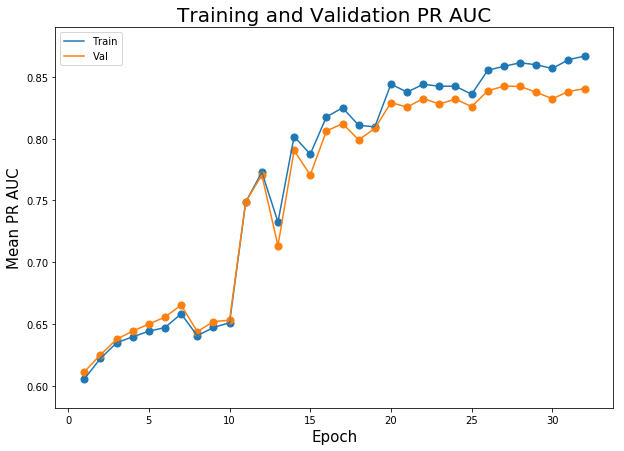

In [40]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

In [ ]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

I left the model to train longer on my local GPU. I then upload the best model and plots from the model training.

In [ ]:
#model = load_model('../input/clouds-classifier-files/classifier_densenet169_epoch_21_val_pr_auc_0.8365921057512743.h5')

In [ ]:
Image("../input/clouds-classifier-files/loss_hist_densenet169.png")

In [ ]:
Image("../input/clouds-classifier-files/pr_auc_hist_densenet169.png")

# Selecting postprocessing thresholds

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.90, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [ ]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [ ]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [ ]:
submission = pd.read_csv('../input/densenet201cloudy/densenet201.csv')
submission.head()

In [ ]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [ ]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

In [ ]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_segmentation_and_classifier.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.